In [2]:
%matplotlib inline
import os
import re
from StringIO import StringIO
import numpy as np
import pandas as pd
import scipy.ndimage as ndi
from skimage import measure, io
import matplotlib.pyplot as plt
import mahotas as mh
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
import matplotlib
from sklearn import mixture
import scipy.stats as stats

/home/ws/ih7618/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
matplotlib.__version__

'2.0.2'

In [4]:
def open_gdocs(url):
    import requests
    r = requests.get(url, verify=False)
    data = r.content
    df = pd.read_csv(StringIO(data), decimal=b',')
    return df

In [5]:
def save_fig(fig, output_filepath, dpi=72, use_tl=True):
    output_path, filename = os.path.split(output_filepath)
        
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    if use_tl:
        plt.tight_layout()
        
    fig.savefig(output_filepath, dpi=dpi)

In [6]:
def number(val):
    if val < 1000:
        return '%d' % val
        
    sv = str(val)
    return '$\mathregular{10^{%d}}$' % (len(sv)-2) if val % 10 == 0 else '%0.0e' % val

In [7]:
def get_data_by_type(path, type, unit_scale=1.8):
    if type == 'p':
        data = pd.read_csv(path)['area'] * (unit_scale**3)
    elif type == 'd':
        data = np.load(path).item()
        data = data['diameter']
        data = data * unit_scale * 2
    else:
        return None
    
    return data

In [8]:
def get_result_path(sample_name, input_dir, type='o', window_size=31):
    if type == 'd':
        return os.path.join(input_dir, '{sample_name}_diameter_evaluation.npy'.format(sample_name=sample_name))
    elif type == 'o':
        return os.path.join(input_dir, '{sample_name}_w{window_size}_orientation_evaluation.npy'.format(sample_name=sample_name, window_size=window_size))
    elif type == 'p':
        return os.path.join(input_dir, sample_name, 'particles_stats_{sample_name}.csv'.format(sample_name=sample_name))
    else:
        return None

In [76]:
DEF_COLOR = ['#ae4900', '#c75400', '#e15e00', '#ff862e', '#ff862e']

COLORS = {
    'PCL_wa': ['#740000', '#9e0000', '#c20000', '#f40c0c', '#f94747'],
    'PCL_cl': ['#2a4000', '#446800', '#5b8a03', '#75a717', '#94c536'],
    'PCL_SiHA_cl': ['#0529a2', '#0c37c4', '#2c4ebe', '#4f66b4', '#8c99c3'],
    'PCL_SiHA_wa': ['#593159', '#6f496f', '#846584', '#9c879c', '#c4b9c4'],
    'PCLSrHA15ro': ['#C93E03', '#E65214', '#E36F3C', '#EA875D', '#FFB08F'],
    'PCLSiHA15wa': ['#094F80', '#086EB0', '#2A80B9', '#4995C7', '#72AFDB']
}

NAMES = {
    'PCL_cl': 'rPCL',
    'PCL_wa': 'wPCL',
    'PCL_SiHA_cl': 'rPCL-SiHA',
    'PCL_SiHA_wa': 'wPCL-SiHA'
}

In [10]:
def plot_complex_hist(input_dir, output_dir, charts_params, type='p', window_size=31, unit_scale=1.8, scale=2):
    for sample_name, chart_params in charts_params.items():
        fig = plt.figure(figsize=(27*scale,15*scale))
        
        for chart_param in chart_params:
            dpy_path = get_result_path(sample_name, input_dir, type=type)
            dpy = pd.read_csv(dpy_path)['area'] * (unit_scale**3)

            nbins, vmin, vmax = chart_param['range']
            dpy_lim = dpy[(dpy >= vmin) & (dpy < vmax)]
           
            fig, ax = plot_histogram(dpy_lim,
                                   fig=fig,
                                   splot_index=chart_param['pidx'],
                                   scale=scale,
                                   num_bins=nbins,
                                   color=chart_param['color'],
                                   xlabel=chart_param['xlabel'],
                                   ylabel=chart_param['ylabel'],
                                   xlim=(vmin, vmax),
                                   labelpad=15,
                                   exp_fontsize=25,
                                   labels_fontsize=30,
                                   grid_alpha=0.3,
                                   ticks_pad=7,
                                   yticks_fontsize=30,
                                   xticks_fontsize=30,
                                   bar_width=0.8,
                                   normed=False,
                                   use_sci_xaxis=True,
                                   use_sci_yaxis=True,
                                   use_xlocator=True)

In [11]:
def create_pie_chart_plain(sample_name, input_data, output_dir, rngs, title=None, \
                           type='p', lang='en', measure_type='vol', \
                           zebra_color_idxs=None, legend_fontsize=50, chart_fontsize=60, dpi=72,
                           color_name=None):
    df = input_data
    
    print 'Max: {}, Min: {}'.format(df.max(), df.min())
    
    data_ranges = []
    for rng in rngs:
        rng_min, rng_max = rng[0], rng[1]
        data_rng = df[(df > rng_min) & (df < rng_max)]
        data_ranges.append(data_rng)
    
    num_elem = [len(p) for p in data_ranges]
    se = sum(num_elem)
    
    print 'Num of particles: {}'.format(se)

    proc_particles = [n/float(se) * 100.0 for n in num_elem]
    
    for size, rng in zip(num_elem, rngs):
        print '{}-{}: {}'.format(rng[0], rng[1], size)
                      
    def get_title(v1, v2, lang, measure_type):
        if measure_type == 'vol':
            measure_quantity = 'm^3' if lang == 'en' else u'м^3'
        else:
            measure_quantity = 'm' if lang == 'en' else u'м'
        
        ftm = '%s $\minus$ %s $\mathregular{\mu %s}$' if lang == 'en' else u'%s $\minus$ %s $\mathregular{мк%s}$'
        return ftm % (number(v1), number(v2), measure_quantity)
                      
    titles = [get_title(minv, maxv, lang, measure_type) for minv,maxv in rngs]
    
    if color_name is None:
        colors = COLORS.get(sample_name, DEF_COLOR)
    else:
        colors = COLORS.get(color_name, DEF_COLOR)
        
    textprops={'fontsize': chart_fontsize, 'weight': 'normal', 'family': 'sans-serif'}
    pie_width = 0.5
    fig, ax = plt.subplots(figsize=(33,15))
    ax.axis('equal')
    patches, texts, autotexts = ax.pie(proc_particles, \
                                       textprops=textprops, \
                                       colors=colors, \
                                       autopct='%1.1f%%', \
                                       radius=1, \
                                       pctdistance=1-pie_width/2)
    if zebra_color_idxs is not None:
        for zi in zebra_color_idxs:
            autotexts[zi].set_color('white')
    #if (zebra_color is not None) and (zebra_color[0]):
        #for tt in autotexts[:zebra_color[1]]:
            #tt.set_color('white')
    
    plt.setp(patches, \
             width=pie_width, \
             edgecolor='white')

    plt.legend(patches, titles, loc=(0.383,-0.35), fontsize=legend_fontsize)
    
    _d, _offset, _di = [1,-1, 2, -2], [0.45, 0.45, 0.45, 0.45], 0
    
    for t, p in zip(autotexts, proc_particles):
        if p < 2.0:
            pos = list(t.get_position())
            pos[0] = pos[0] + _d[_di] * _offset[_di]

            t.set_position(pos)
            _di += 1

    out_figdir = os.path.join(output_dir, sample_name)
    
    if not os.path.exists(out_figdir):
        os.makedirs(out_figdir)
    
    out_figpath = os.path.join(out_figdir, '_'.join([sample_name, title, 'pie', lang]) + '.png')
    
    plt.tight_layout()
    fig.savefig(out_figpath, bbox_inches='tight', transparent=True, pad_inches=0.1, dpi=dpi)

In [12]:
def create_pie_chart(sample_name, input_dir, output_dir, rngs, title=None, \
                     type='p', unit_scale=1.8, lang='en', measure_type='vol', 
                     zebra_color=(False,3), legend_fontsize=50, chart_fontsize=60, dpi=72,
                     color_name=None):
    dpy_path = get_result_path(sample_name, input_dir, type=type)
    df = get_data_by_type(dpy_path, type=type, unit_scale=unit_scale)
    
    print 'Max: {}, Min: {}'.format(df.max(), df.min())
    
    data_ranges = []
    for rng in rngs:
        rng_min, rng_max = rng[0], rng[1]
        data_rng = df[(df > rng_min) & (df < rng_max)]
        data_ranges.append(data_rng)
    
    num_elem = [len(p) for p in data_ranges]
    se = sum(num_elem)
    
    print 'Num of particles: {}'.format(se)

    proc_particles = [n/float(se) * 100.0 for n in num_elem]
    
    for size, rng in zip(num_elem, rngs):
        print '{}-{}: {}'.format(rng[0], rng[1], size)
                      
    def get_title(v1, v2, lang, measure_type):
        if measure_type == 'vol':
            measure_quantity = 'm^3' if lang == 'en' else u'м^3'
        else:
            measure_quantity = 'm' if lang == 'en' else u'м'
        
        ftm = '%s $\minus$ %s $\mathregular{\mu %s}$' if lang == 'en' else u'%s $\minus$ %s $\mathregular{мк%s}$'
        return ftm % (number(v1), number(v2), measure_quantity)
                      
    titles = [get_title(minv, maxv, lang, measure_type) for minv,maxv in rngs]
    
    if color_name is None:
        colors = COLORS.get(sample_name, DEF_COLOR)
    else:
        colors = COLORS.get(color_name, DEF_COLOR)
        
    textprops={'fontsize': chart_fontsize, 'weight': 'normal', 'family': 'sans-serif'}
    pie_width = 0.5
    fig, ax = plt.subplots(figsize=(33,15))
    ax.axis('equal')
    patches, texts, autotexts = ax.pie(proc_particles, \
                                       textprops=textprops, \
                                       colors=colors, \
                                       autopct='%1.1f%%', \
                                       radius=1, \
                                       pctdistance=1-pie_width/2)
    
    if (zebra_color is not None) and (zebra_color[0]):
        for tt in autotexts[:zebra_color[1]]:
            tt.set_color('white')
    
    plt.setp(patches, \
             width=pie_width, \
             edgecolor='white')

    plt.legend(patches, titles, loc=(0.383,-0.45), fontsize=legend_fontsize)
    
    _d, _offset, _di = [1,-1, 2, -2], [0.45, 0.45, 0.45, 0.45], 0
    
    for t, p in zip(autotexts, proc_particles):
        if p < 2.0:
            pos = list(t.get_position())
            pos[0] = pos[0] + _d[_di] * _offset[_di]

            t.set_position(pos)
            _di += 1

    out_figdir = os.path.join(output_dir, sample_name)
    
    if not os.path.exists(out_figdir):
        os.makedirs(out_figdir)
    
    out_figpath = os.path.join(out_figdir, '_'.join([sample_name, title, 'pie', lang]) + '.png')
    
    plt.tight_layout()
    fig.savefig(out_figpath, bbox_inches='tight', transparent=True, pad_inches=0.1, dpi=dpi)

In [56]:
def plot_histogram_fig(data, num_bins, xticks, color, splot_index=111,
                       xlim=(None,None), ylim=(None,None),
                       bar_width=0.8, ticks_pad=7, xticks_fontsize=22, 
                       yticks_fontsize=22, xlabel=None, ylabel=None,
                       yticks=None,
                       name=None, output_dir=None,
                       dpi=200,
                       in_percent=False,
                       labels_fontsize=20, grid_alpha=0.3, title_fontsize=22, 
                       exp_fontsize=15, type=None, figsize=(12,8), cyclical_offset=0, norm=True):
    import matplotlib.ticker as plticker
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(splot_index)
    
    if cyclical_offset != 0 and data.max() > 90:
        min_val = data.min()
        print min_val
        data -= min_val
        data += cyclical_offset
        data = np.mod(data, 180.)
        data += min_val
    
    weights = np.ones_like(data)/float(len(data))
    
    n, bins, patches = ax.hist(data, num_bins, color=color, rwidth=bar_width, weights=weights)
    print(sum(n * np.diff(bins)))

    if norm:
        mu, sigma = np.mean(data), np.std(data)
        y = mlab.normpdf(bins, mu, sigma)
        ax.plot(bins, y, '--', linewidth=2)
    
    ax.tick_params(axis='x', 
                   labelsize=xticks_fontsize, 
                   colors='#000000', 
                   which='both', 
                   direction='out', 
                   length=6, 
                   width=2, 
                   pad=ticks_pad)
    ax.tick_params(axis='x', 
                   labelsize=xticks_fontsize, 
                   colors='#000000', 
                   which='minor', 
                   direction='out', 
                   length=4, 
                   width=2,
                   pad=ticks_pad)
        
    ax.tick_params(axis='y', 
                   labelsize=yticks_fontsize, 
                   colors='#000000', 
                   which='major', 
                   direction='out', 
                   length=6, 
                   width=2,
                   pad=ticks_pad)
    ax.tick_params(axis='y', 
                   labelsize=xticks_fontsize, 
                   colors='#000000', 
                   which='minor', 
                   direction='out', 
                   length=4, 
                   width=2,
                   pad=ticks_pad)

    ax.xaxis.set_minor_locator(plticker.MultipleLocator(5))
    ax.yaxis.set_minor_locator(plticker.MultipleLocator(5))
    
    pos = np.linspace(xticks.min(), xticks.max(), num=len(xticks))
    plt.xticks(xticks, xticks)
    
    if yticks is not None:
        plt.yticks(yticks, yticks)

    if in_percent:
        vals = ax.get_yticks()
        ax.set_yticklabels(['{:3.0f}'.format(x*100) for x in vals])
        
    ax.xaxis.offsetText.set_fontsize(exp_fontsize)
    ax.yaxis.offsetText.set_fontsize(exp_fontsize)
    
    if not in_percent:
        ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2), fontsize=yticks_fontsize)
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=6, min_n_ticks=5))

    ax.xaxis.grid(False)
    ax.yaxis.grid(False)
    #ax.yaxis.grid(lw=1*scale, color='#aaaaaa', alpha=grid_alpha)

    ax.set_ylabel(ylabel, labelpad=2, fontsize=labels_fontsize, color='black')
    ax.set_xlabel(xlabel, labelpad=2, fontsize=labels_fontsize, color='black')
    
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    
    ax.set_axisbelow(True)
    
    if output_dir is not None:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        plt.tight_layout()
        fig.savefig(os.path.join(output_dir, name + '.png'), transparent=False, bbox_inches='tight', pad_inches=0.1, dpi=dpi)
    
    return fig, ax

In [57]:
def plot_histogram_gmm_fig(data, num_bins, xticks, color, splot_index=111,
                           n_gmm_components=1, xlim=(None,None), ylim=(None,None),
                           bar_width=0.8, ticks_pad=7, xticks_fontsize=22, 
                           yticks_fontsize=22, xlabel=None, ylabel=None,
                           yticks=None,
                           name=None, output_dir=None,
                           dpi=200,
                           in_percent=False,
                           labels_fontsize=20, grid_alpha=0.3, title_fontsize=22, 
                           exp_fontsize=15, type=None, figsize=(12,8)):
    import matplotlib.ticker as plticker
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(splot_index)
    
    weights = np.ones_like(data)/float(len(data))
    
    n, bins, patches = ax.hist(data, num_bins, color=color, rwidth=bar_width, weights=weights)
    print(sum(n * np.diff(bins)))
    
    g = mixture.GMM(n_components=n_gmm_components)

    g.fit(np.array([data]).T)
    weights = g.weights_
    means = g.means_
    covars = g.covars_
    
    x_gmm = np.linspace(data.min(), data.max(), 1000)
    
    for nc in xrange(n_gmm_components):
        mean = means[nc]
        sigma = np.sqrt(covars[nc])
        ax.plot(x_gmm, weights[nc] * stats.norm.pdf(x_gmm, mean, sigma), lw=3, c='black')
    
    ax.tick_params(axis='x', 
                   labelsize=xticks_fontsize, 
                   colors='#000000', 
                   which='both', 
                   direction='out', 
                   length=6, 
                   width=2, 
                   pad=ticks_pad)
    ax.tick_params(axis='x', 
                   labelsize=xticks_fontsize, 
                   colors='#000000', 
                   which='minor', 
                   direction='out', 
                   length=4, 
                   width=2,
                   pad=ticks_pad)
        
    ax.tick_params(axis='y', 
                   labelsize=yticks_fontsize, 
                   colors='#000000', 
                   which='major', 
                   direction='out', 
                   length=6, 
                   width=2,
                   pad=ticks_pad)
    ax.tick_params(axis='y', 
                   labelsize=xticks_fontsize, 
                   colors='#000000', 
                   which='minor', 
                   direction='out', 
                   length=4, 
                   width=2,
                   pad=ticks_pad)

    ax.xaxis.set_minor_locator(plticker.MultipleLocator(5))
    ax.yaxis.set_minor_locator(plticker.MultipleLocator(5))
    
    pos = np.linspace(xticks.min(), xticks.max(), num=len(xticks))
    plt.xticks(xticks, xticks)
    
    if yticks is not None:
        plt.yticks(yticks, yticks)

    if in_percent:
        vals = ax.get_yticks()
        ax.set_yticklabels(['{:3.0f}'.format(x*100) for x in vals])
        
    ax.xaxis.offsetText.set_fontsize(exp_fontsize)
    ax.yaxis.offsetText.set_fontsize(exp_fontsize)
    
    if not in_percent:
        ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2), fontsize=yticks_fontsize)
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=6, min_n_ticks=5))

    ax.xaxis.grid(False)
    ax.yaxis.grid(False)
    #ax.yaxis.grid(lw=1*scale, color='#aaaaaa', alpha=grid_alpha)

    ax.set_ylabel(ylabel, labelpad=2, fontsize=labels_fontsize, color='black')
    ax.set_xlabel(xlabel, labelpad=2, fontsize=labels_fontsize, color='black')
    
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    
    ax.set_axisbelow(True)
    
    if output_dir is not None:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        plt.tight_layout()
        fig.savefig(os.path.join(output_dir, name + '_gmm_{}.png'.format(n_gmm_components)),
                    transparent=False, bbox_inches='tight', pad_inches=0.1, dpi=dpi)
    
    return fig, ax

In [40]:
def plot_histogram(data, fig=None, splot_index=111,
                   num_bins=50, scale=2., exp_fontsize=14, 
                   labels_fontsize=18, grid_alpha=0.4,
                   figsize=(12,8),
                   ylim=(None,None), xlim=(None,None),
                   xticks=None, yticks=None,
                   use_sci_yaxis=True, use_sci_xaxis=False,
                   ticks_pad=10, color='#19B5FE', 
                   ylabel=None, xlabel=None, 
                   yticks_fontsize=18, xticks_fontsize=18,
                   title=None, bar_width=None, 
                   title_fontsize=22,
                   labelpad=2, use_xlocator=False,
                   use_log=False, normed=True, type=None,
                   cyclical_offset=0):
    if fig is None:
        fig = plt.figure(figsize=tuple([v * scale for v in figsize]))
        
    ax = fig.add_subplot(splot_index)
    
    if cyclical_offset != 0:
        min_val = data.max()
        print min_val
        data -= min_val
        data += cyclical_offset
        data = np.mod(data, 180.)
        data += min_val
    
    n, bins, patches = ax.hist(data, num_bins, normed=normed, color=color, rwidth=bar_width)

    mu, sigma = np.mean(data), np.std(data)
    y = mlab.normpdf(bins, mu, sigma)
    ax.plot(bins, y, '--', linewidth=2*scale)
    
    ax.tick_params(color='black', labelcolor='black', direction='out', pad=ticks_pad*scale)
    ax.tick_params(axis='y', which='major', labelsize=yticks_fontsize*scale)
    ax.tick_params(axis='x', which='major', labelsize=xticks_fontsize*scale)
    
    if xticks is not None:
        pos = np.linspace(xticks.min(), xticks.max(), num=len(xticks))
        plt.xticks(xticks, xticks)
        
    ax.xaxis.offsetText.set_fontsize(exp_fontsize*scale)
    ax.yaxis.offsetText.set_fontsize(exp_fontsize*scale)
    
    if use_sci_yaxis:
        ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2), fontsize=exp_fontsize*scale)
    
    if use_sci_xaxis:
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2), fontsize=exp_fontsize*scale)
    
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=6, min_n_ticks=5))
    
    if use_xlocator:
        ax.xaxis.set_major_locator(ticker.MaxNLocator(prune='lower'))
    
    ax.xaxis.grid(False)
    ax.yaxis.grid(lw=1*scale, color='#aaaaaa', alpha=grid_alpha)
    
    if ylabel is not None:
        ax.set_ylabel(ylabel, labelpad=labelpad*scale, fontsize=labels_fontsize*scale, color='black')
        
    if xlabel is not None:
        ax.set_xlabel(xlabel, labelpad=labelpad*scale, fontsize=labels_fontsize*scale, color='black')
    
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    
    ax.set_axisbelow(True)
    
    if use_log:
        ax.set_yscale('log')
    
    if title is not None:
        ax.set_title(title, fontsize=title_fontsize*scale, y=1.06)
    
    return fig, ax

In [41]:
def plot_orientation_old(dpy_path, sample_params, sample_name, input_dir, save_plot_dir, color, lang='en', dpi=300, cyclical_offset=0, **kwargs):
    for key, params in sample_params.items():
        dpy = np.load(dpy_path).item()[key]
        dpy = np.rad2deg(dpy)
        dpy = dpy[np.where(dpy > 0)]
        
        fig, ax = plot_histogram_fig(dpy,
                                     params[2],
                                     np.linspace(params[1][0], params[1][1], num=10).astype(np.int32),
                                     color,
                                     xlim=params[1],
                                     ylim=params[3],
                                     yticks=params[4],
                                     cyclical_offset=cyclical_offset,
                                     **kwargs)

        out_figpath = os.path.join(save_plot_dir, sample_name, '_'.join([sample_name, key, 'orientation', lang]) + '.png')
    
        plt.tight_layout()
        fig.savefig(out_figpath, transparent=False, bbox_inches='tight', pad_inches=0.1, dpi=dpi)

In [42]:
def plot_from_samples(input_dir, sample_names, sample_params, save_plot_dir, color, dpi=300, type='o', window_size=31, cyclical_offset=0, **kwargs):
    for sample_name in sample_names:
        dpy_path = get_result_path(sample_name, input_dir, type=type, window_size=window_size)
        
        print 'Sample: {0} ({1})'.format(sample_name, dpy_path)
        
        if type == 'o':
            plot_orientation_old(dpy_path, sample_params, sample_name, input_dir, save_plot_dir, color, dpi=dpi, type=type, cyclical_offset=cyclical_offset, **kwargs)
        elif type == 'd':
            plot_diameter(dpy_path, sample_params, save_plot_dir, type=type, **kwargs)
        else:
            raise ValueError('Incorrect type.')

In [43]:
def plot_particles_chart(particles,
                         labels,
                         output_dir,
                         lang='en', 
                         dpi=300):
    import matplotlib.ticker as plticker
    
    fontsize = 20
    exp_fontsize = 15
    ylabel = 'Number of particles' if lang == 'en' else u'Количество частиц'
    
    fig, ax = plt.subplots(figsize=(5, 5))
    fig.subplots_adjust(left=0.3, right=0.9, bottom=0.15, top=0.95)
        
    sp_names = labels
    sp_values = particles
    sp_colors = [COLORS[n][2] for n in labels]
    bar_width=0.18

    textprops={'fontsize': fontsize, 'weight': 'normal', 'family': 'sans-serif', 'color': '#000000'}

    x_pos = [0.305, 0.695]

    ax.bar(x_pos, sp_values, bar_width, align='center', color=sp_colors, edgecolor='#000000', linewidth=1.5)
    ax.set_xticks(x_pos)
    ax.set_xticklabels([NAMES[n] for n in labels], **textprops)
    ax.set_xlim([0.15, 0.85])
    
    ax.set_ylabel(ylabel, fontsize=fontsize, color='#000000')
    ax.set_yticks(np.arange(0,9000,2000))
    ax.set_ylim([0, 9000])
    
    ax.tick_params(axis='x', labelsize=fontsize, colors='#000000', which='both', direction='out', length=8, width=2)
    
    ax.tick_params(axis='y', labelsize=fontsize, colors='#000000', which='major', direction='out', length=8, width=2)
    ax.tick_params(axis='y', labelsize=fontsize, colors='#000000', which='minor', direction='out', length=4, width=2)
    
    ax.yaxis.label.set_color('#000000')
    ax.xaxis.label.set_color('#000000')
    
    ml = plticker.MultipleLocator(1000)
    ax.yaxis.set_minor_locator(ml)
    
    for k in ax.spines.keys():
        ax.spines[k].set_color('#000000')
        ax.spines[k].set_linewidth(2)
    
    ax.yaxis.offsetText.set_fontsize(exp_fontsize)
    
    #plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
    plt.show()
    
    output_filepath = os.path.join(output_dir, 'num_particles_chart_{}.png'.format(lang))
    fig.savefig(output_filepath, transparent=True, pad_inches=0, dpi=dpi)

In [44]:
def plot_porosity_chart(porosity, 
                        stds,
                        labels,
                        output_dir, 
                        lang='en', 
                        dpi=300,
                        in_percent=False):
    import matplotlib.ticker as plticker
    
    fontsize = 20
    exp_fontsize = 15
    ylabel = 'Porosity (%)' if lang == 'en' else u'Поросити (%)'
    
    fig, ax = plt.subplots(figsize=(10, 5))
    fig.subplots_adjust(left=0.3, right=0.9, bottom=0.15, top=0.95)
    
    sp_values = porosity
    sp_std = stds
    sp_names = [NAMES[n] for n in labels]
    sp_colors = [COLORS[name][2] for name in labels]
    bar_width=0.5

    textprops={'fontsize': fontsize, 'weight': 'normal', 'family': 'sans-serif', 'color': '#000000'}

    x_pos = np.arange(len(labels))

    ax.bar(x_pos, sp_values, bar_width, align='center', color=sp_colors,yerr=sp_std, edgecolor='#000000', linewidth=1.5,
           error_kw=dict(elinewidth=2, capsize=5, xlolims=True, capthick=2, ecolor='black'))
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(sp_names, **textprops)
    
    ax.set_ylabel(ylabel, fontsize=fontsize, color='#000000')
    ax.set_yticks(np.arange(0,110,10))
    ax.set_ylim([0, 100])
    
    ax.tick_params(axis='x', labelsize=fontsize, colors='#000000', which='both', direction='out', length=8, width=2)
    
    ax.tick_params(axis='y', labelsize=fontsize, colors='#000000', which='major', direction='out', length=8, width=2)
    ax.tick_params(axis='y', labelsize=fontsize, colors='#000000', which='minor', direction='out', length=4, width=2)
    
    ax.yaxis.label.set_color('#000000')
    ax.xaxis.label.set_color('#000000')
    
    ml = plticker.MultipleLocator(5)
    ax.yaxis.set_minor_locator(ml)
    
    for k in ax.spines.keys():
        ax.spines[k].set_color('#000000')
        ax.spines[k].set_linewidth(2)
    
    ax.yaxis.offsetText.set_fontsize(exp_fontsize)
    #plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
    if in_percent:
        vals = ax.get_yticks()
        ax.set_yticklabels(['{:3.0f}'.format(x*100) for x in vals])
    
    plt.show()
    
    output_filepath = os.path.join(output_dir, 'porosity_chart_{}.png'.format(lang))
    fig.savefig(output_filepath, transparent=True, pad_inches=0.1, dpi=dpi)

# Particles analysis

Max: 1121306.976, Min: 5.832
Num of particles: 8389
1-100: 3594
100-1000: 3655
1000-10000: 1013
10000-1000000: 127


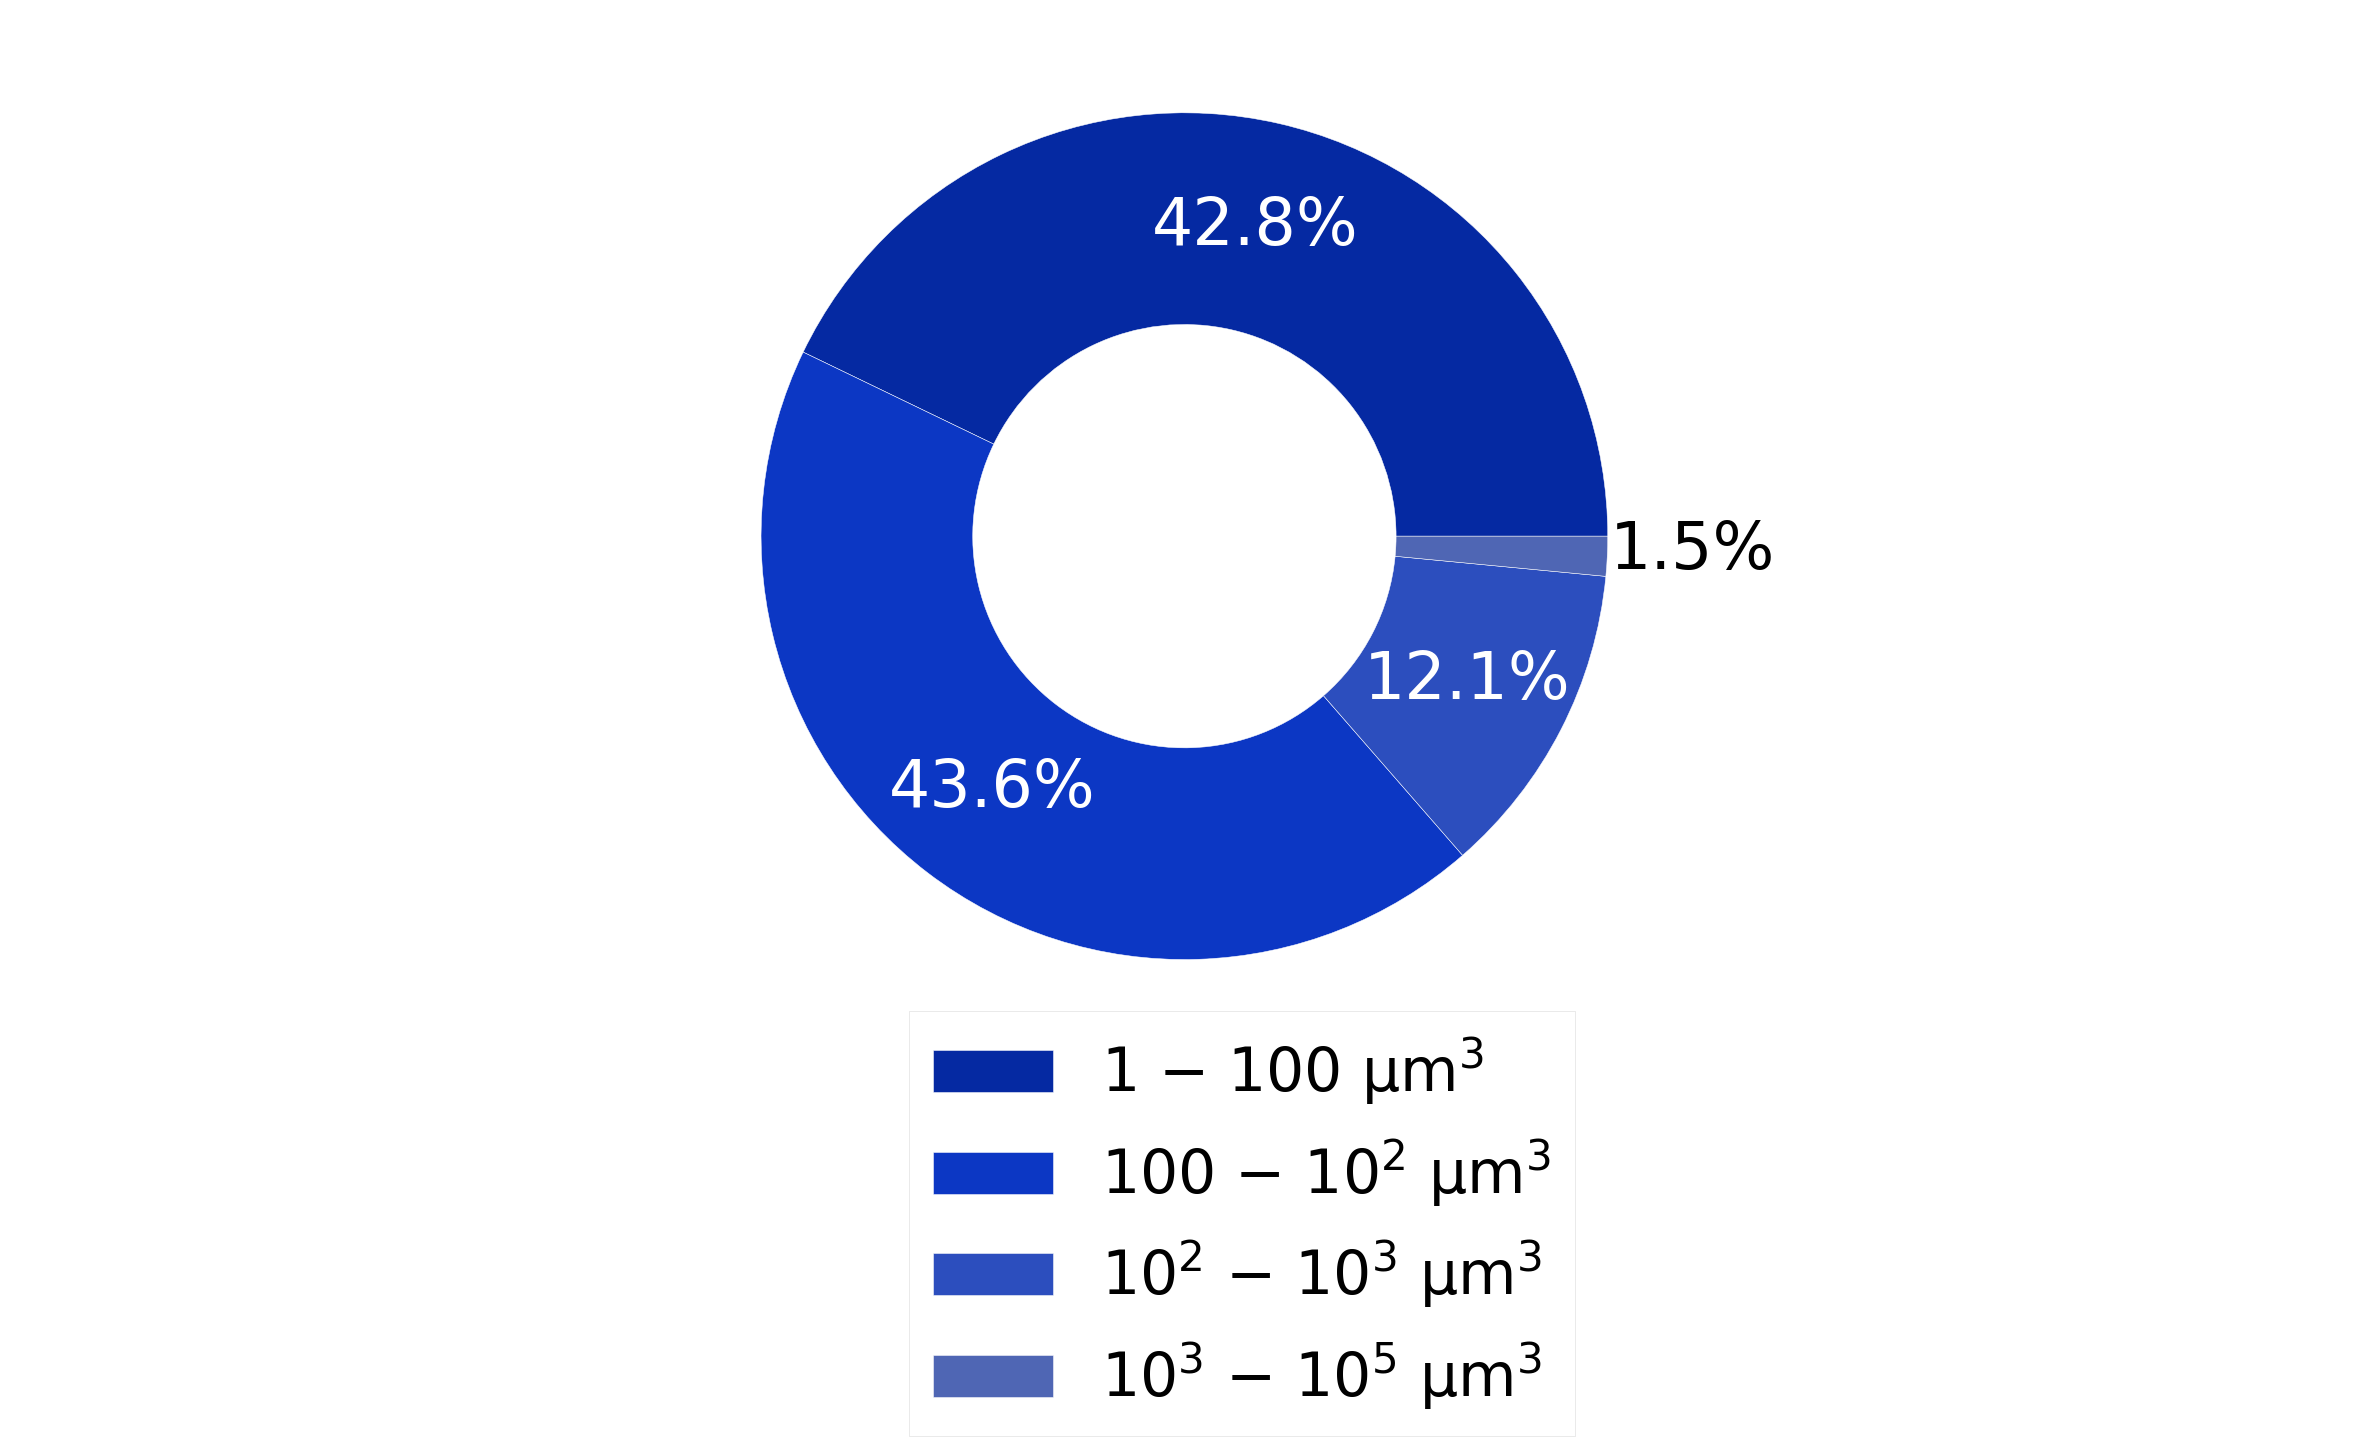

In [27]:
create_pie_chart('PCL_SiHA_cl',
                 './data/samples',
                 './data/samples/results',
                 [(1, 100), (100, 1000,), (1000,10000,), (10000, 1000000,)],
                 title='particles',
                 type='p',
                 lang='en',
                 unit_scale=1.8,
                 zebra_color=(True,3), 
                 legend_fontsize=60,
                 chart_fontsize=65)

Max: 183830.472, Min: 5.832
Num of particles: 6002
1-100: 2409
100-1000: 2759
1000-10000: 753
10000-1000000: 81


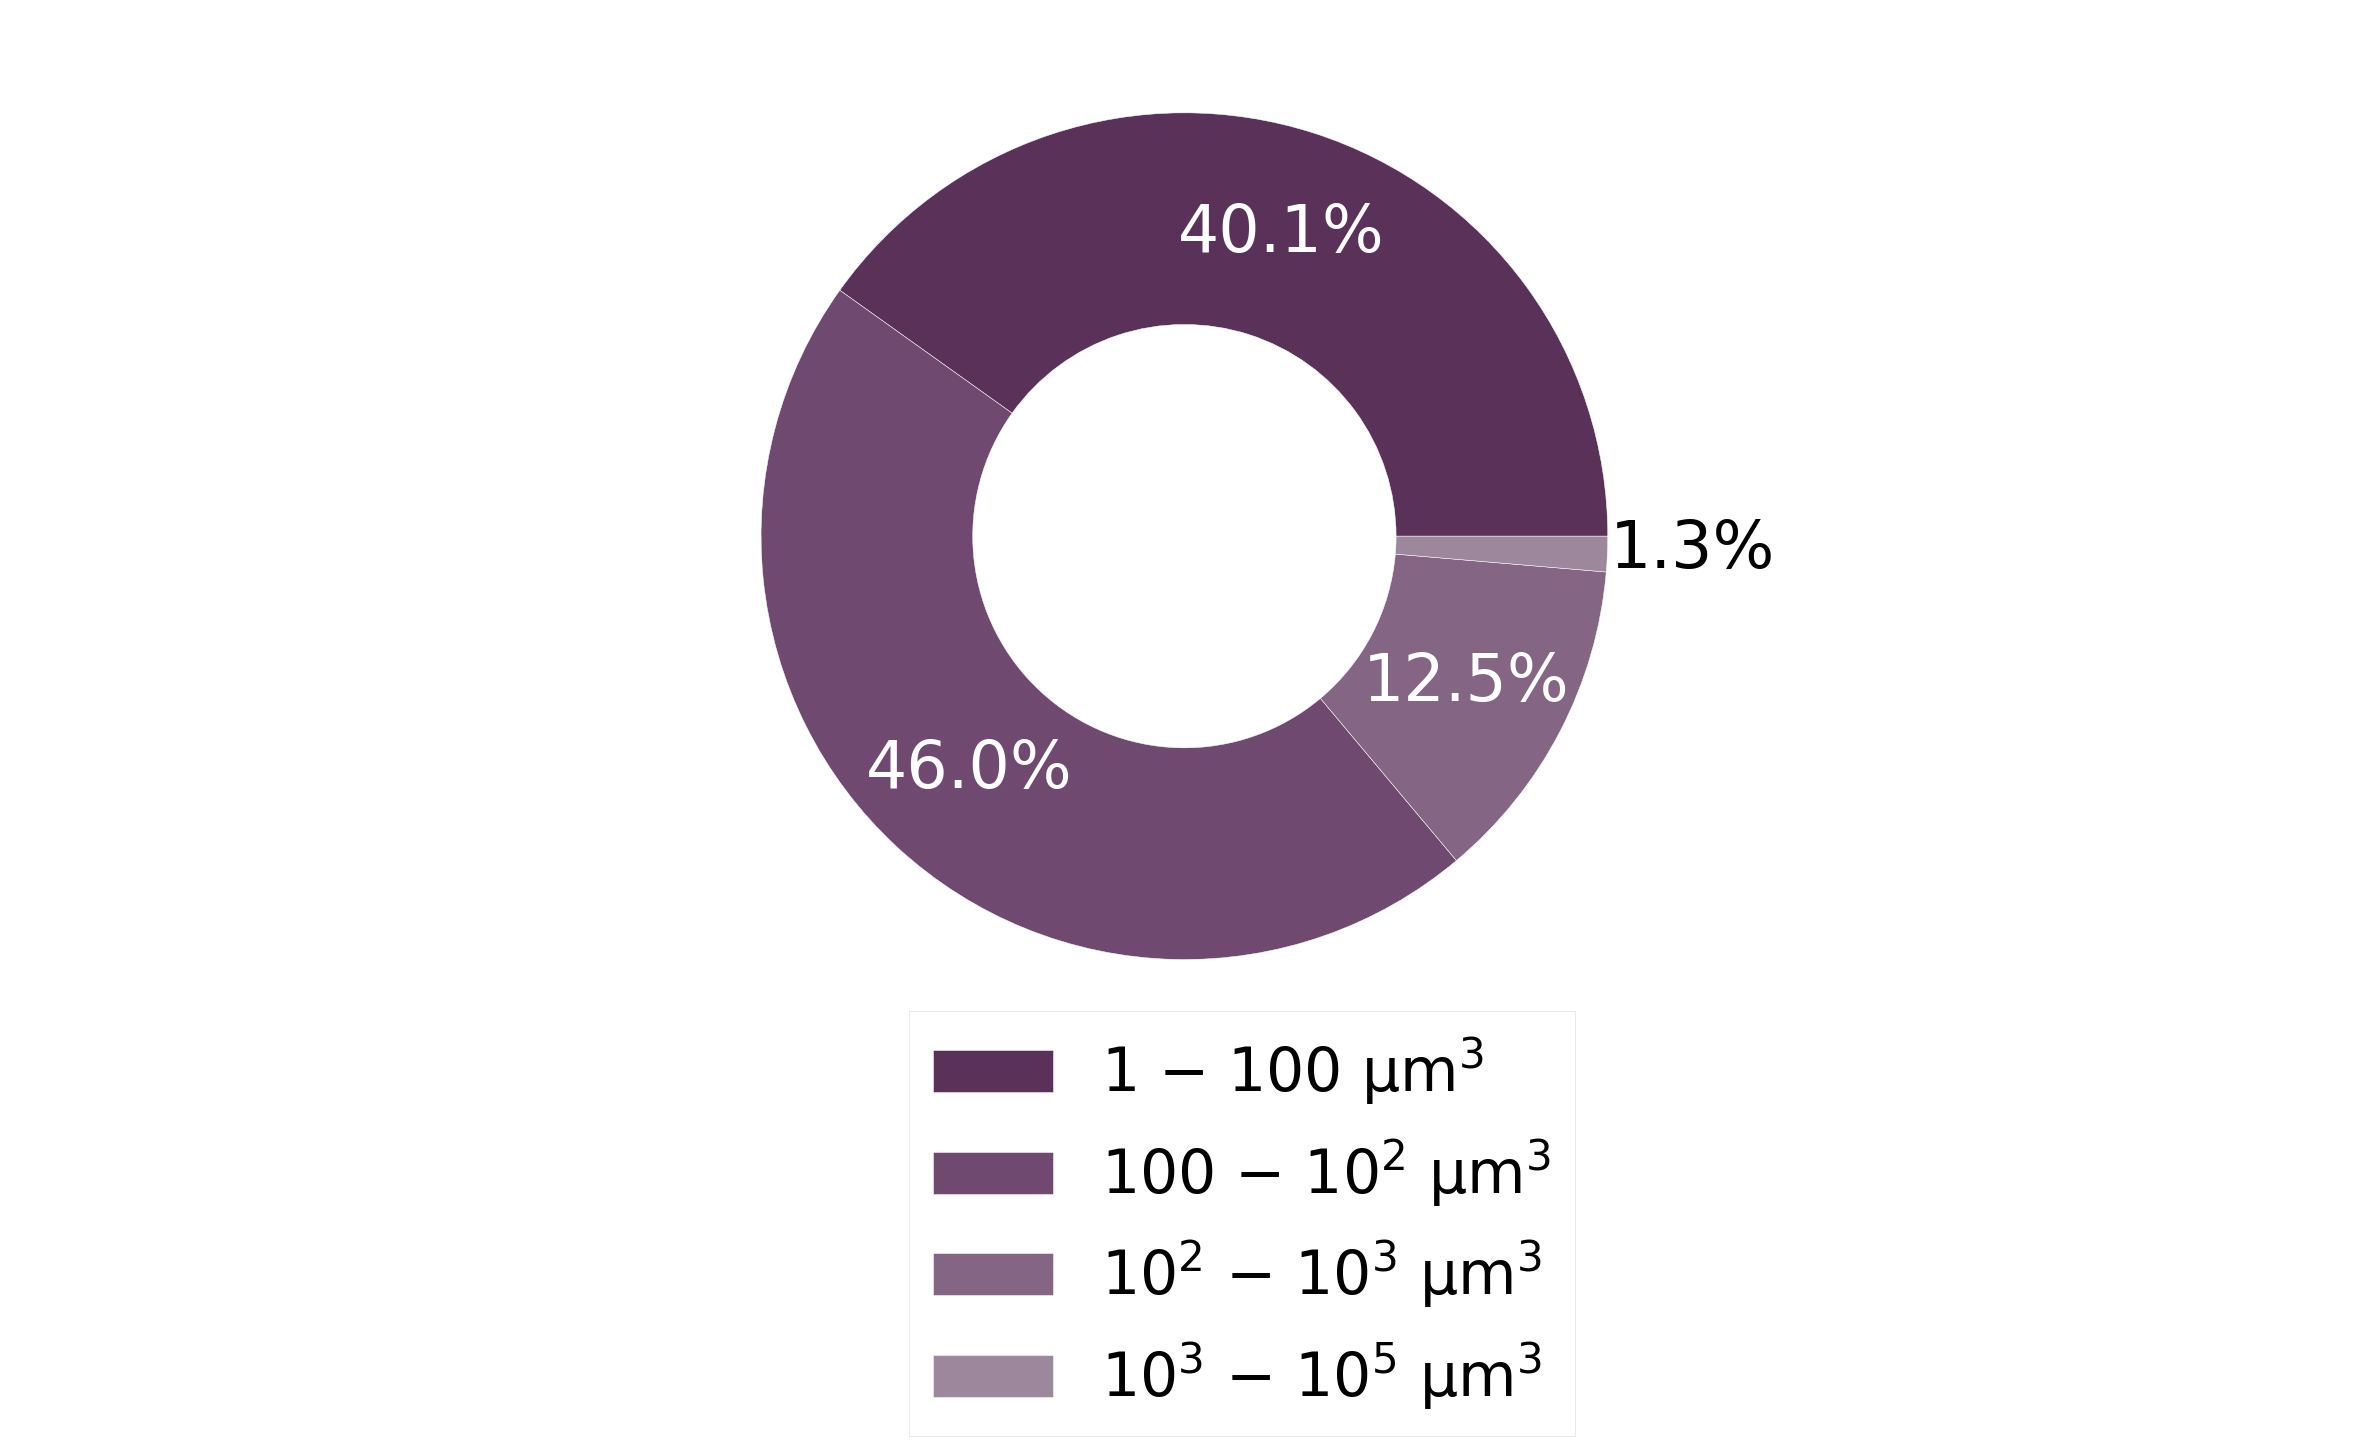

In [42]:
create_pie_chart('PCL_SiHA_wa',
                 './data/samples',
                 './data/samples/results',
                 [(1, 100), (100, 1000,), (1000,10000,), (10000, 1000000,)],
                 title='particles',
                 type='p',
                 lang='en',
                 unit_scale=1.8,
                 zebra_color=(True,3), 
                 legend_fontsize=60,
                 chart_fontsize=65)

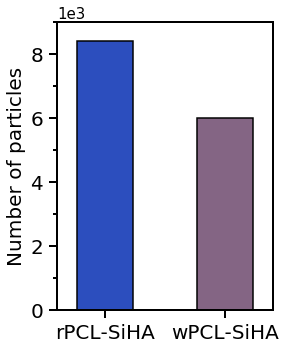

In [178]:
plot_particles_chart((8389, 6002), ('PCL_SiHA_cl', 'PCL_SiHA_wa'), './data/samples/results')

# Porosity analysis

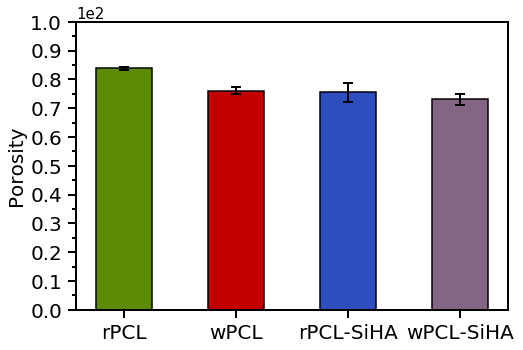

In [31]:
plot_porosity_chart((83.86, 76.12,  75.49, 73.04), 
                    (0.489, 1.136,  3.349, 1.865),
                    ('PCL_cl', 'PCL_wa', 'PCL_SiHA_cl', 'PCL_SiHA_wa'),
                    '/mnt/LSDF/tomo/rshkarin/Svetastuff/Sveta_Results_July2017')

In [ ]:
# ###### Processing of PCL_cl
# Data processing - Opening...
# Data storing - Stats and data saving...
# Porosity: 0.771454907025
# ###### Processing of PCL_SiHA_cl
# Data processing - Opening...
# Data storing - Stats and data saving...
# Porosity: 0.783606898889
# ###### Processing of PCL_SiHA_wa
# Data processing - Opening...
# Data storing - Stats and data saving...
# Porosity: 0.735002581909
# ###### Processing of PCL_wa
# Data processing - Opening...
# Data storing - Stats and data saving...
# Porosity: 0.722717198582

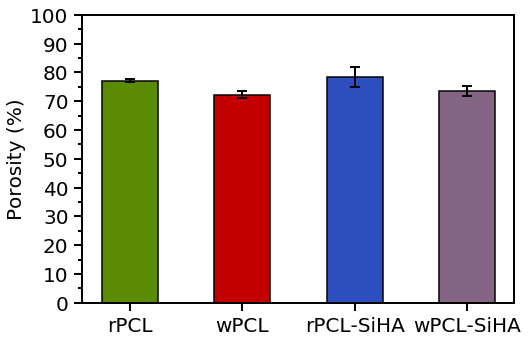

In [185]:
plot_porosity_chart((77.14, 72.27, 78.36, 73.50), 
                    (0.489, 1.136, 3.349, 1.865),
                    ('PCL_cl', 'PCL_wa', 'PCL_SiHA_cl', 'PCL_SiHA_wa'),
                    './data/samples/results',
                    in_percent=False)

# Diameter analysis

In [ ]:
#, 1-5, 5-10,10-35,35-45 and 45-75. 

Max: 428.399993896, Min: 0.0
Num of particles: 584584
1-5: 53634
5-10: 59235
10-35: 310259
35-45: 77694
45-75: 83762


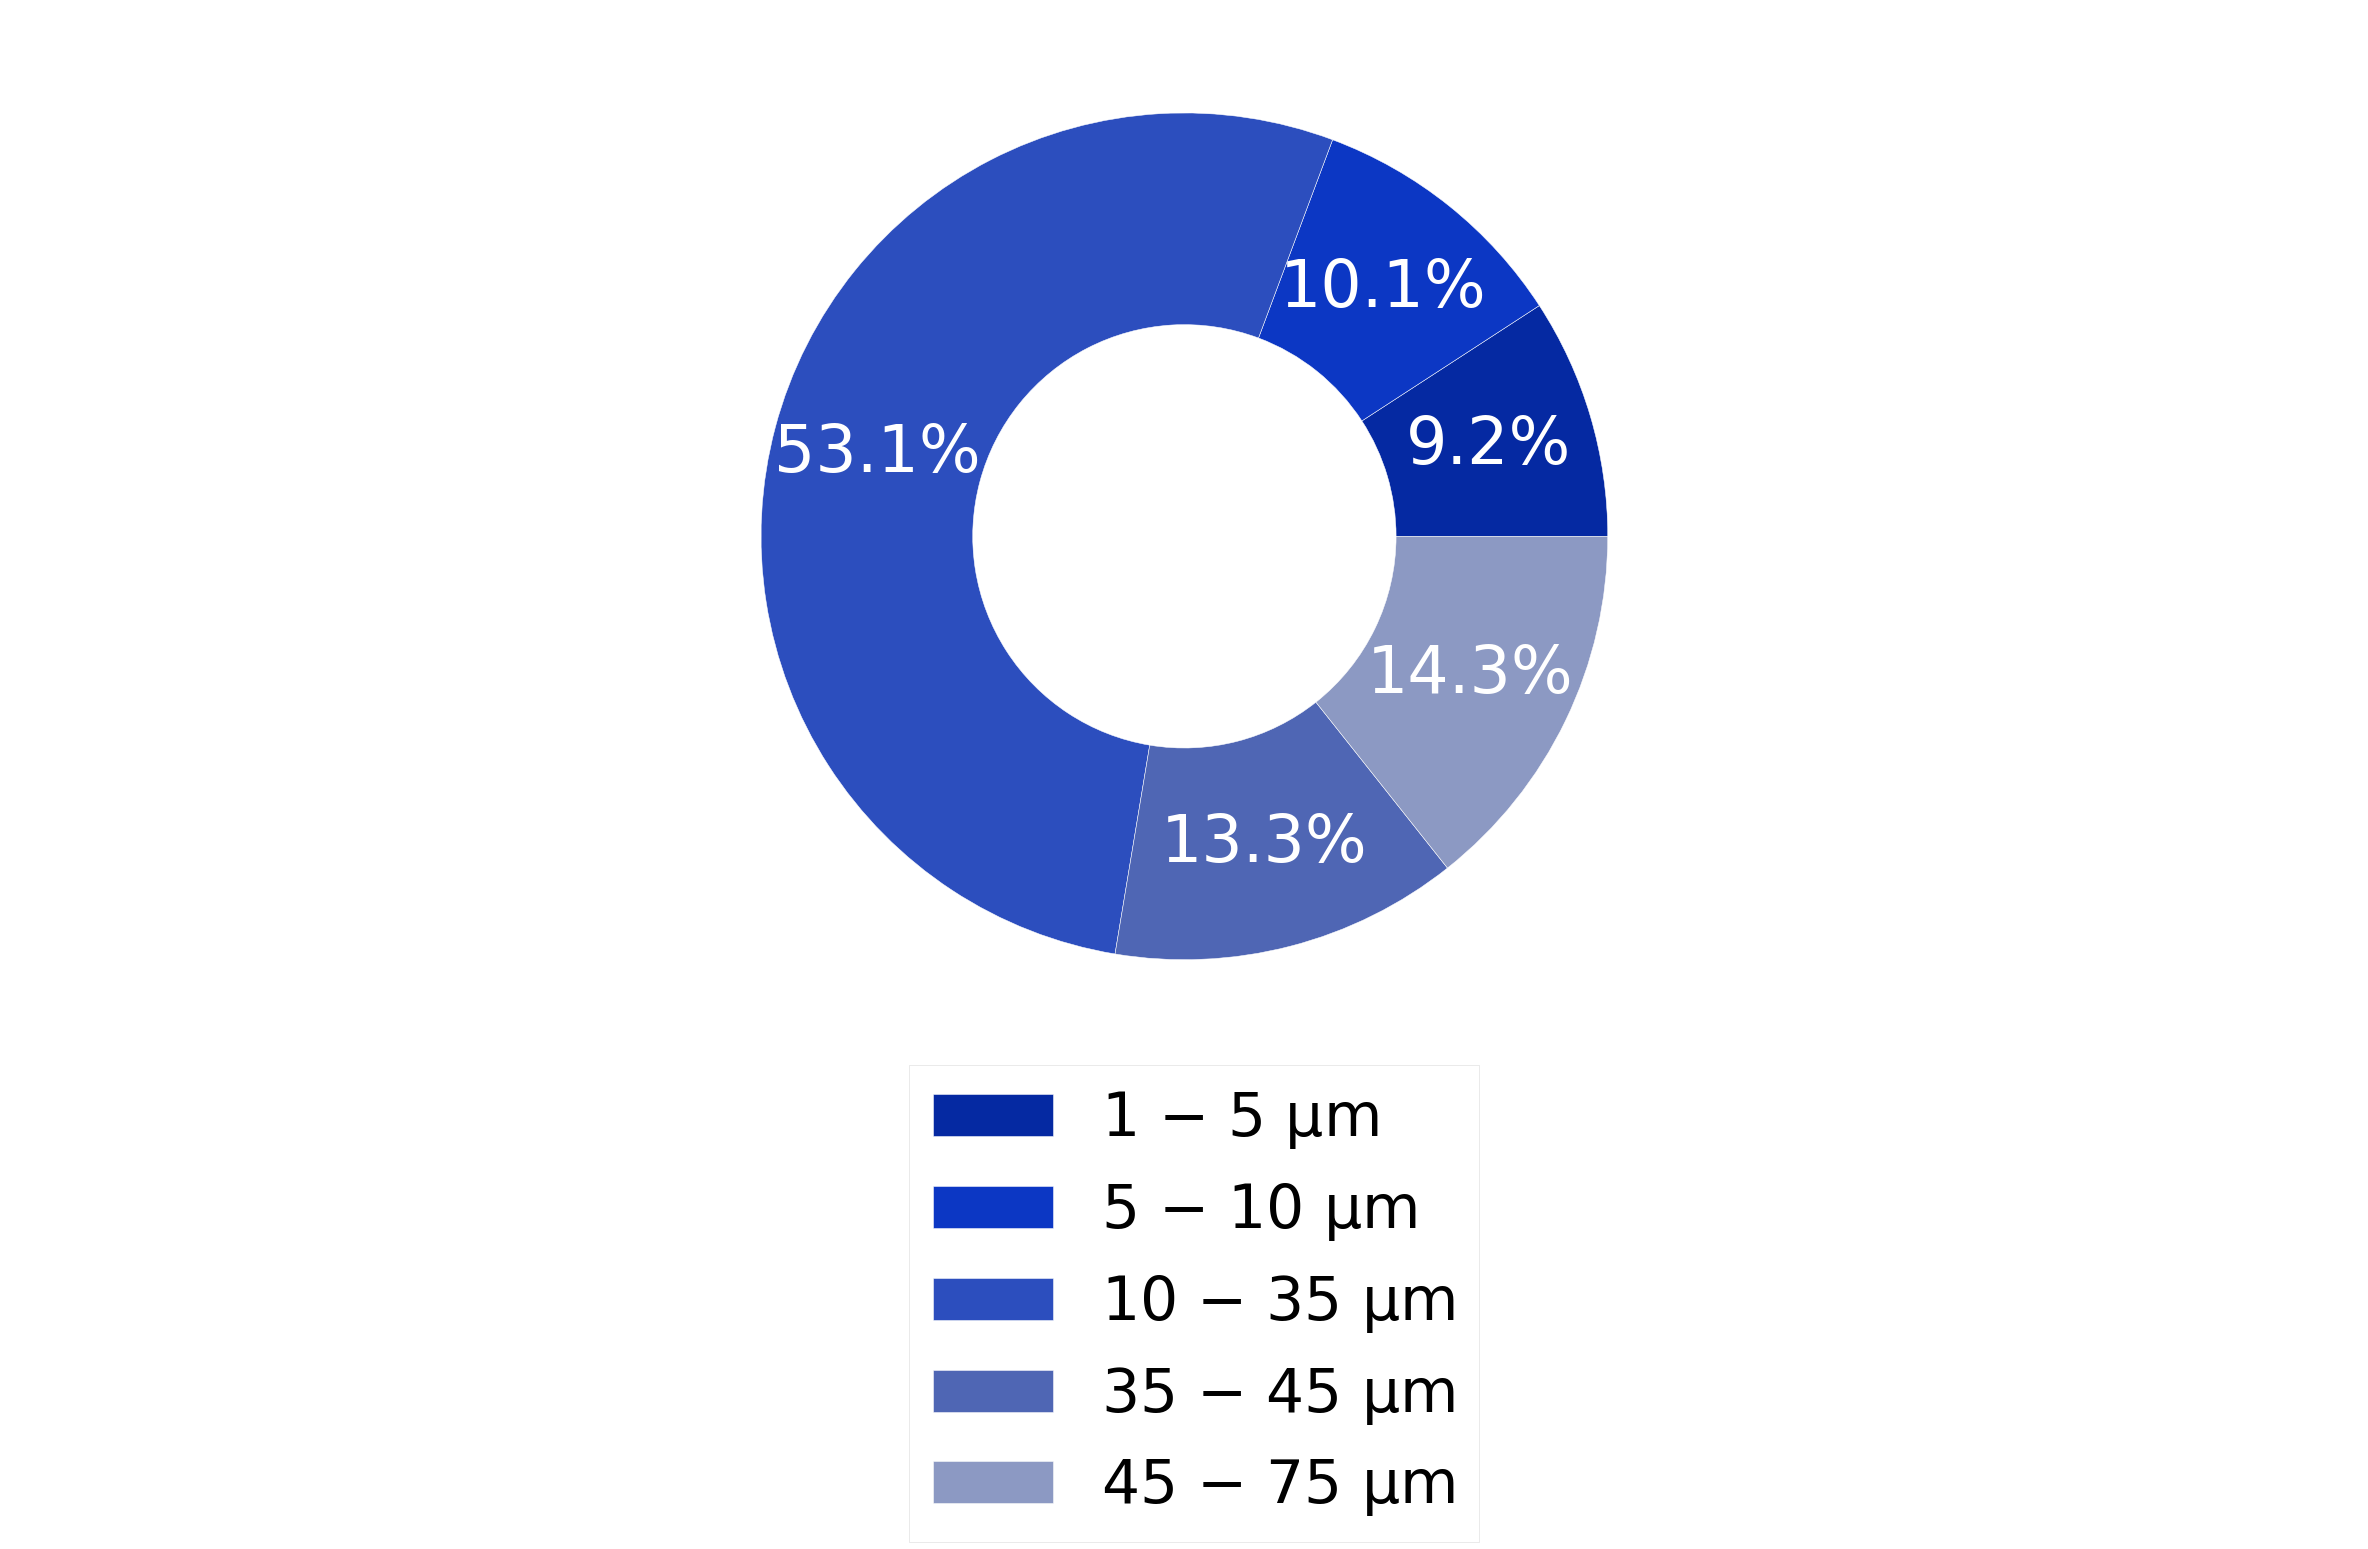

In [174]:
create_pie_chart('PCL_SiHA_cl', 
                 './data/samples',
                 './data/samples/results',
                 #[(1,10), (10,25), (25,35), (35,45), (45,75)], 
                 [(1,5), (5,10), (10,35), (35,45), (45,75)], 
                 title='diameter',
                 type='d', 
                 unit_scale=1.8,
                 measure_type='Non_vol',
                 legend_fontsize=60,
                 chart_fontsize=65,
                 zebra_color=(True,5),
                 lang='en')

Max: 406.799987793, Min: 0.0
Num of particles: 491842
1-5: 40583
5-10: 58255
10-35: 325143
35-45: 40220
45-75: 27641


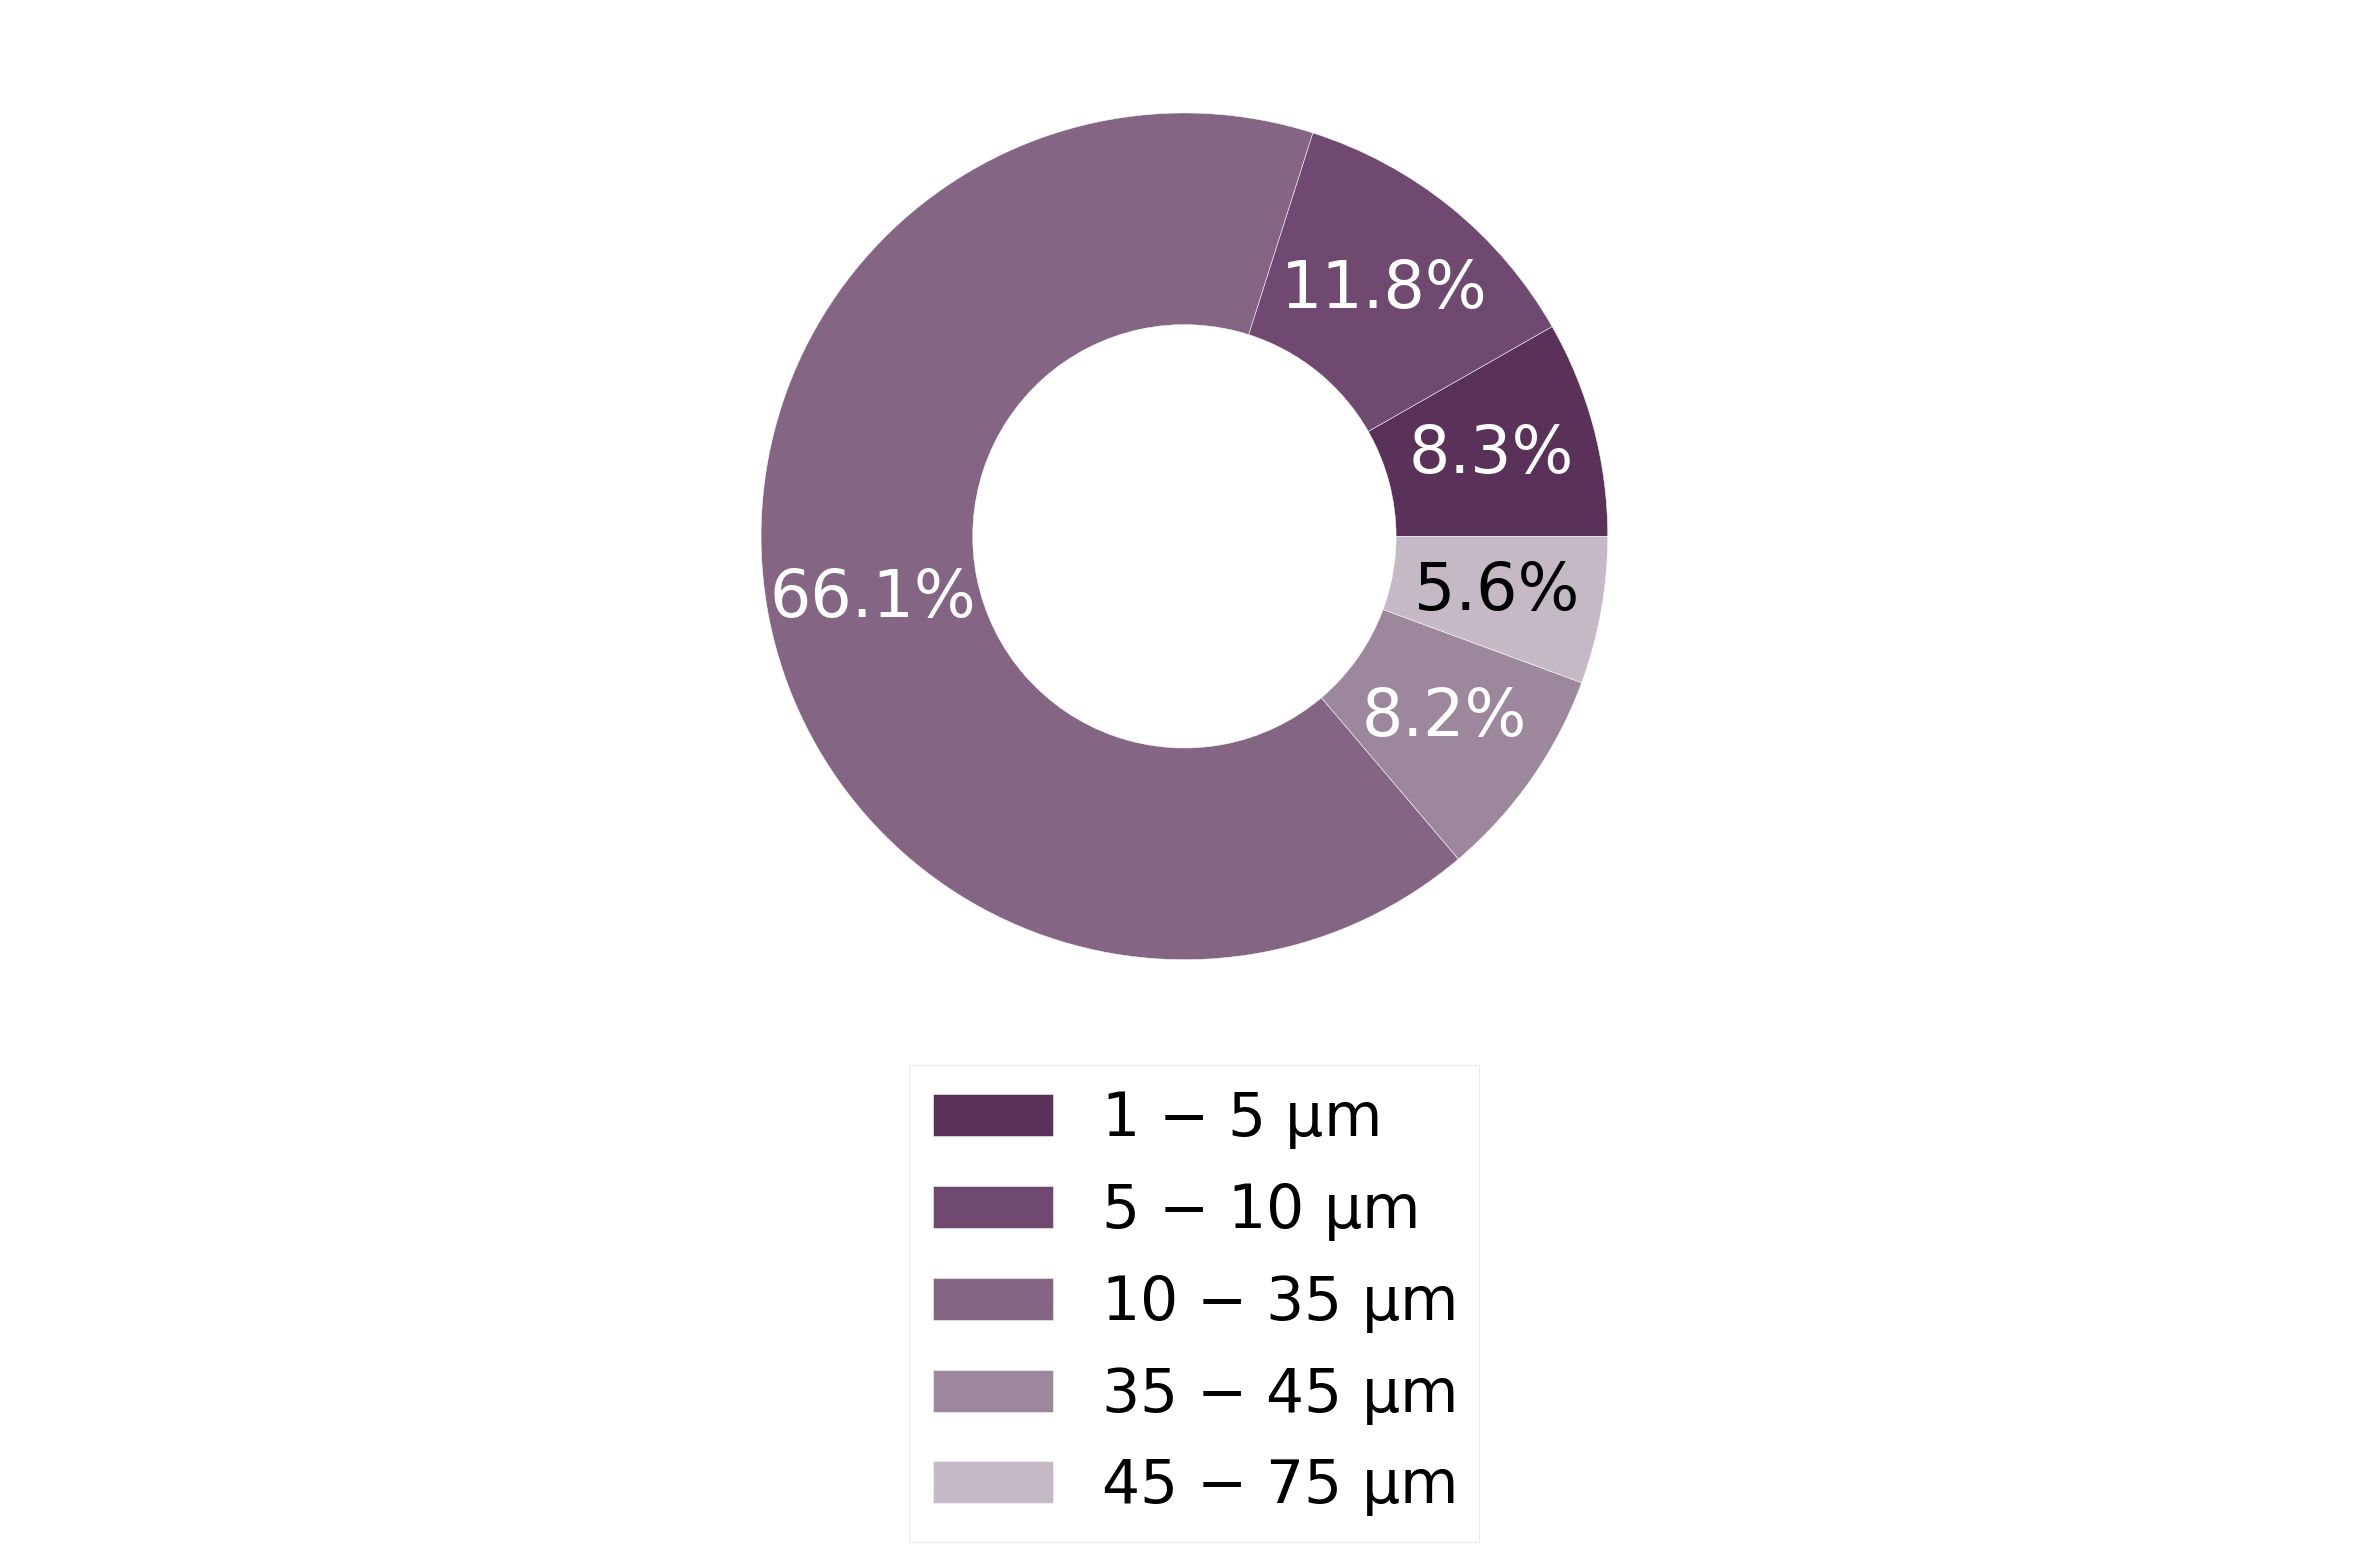

In [175]:
create_pie_chart('PCL_SiHA_wa', 
                 './data/samples',
                 './data/samples/results',
                 [(1,5), (5,10), (10,35), (35,45), (45,75)], 
                 title='diameter',
                 type='d', 
                 unit_scale=1.8,
                 measure_type='Non_vol',
                 legend_fontsize=60,
                 chart_fontsize=65,
                 zebra_color=(True,4),
                 lang='en')

Max: 43.1996994019, Min: 0.0
Num of particles: 805487
1-5: 183989
5-10: 529172
10-35: 92325
35-45: 1
45-75: 0


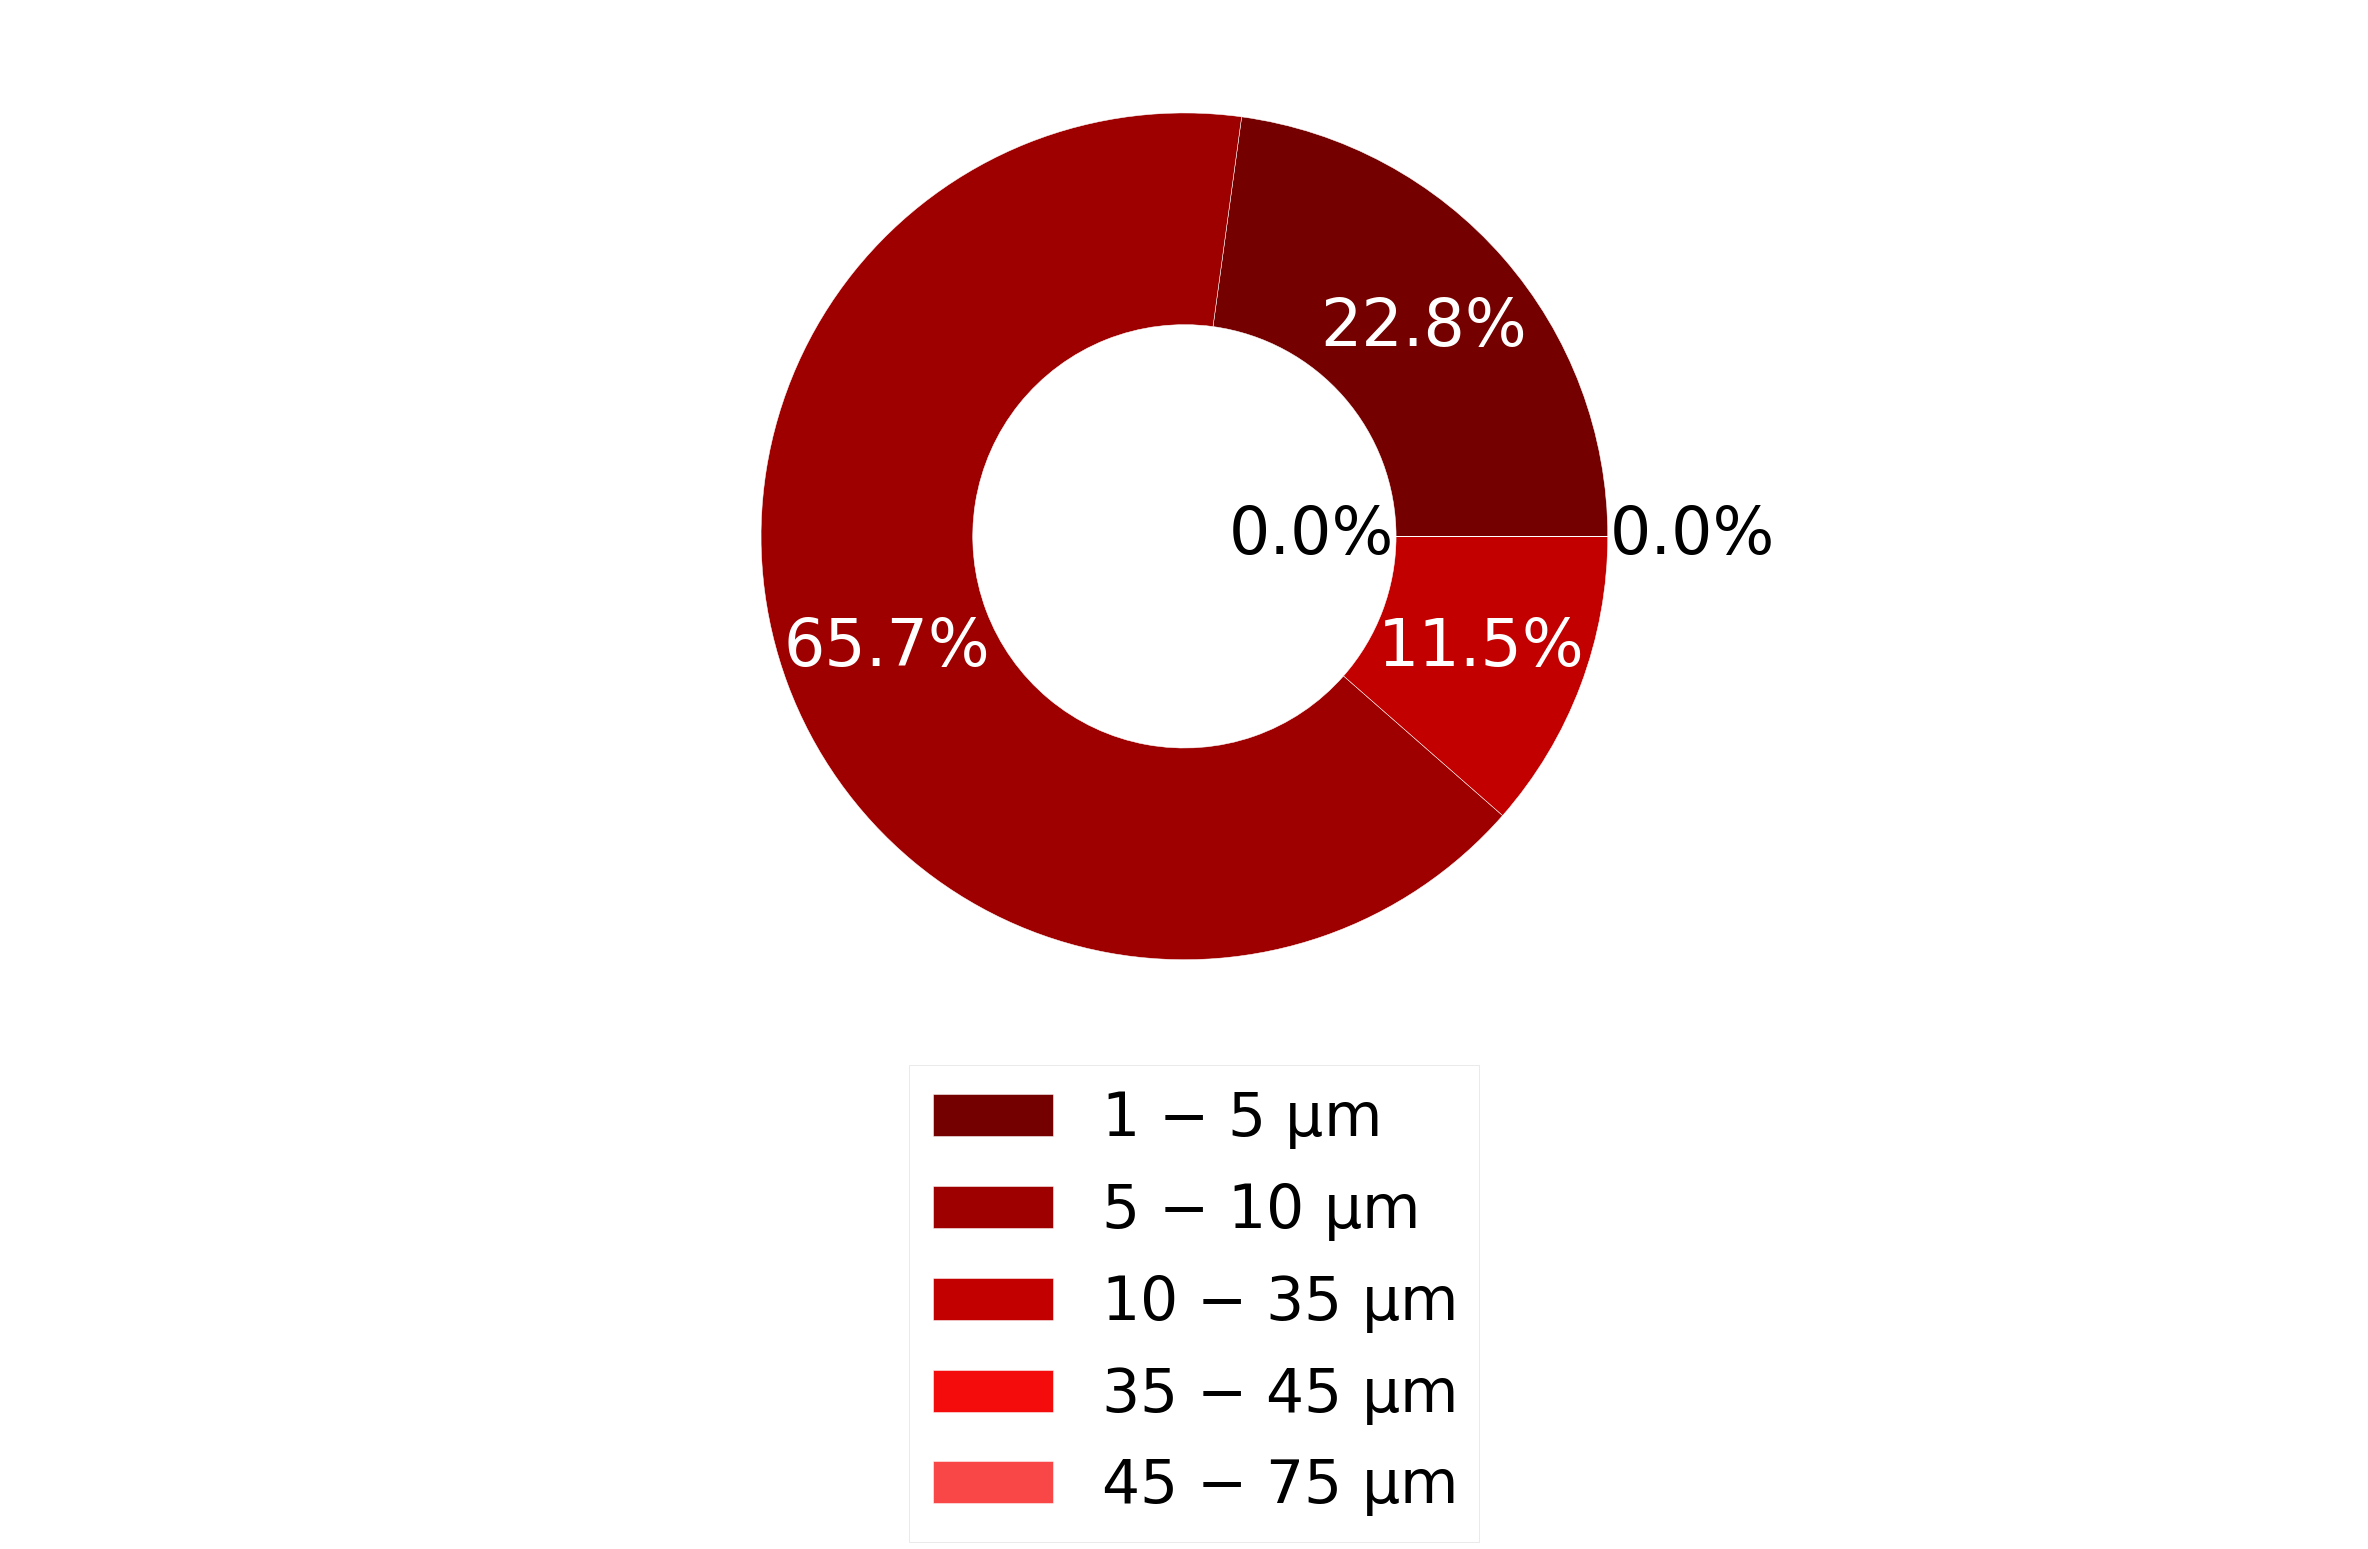

In [176]:
create_pie_chart('PCL_cl', 
                 './data/samples',
                 './data/samples/results',
                 [(1,5), (5,10), (10,35), (35,45), (45,75)],
                 color_name='PCL_wa',
                 title='diameter',
                 type='d', 
                 unit_scale=1.8,
                 measure_type='Non_vol',
                 legend_fontsize=60,
                 chart_fontsize=65,
                 zebra_color=(True,3),
                 lang='en')

Max: 35.9992599487, Min: 0.0
Num of particles: 1160367
1-5: 186991
5-10: 808892
10-35: 164483
35-45: 1
45-75: 0


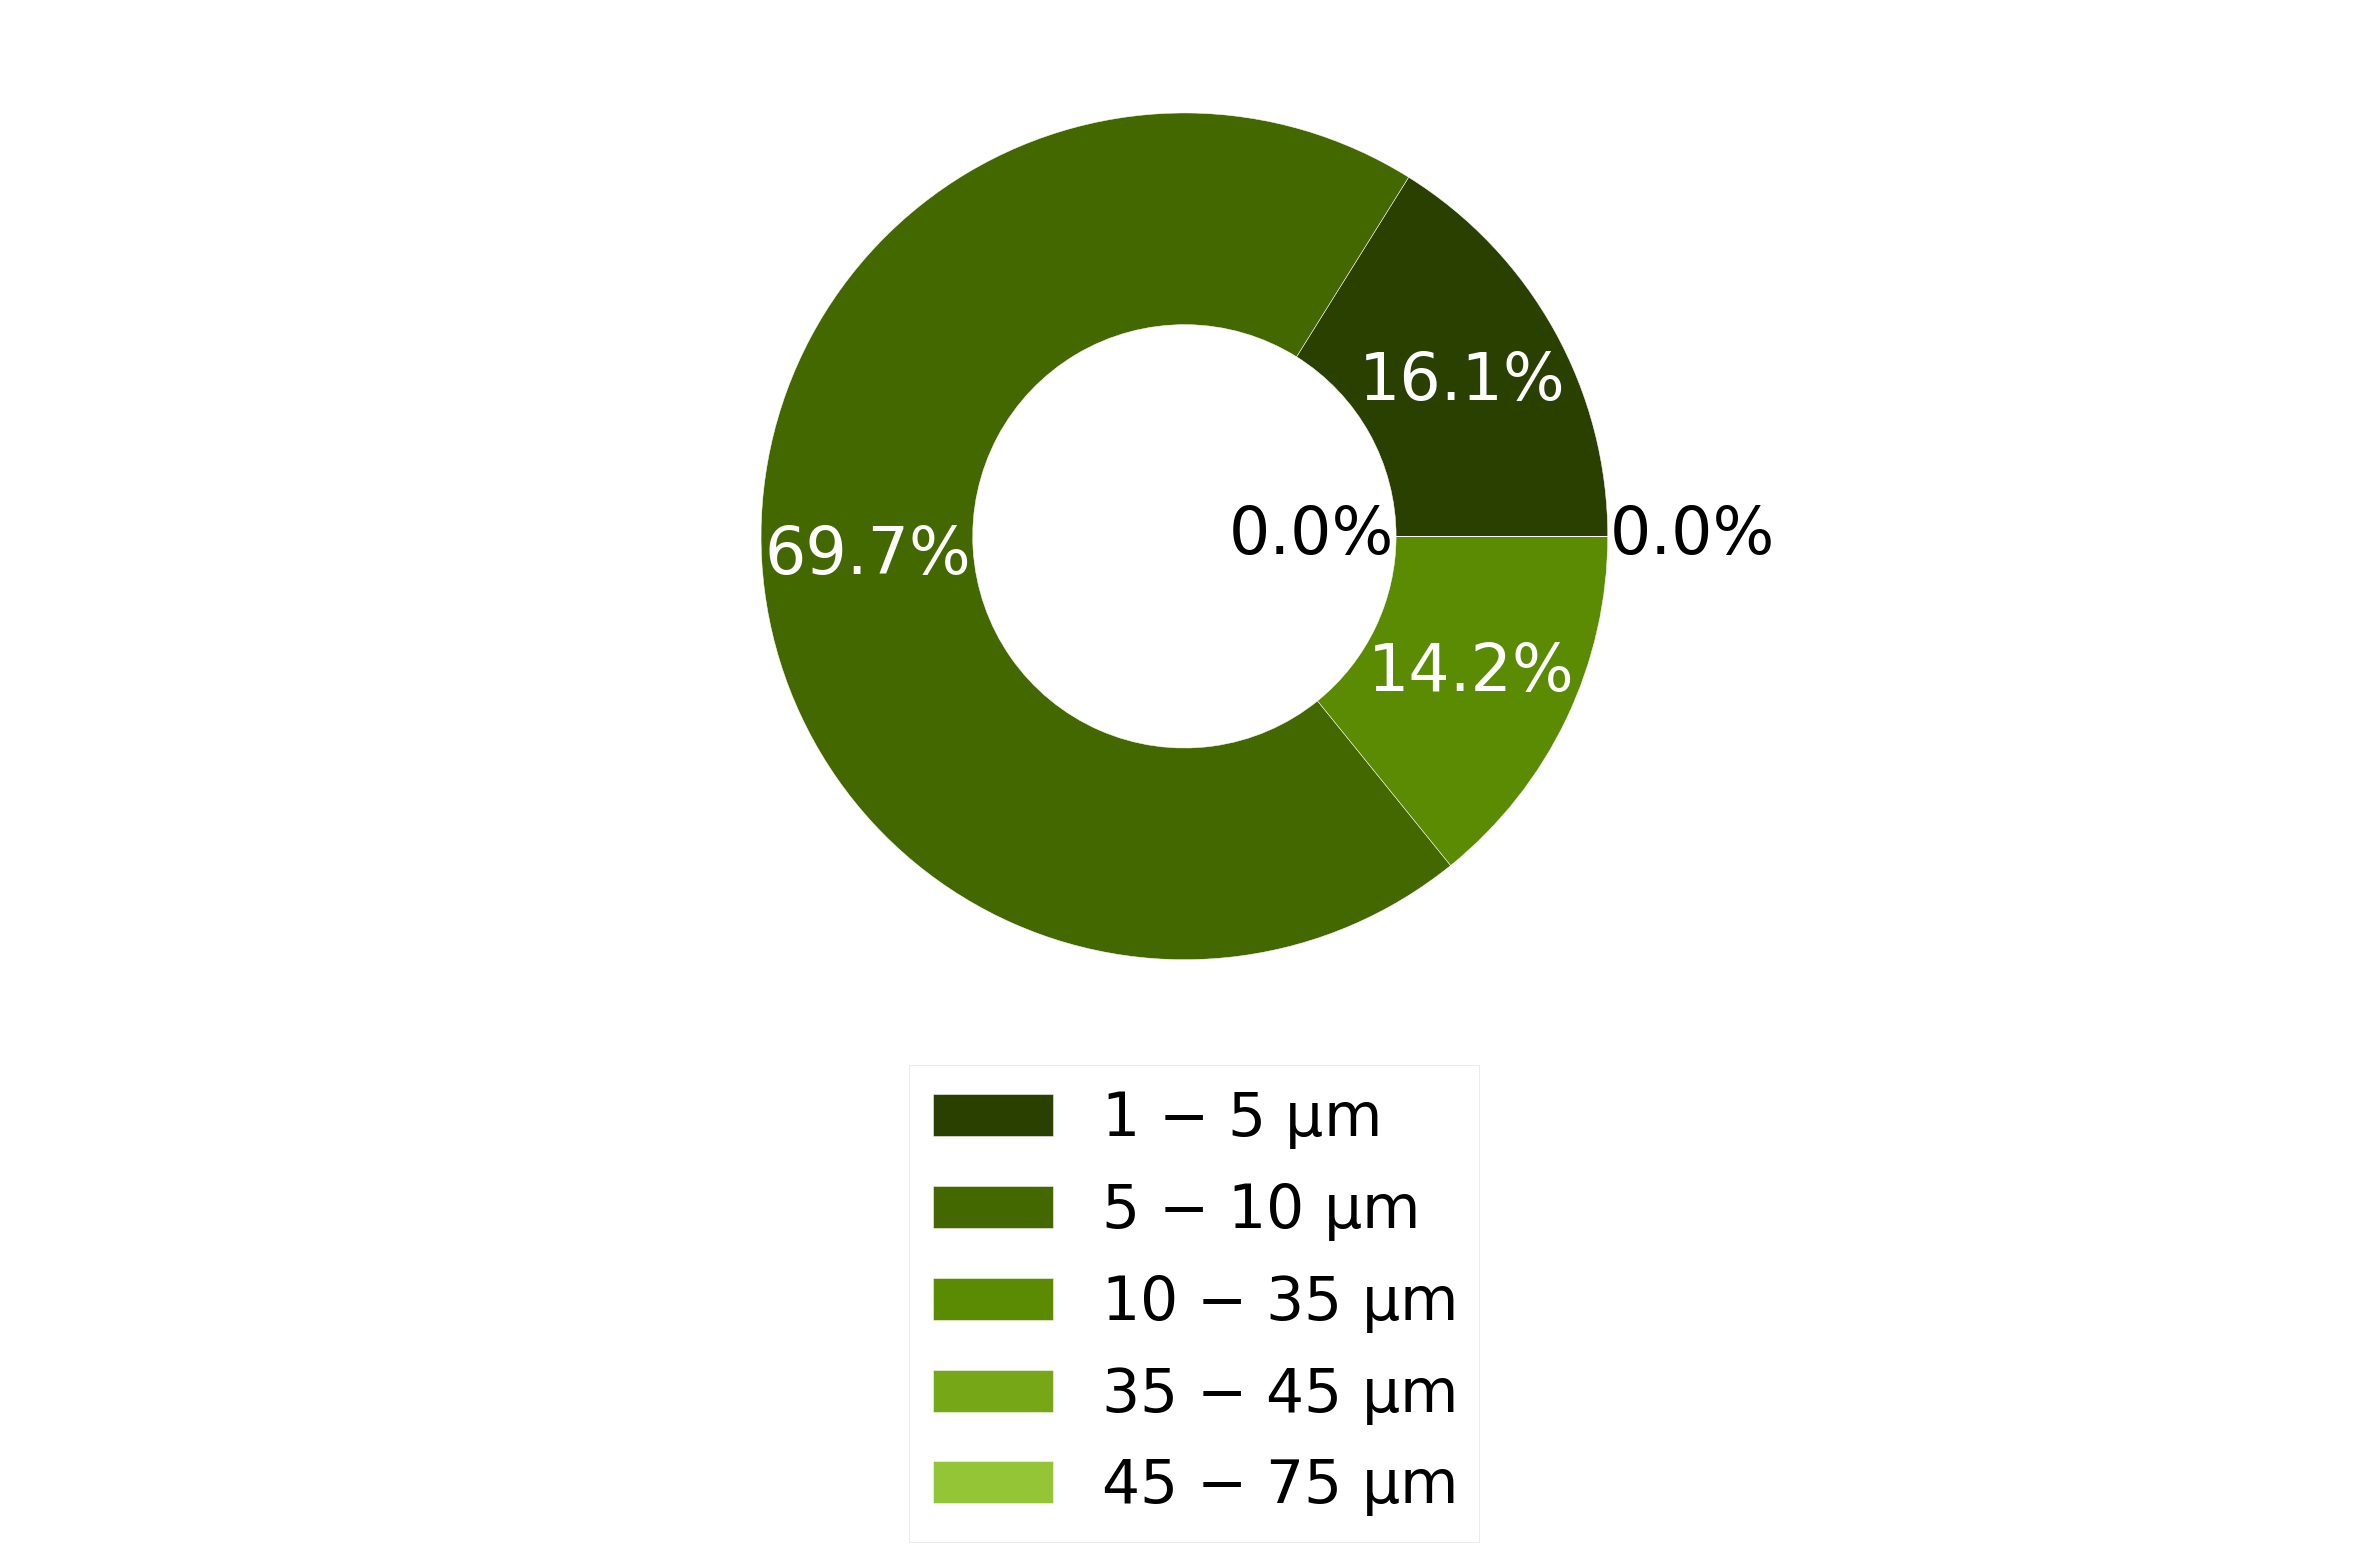

In [177]:
create_pie_chart('PCL_wa', 
                 './data/samples',
                 './data/samples/results',
                 [(1,5), (5,10), (10,35), (35,45), (45,75)],
                 #[(1,10), (10,25), (25,35), (35,45), (45,75)],
                 color_name='PCL_cl',
                 title='diameter',
                 type='d', 
                 unit_scale=1.8,
                 measure_type='Non_vol',
                 legend_fontsize=60,
                 chart_fontsize=65,
                 zebra_color=(True,3),
                 lang='en')

# Orientation analysis

# SEM diameters

Max: 6.621, Min: 2.899
Num of particles: 252
1-3: 3
3-5: 216
5-10: 33
10-15: 0


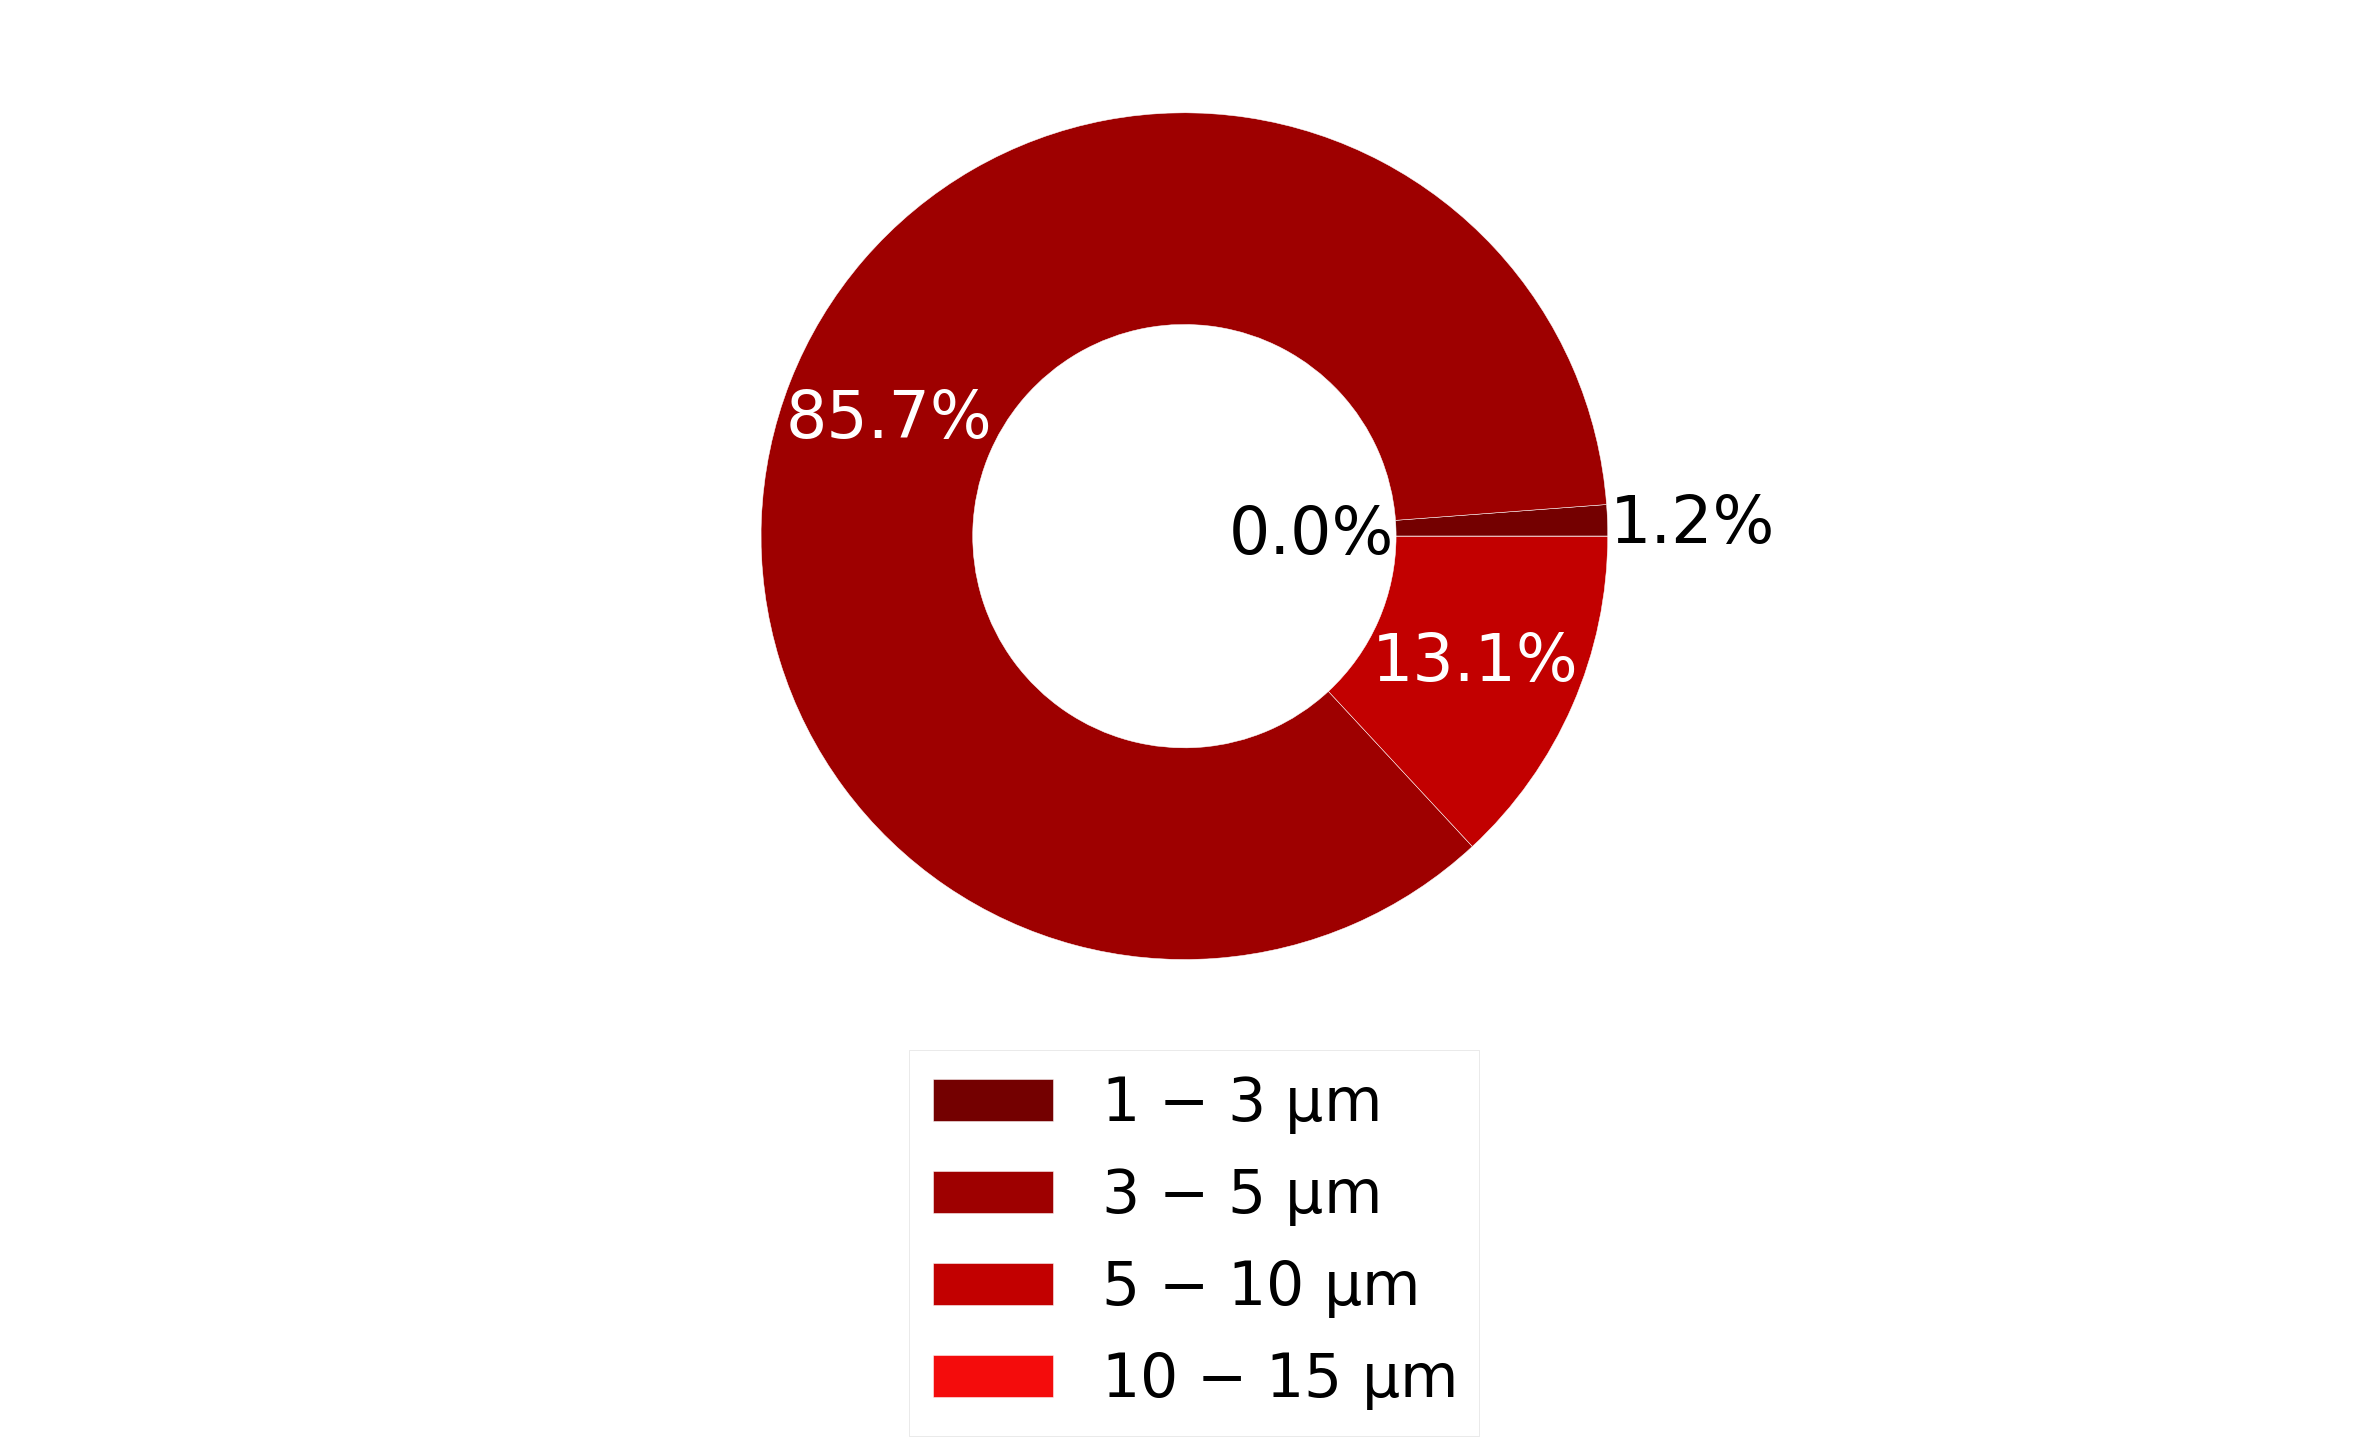

In [140]:
create_pie_chart_plain('PCL_wa', 
                         samples_configs['PCL_wa'][~samples_configs['PCL_wa'].isnull()], 
                         './data/samples/results',
                         [(1,3), (3,5), (5,10), (10,15)],
                         #[(1,10), (10,25), (25,35), (35,45), (45,75)],
                         color_name='PCL_wa',
                         title='diameter_SEM',
                         type='d', 
                         measure_type='Non_vol',
                         legend_fontsize=60,
                         chart_fontsize=65,
                         zebra_color_idxs=[1,2],
                         lang='en')

Max: 7.4, Min: 2.012
Num of particles: 254
1-3: 95
3-5: 80
5-10: 79
10-15: 0


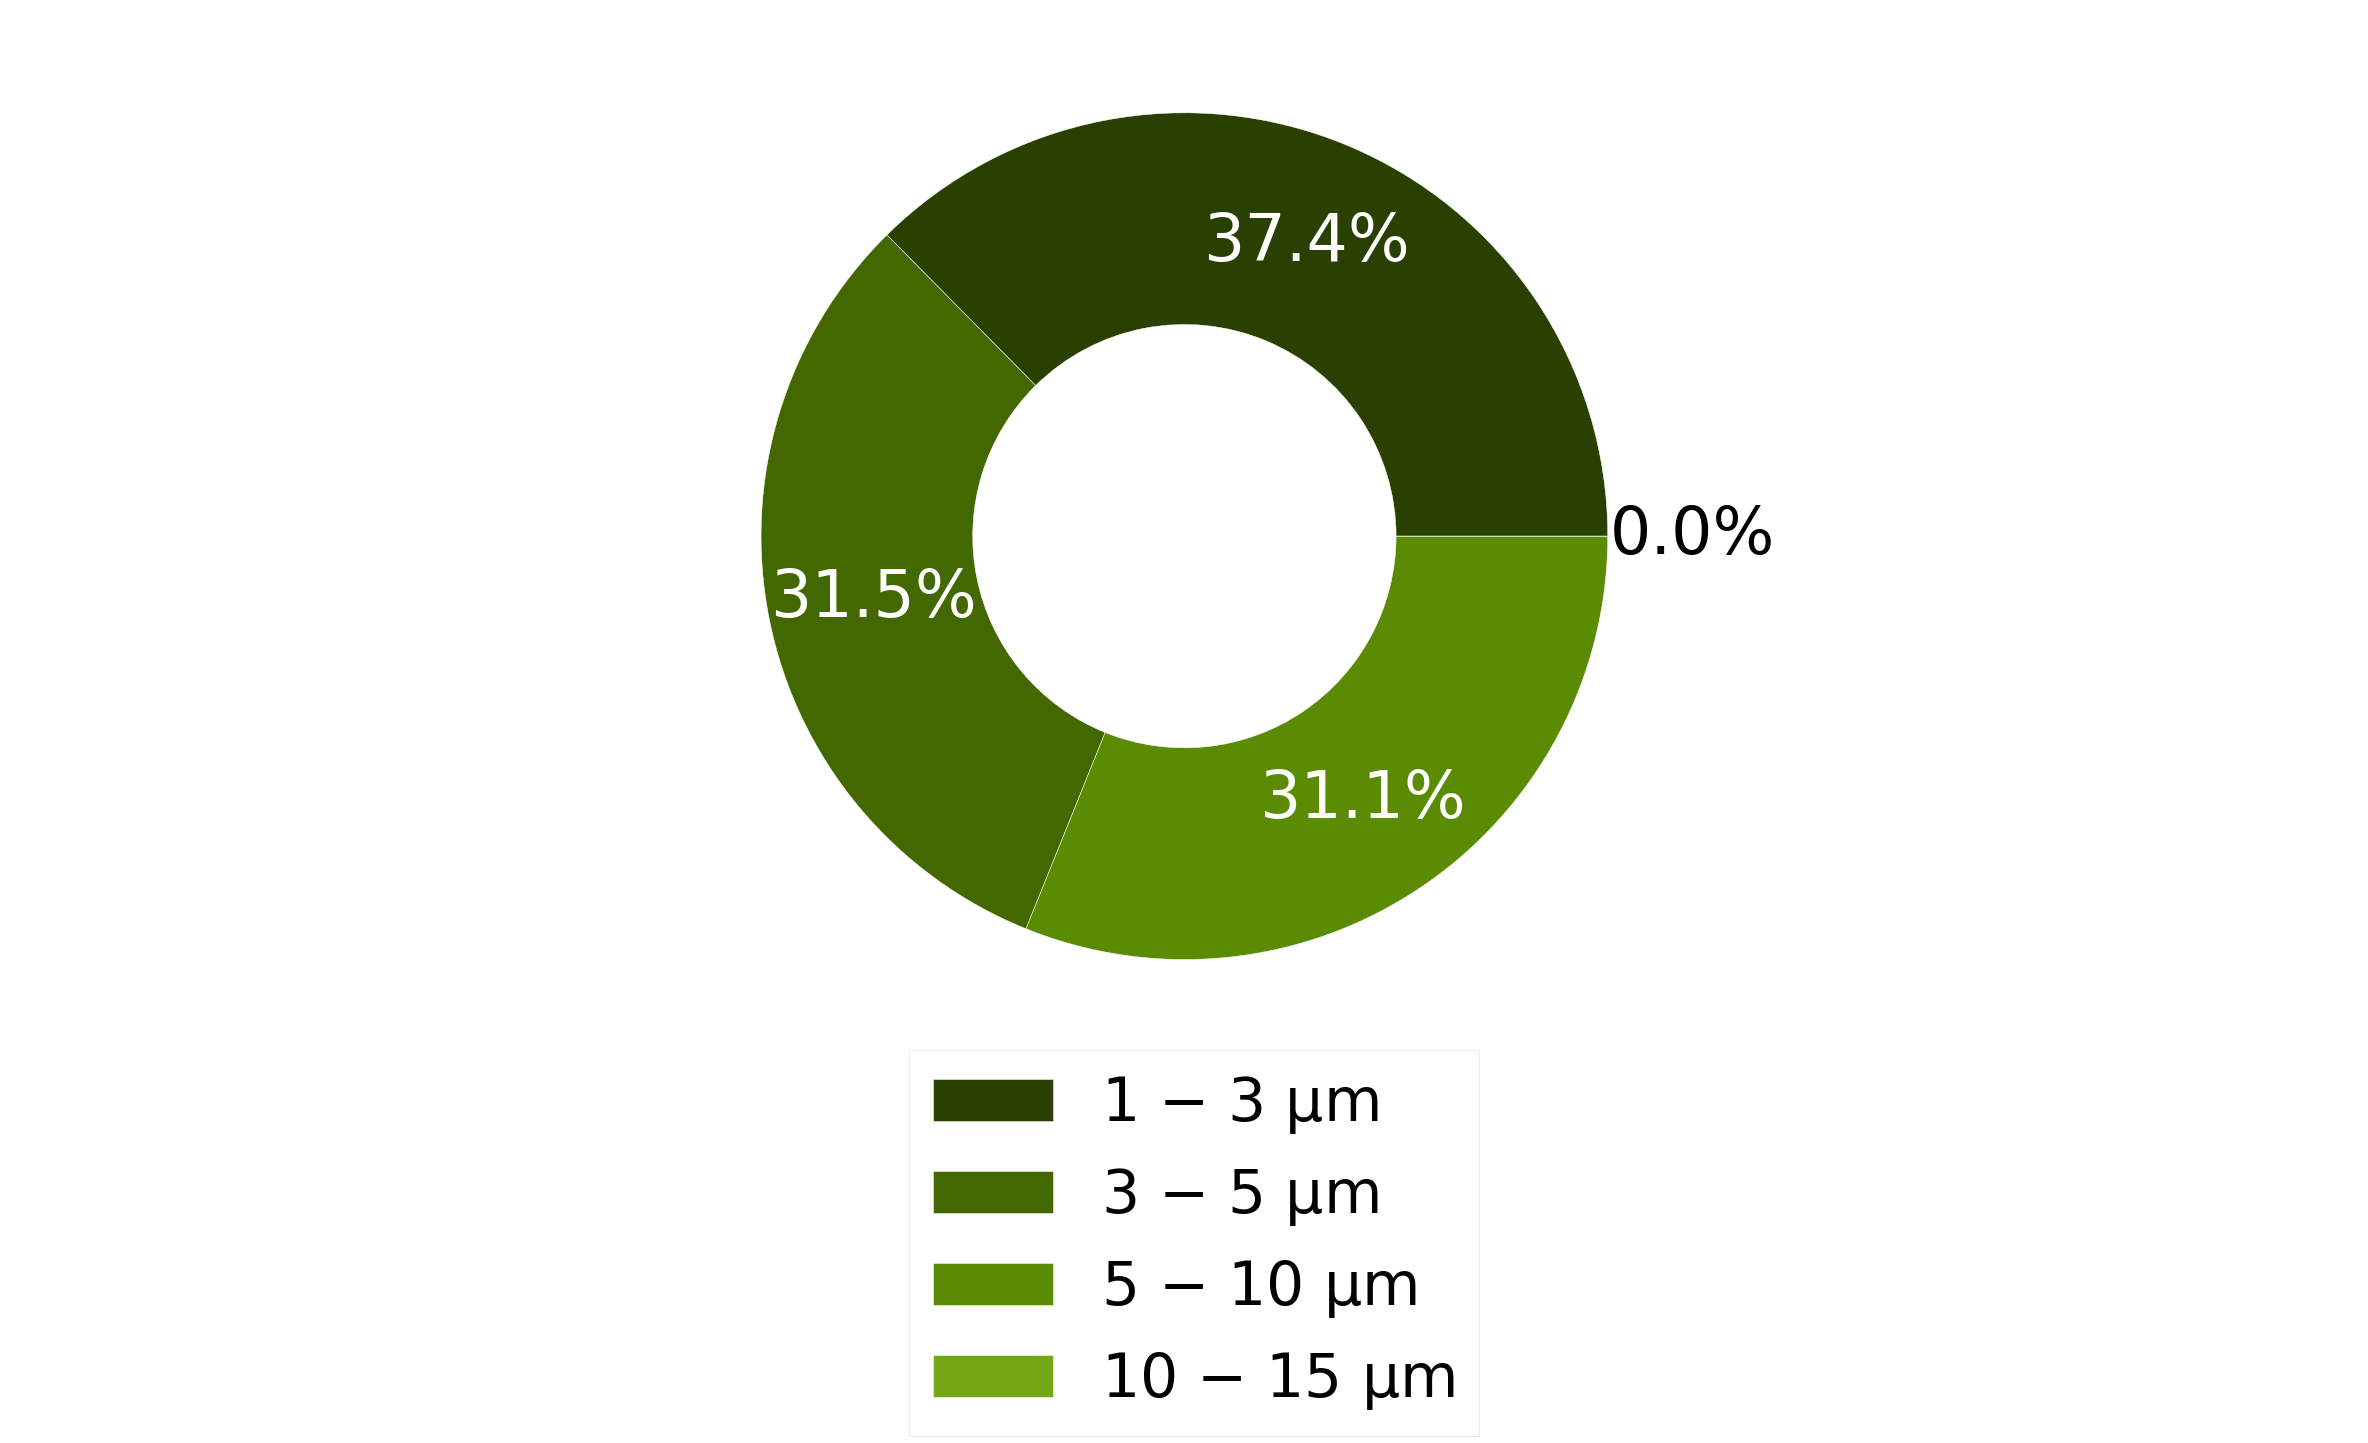

In [141]:
create_pie_chart_plain('PCL_cl', 
                         samples_configs['PCL_cl'][~samples_configs['PCL_cl'].isnull()], 
                         './data/samples/results',
                         [(1,3), (3,5), (5,10), (10,15)], 
                         #[(1,10), (10,25), (25,35), (35,45), (45,75)],
                         color_name='PCL_cl',
                         title='diameter_SEM',
                         type='d', 
                         measure_type='Non_vol',
                         legend_fontsize=60,
                         chart_fontsize=65,
                         zebra_color_idxs=[0,1,2],
                         lang='en')

Max: 14.415, Min: 0.393
Num of particles: 162
1-3: 91
3-5: 31
5-10: 7
10-15: 33


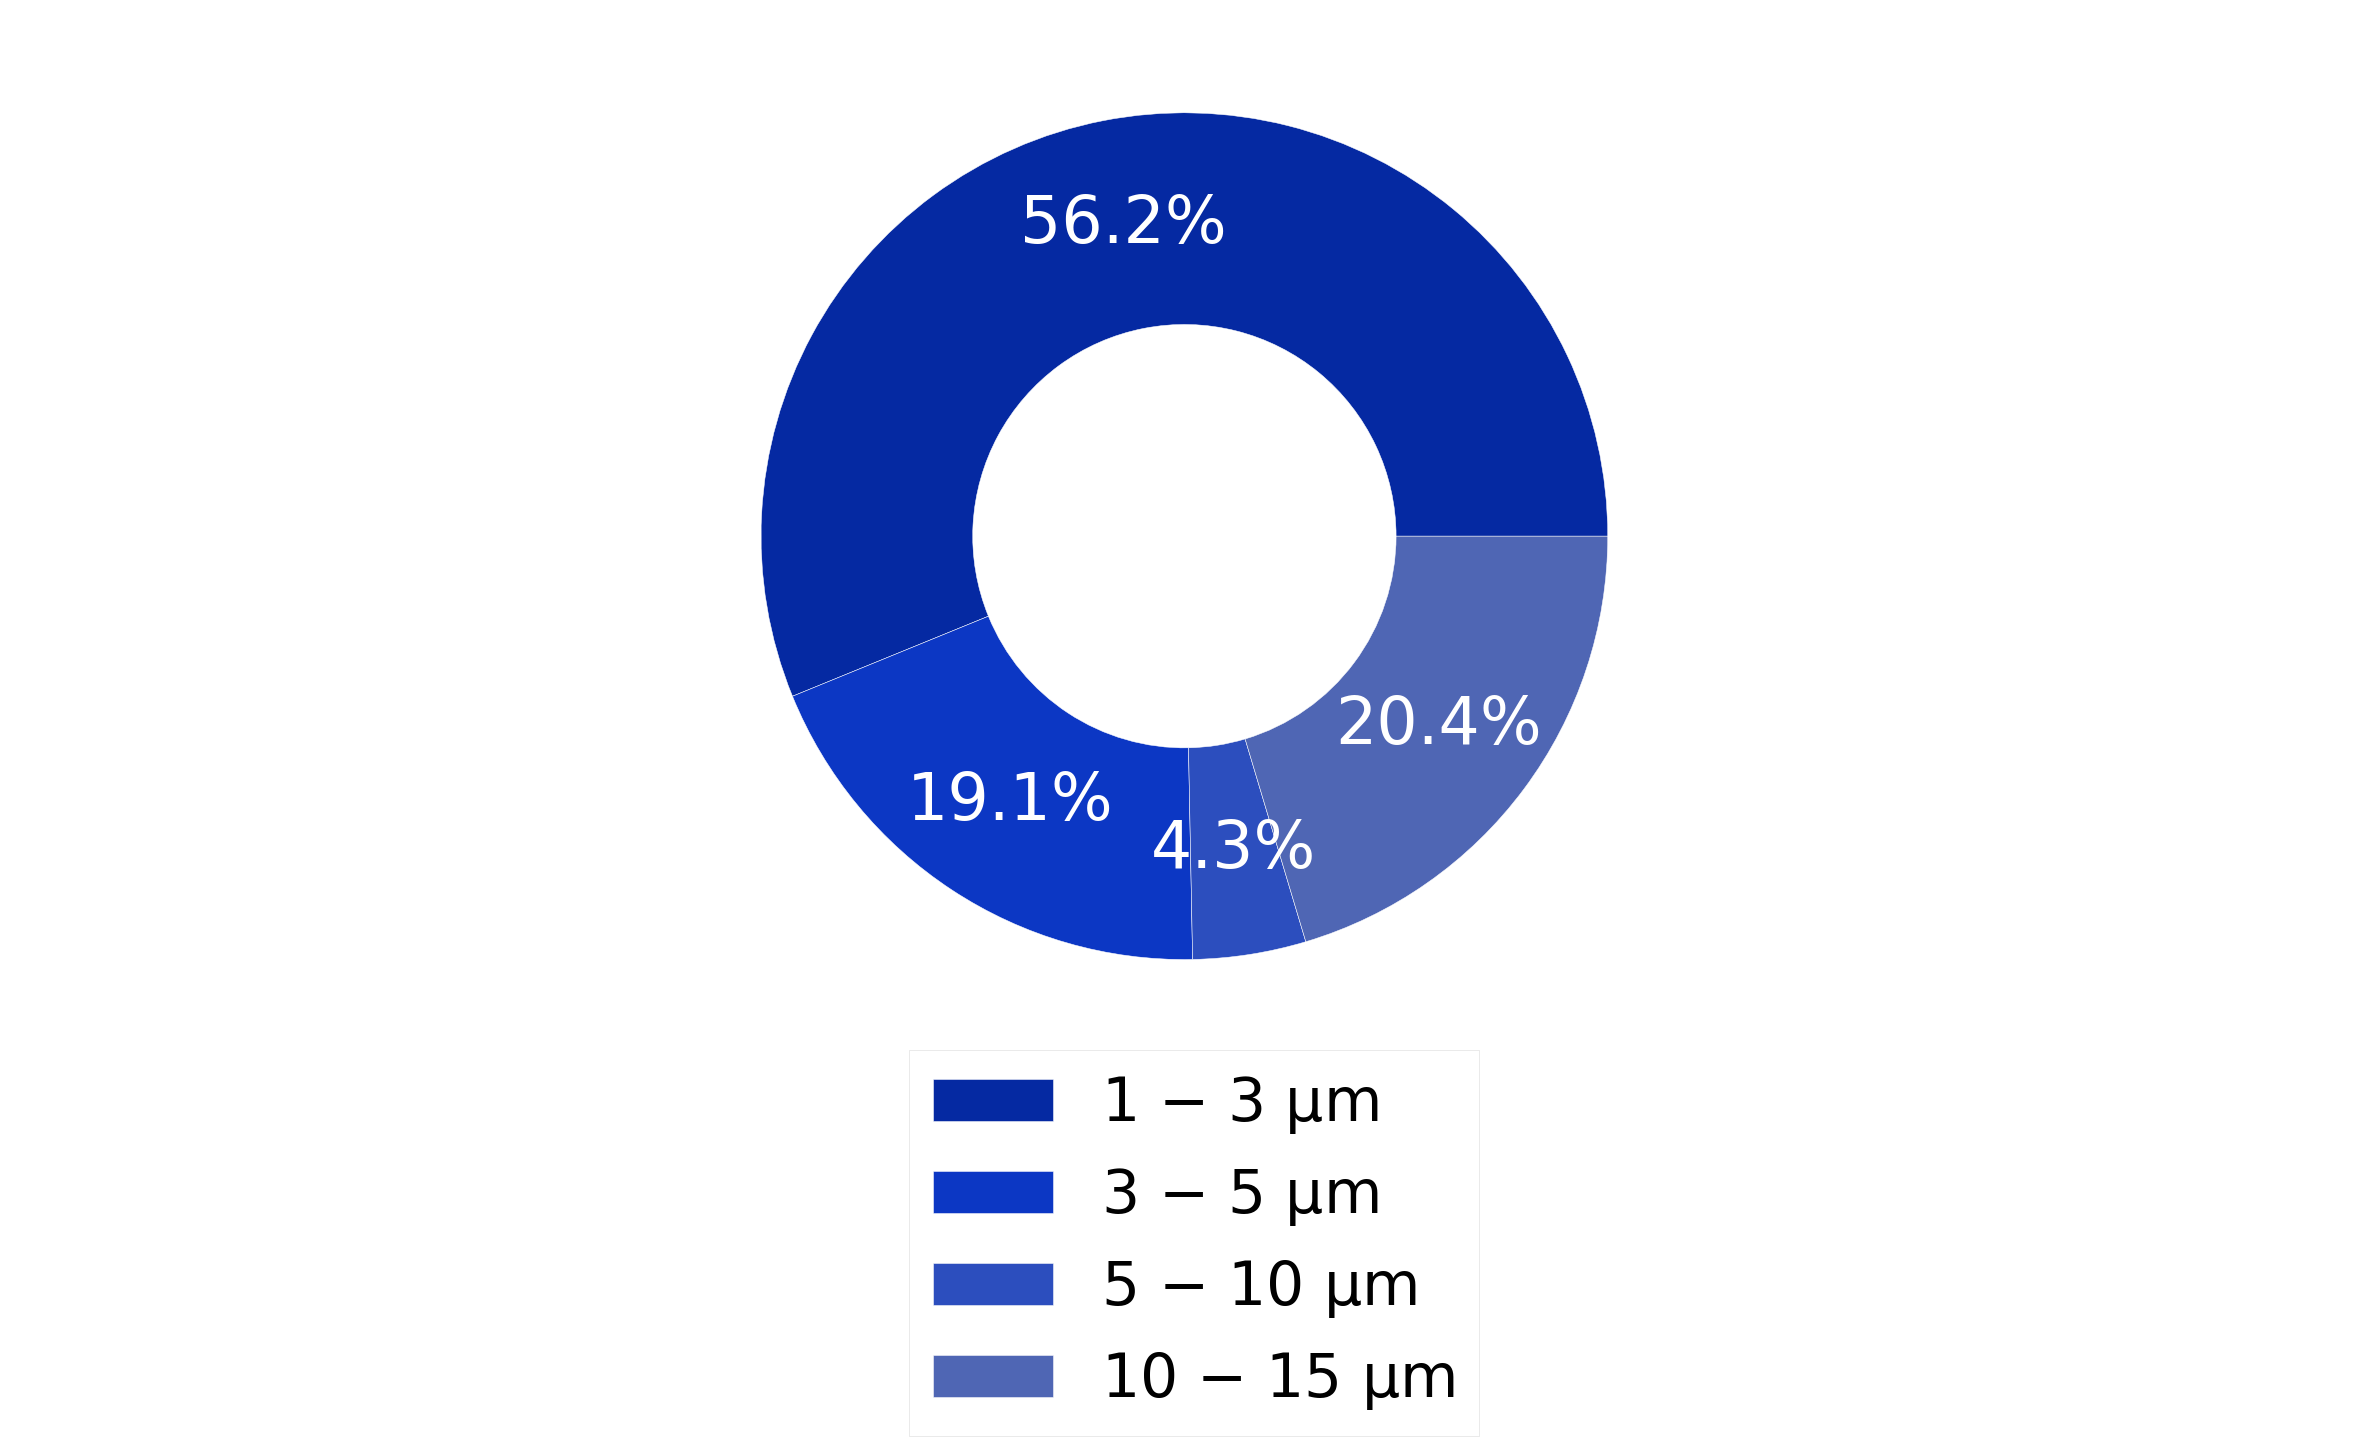

In [142]:
create_pie_chart_plain('PCL_SiHA_cl', 
                         samples_configs['PCL_SiHA_cl'][~samples_configs['PCL_SiHA_cl'].isnull()], 
                         './data/samples/results',
                         [(1,3), (3,5), (5,10), (10,15)],
                         #[(1,10), (10,25), (25,35), (35,45), (45,75)],
                         color_name='PCL_SiHA_cl',
                         title='diameter_SEM',
                         type='d', 
                         measure_type='Non_vol',
                         legend_fontsize=60,
                         chart_fontsize=65,
                         zebra_color_idxs=[0,1,2,3],
                         lang='en')

Max: 4.956, Min: 0.509
Num of particles: 266
1-3: 176
3-5: 90
5-10: 0
10-15: 0


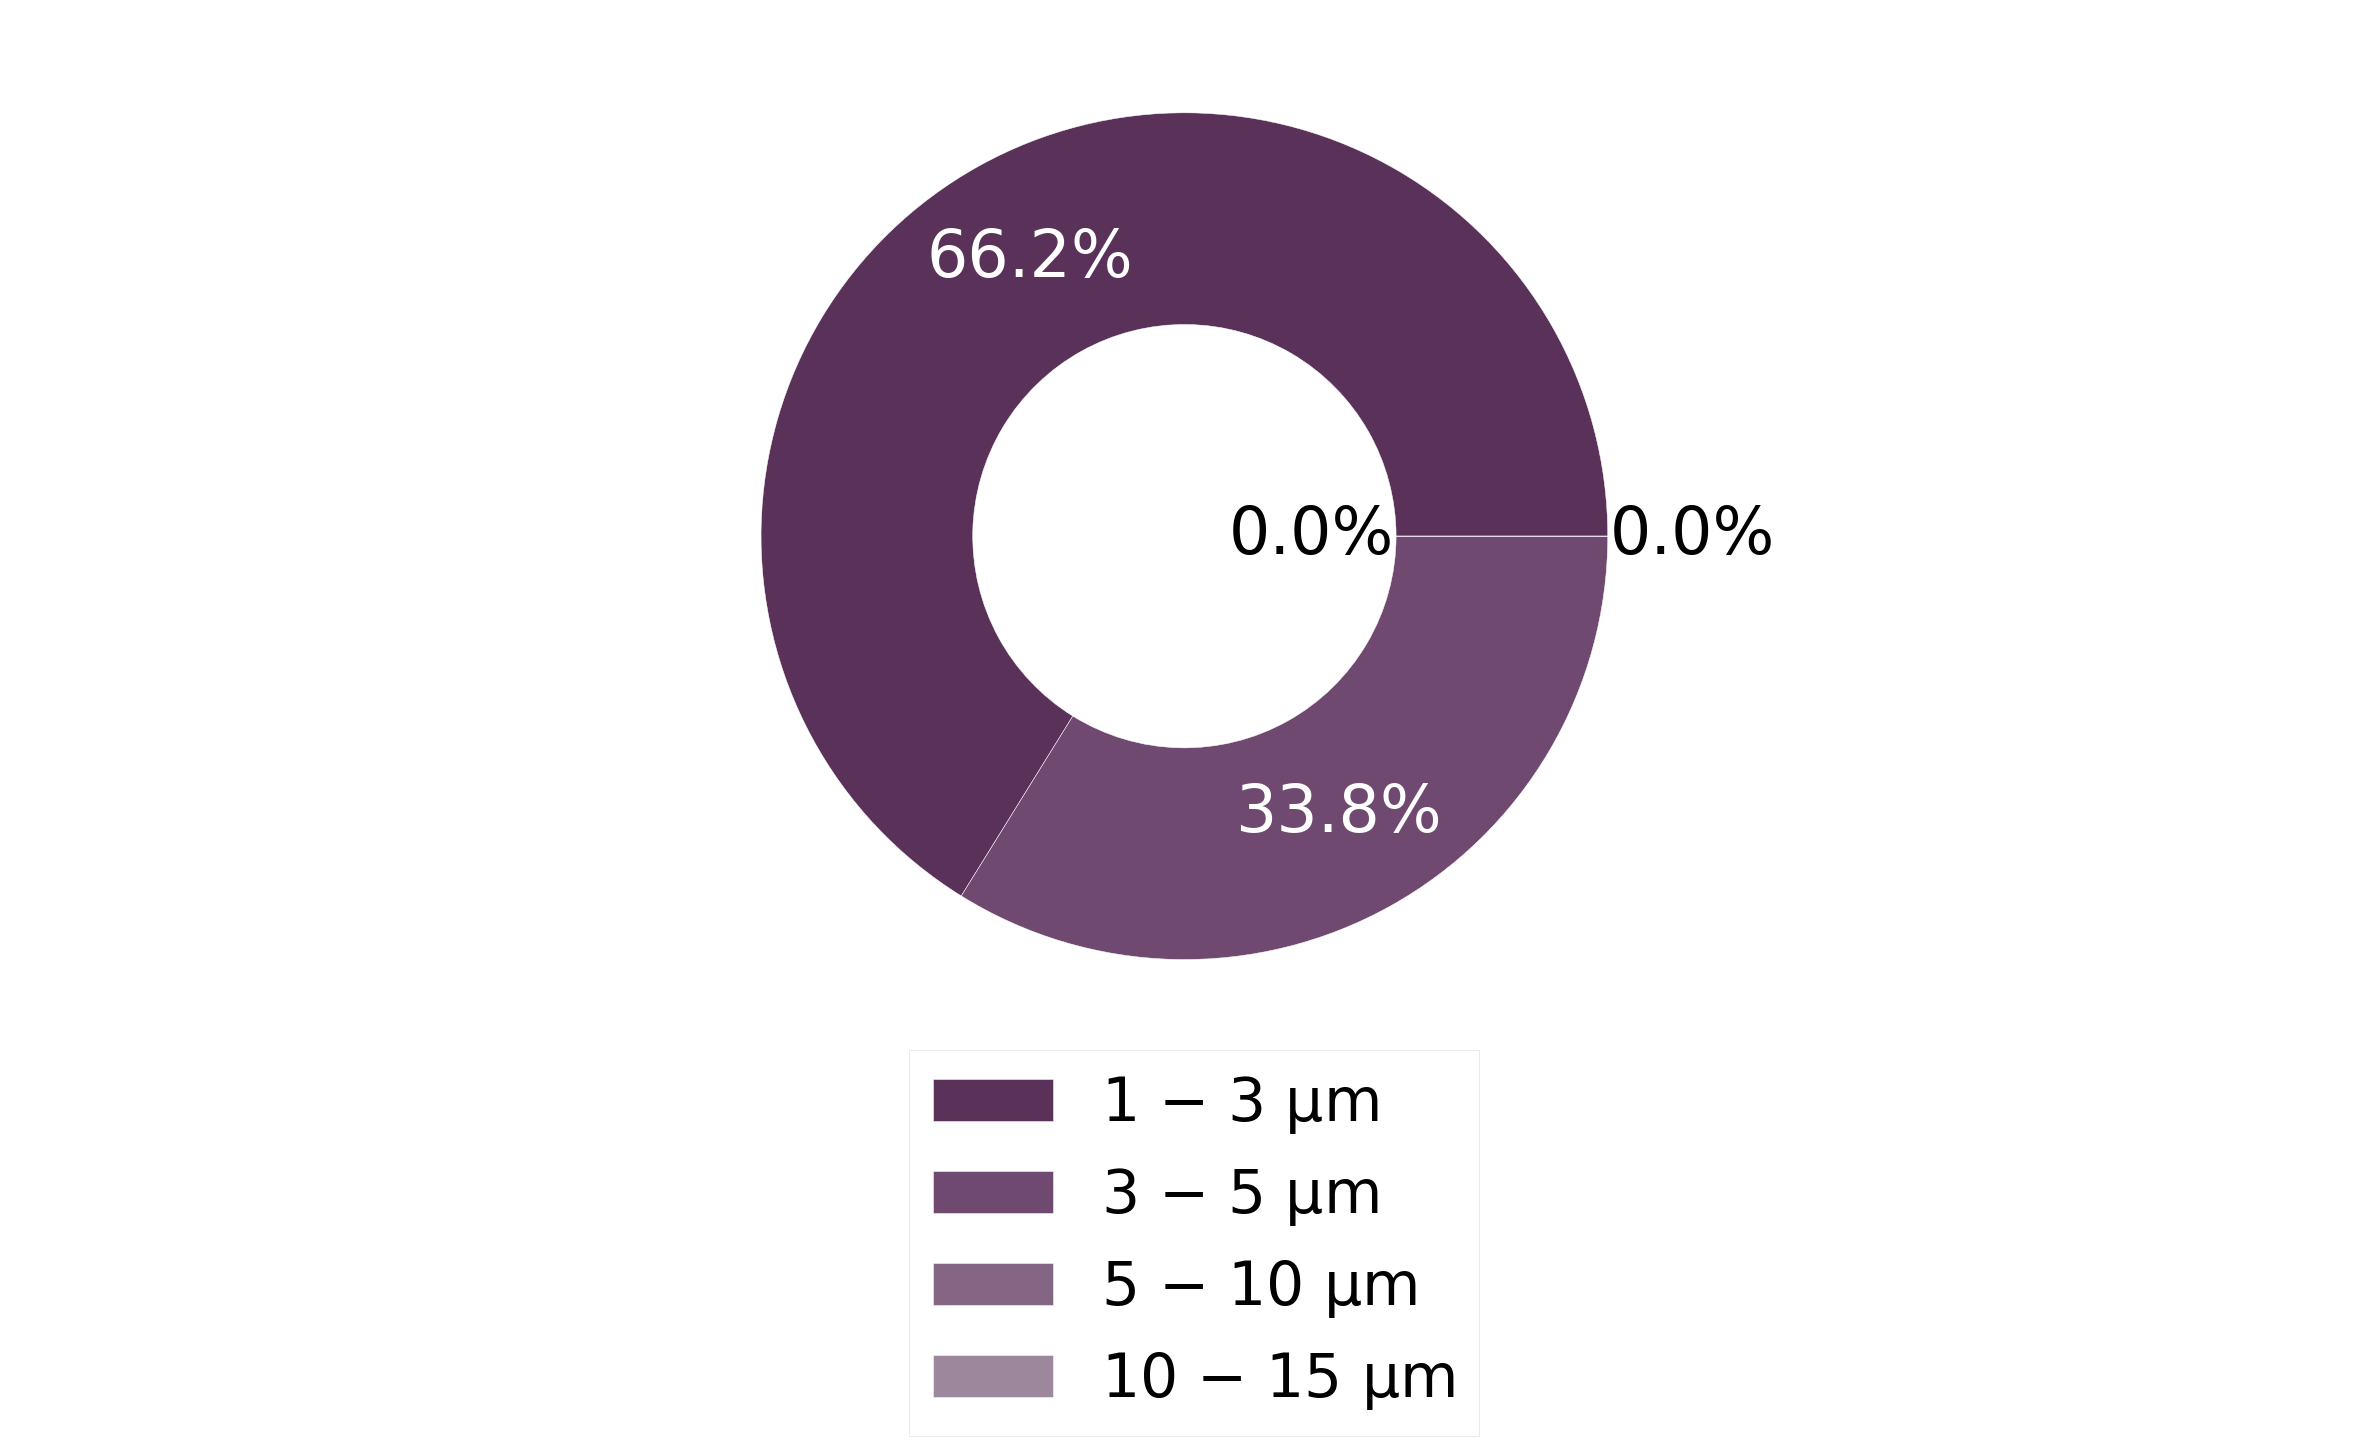

In [143]:
create_pie_chart_plain('PCL_SiHA_wa', 
                         samples_configs['PCL_SiHA_wa'][~samples_configs['PCL_SiHA_wa'].isnull()], 
                         './data/samples/results',
                         [(1,3), (3,5), (5,10), (10,15)], 
                         #[(1,10), (10,25), (25,35), (35,45), (45,75)],
                         color_name='PCL_SiHA_wa',
                         title='diameter_SEM',
                         type='d', 
                         measure_type='Non_vol',
                         legend_fontsize=60,
                         chart_fontsize=65,
                         zebra_color_idxs=[0,1],
                         lang='en')

# SEM dimater hists

0.898


(<matplotlib.figure.Figure at 0x7f75a11af2d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f75a2354290>)

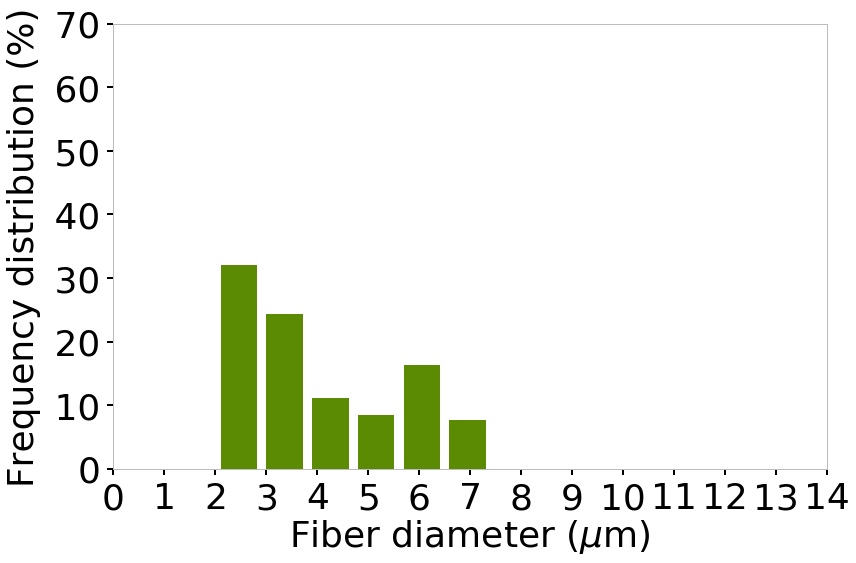

In [87]:
plot_histogram_fig(samples_configs['PCL_cl'][~samples_configs['PCL_cl'].isnull()].values[:250],
                   6,
                   np.arange(15).astype(np.int32),
                   COLORS['PCL_cl'][2],
                   norm=False,
                   in_percent=True,
                   yticks=np.linspace(0, 0.7, num=8),
                   #ytick_labels=np.linspace(0,100,num=11).astype(np.int32),
                   xlabel='Fiber diameter ($\mu$m)',
                   ylabel='Frequency distribution (%)',
                   yticks_fontsize=36,
                   xticks_fontsize=36,
                   labels_fontsize=36,
                   name='PCL_cl_SEM_diameter_hist',
                   output_dir='./data/samples/results/PCL_cl')

0.86425


/home/ws/ih7618/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/ws/ih7618/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/ws/ih7618/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/ws/ih7618/anaconda2/lib/python2.7/site-packages/sklearn/util

(<matplotlib.figure.Figure at 0x7f75a1178d10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f75a0fce910>)

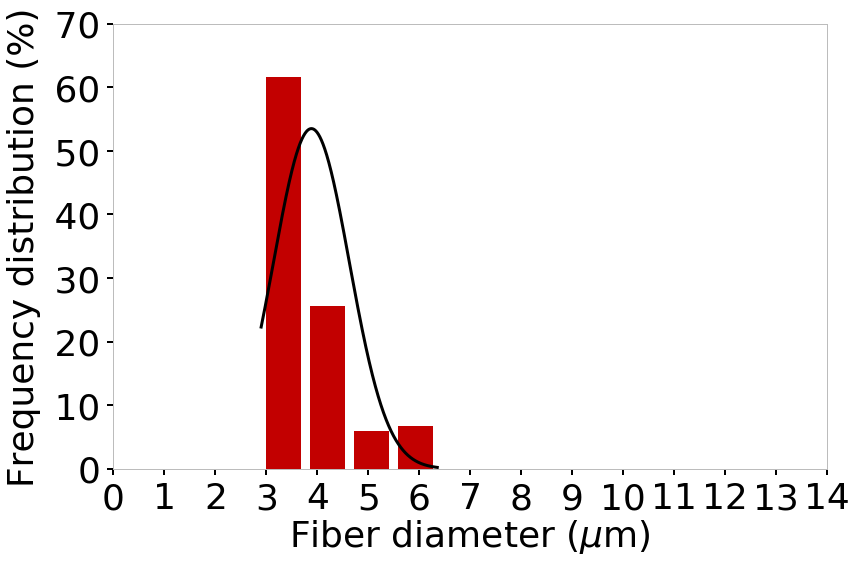

In [88]:
plot_histogram_gmm_fig(samples_configs['PCL_wa'][~samples_configs['PCL_wa'].isnull()].values[:250],
                       4,
                       np.arange(15).astype(np.int32),
                       COLORS['PCL_wa'][2],
                       n_gmm_components=1,
                       in_percent=True,
                       yticks=np.linspace(0, 0.7, num=8),
                       xlabel='Fiber diameter ($\mu$m)',
                       ylabel='Frequency distribution (%)',
                       yticks_fontsize=36,
                       xticks_fontsize=36,
                       labels_fontsize=36,
                       name='PCL_wa_SEM_diameter_hist',
                       output_dir='./data/samples/results/PCL_wa')

0.86425


(<matplotlib.figure.Figure at 0x7f75a1979450>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f75a0f11210>)

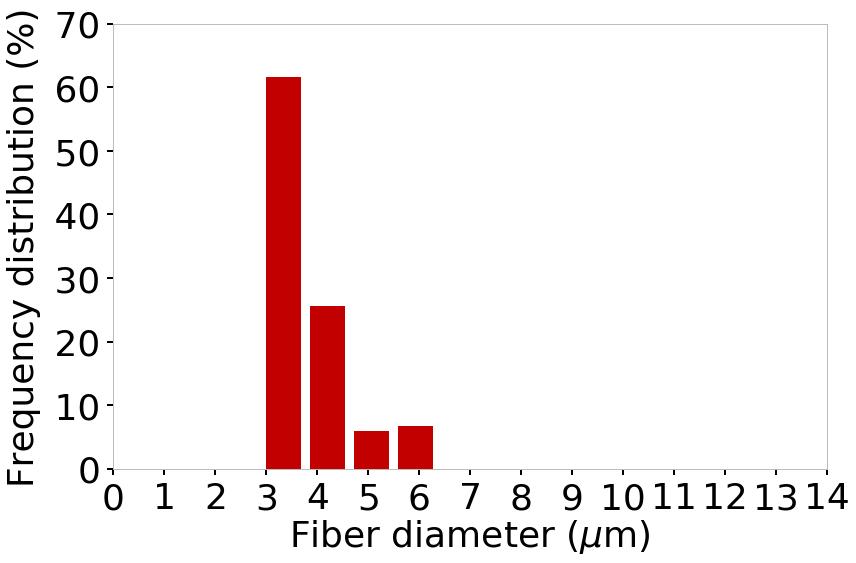

In [89]:
plot_histogram_fig(samples_configs['PCL_wa'][~samples_configs['PCL_wa'].isnull()].values[:250],
                   4,
                   np.arange(15).astype(np.int32),
                   COLORS['PCL_wa'][2],
                   norm=False,
                   in_percent=True,
                   yticks=np.linspace(0, 0.7, num=8),
                   xlabel='Fiber diameter ($\mu$m)',
                   ylabel='Frequency distribution (%)',
                   yticks_fontsize=36,
                   xticks_fontsize=36,
                   labels_fontsize=36,
                   name='PCL_wa_SEM_diameter_hist',
                   output_dir='./data/samples/results/PCL_wa')

0.844


/home/ws/ih7618/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/ws/ih7618/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/ws/ih7618/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/ws/ih7618/anaconda2/lib/python2.7/site-packages/sklearn/util

(<matplotlib.figure.Figure at 0x7f75a3e4e290>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f75a0d6a090>)

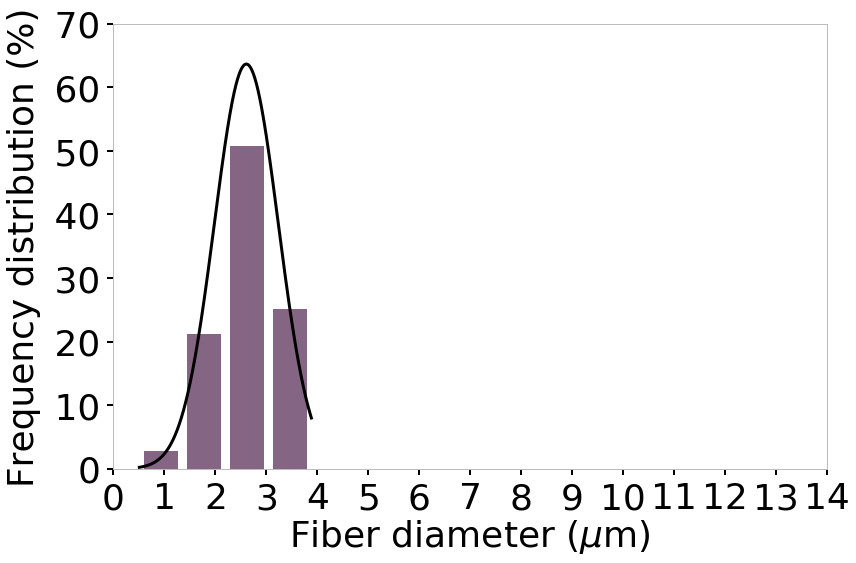

In [90]:
plot_histogram_gmm_fig(samples_configs['PCL_SiHA_wa'][~samples_configs['PCL_SiHA_wa'].isnull()].values[:250],
                       4,
                       np.arange(15).astype(np.int32),
                       COLORS['PCL_SiHA_wa'][2],
                       n_gmm_components=1,
                       in_percent=True,
                       yticks=np.linspace(0, 0.7, num=8),
                       xlabel='Fiber diameter ($\mu$m)',
                       ylabel='Frequency distribution (%)',
                       yticks_fontsize=36,
                       xticks_fontsize=36,
                       labels_fontsize=36,
                       name='PCL_SiHA_wa_SEM_diameter_hist',
                       output_dir='./data/samples/results/PCL_SiHA_wa')

0.844


(<matplotlib.figure.Figure at 0x7f75a157a8d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f75a2132610>)

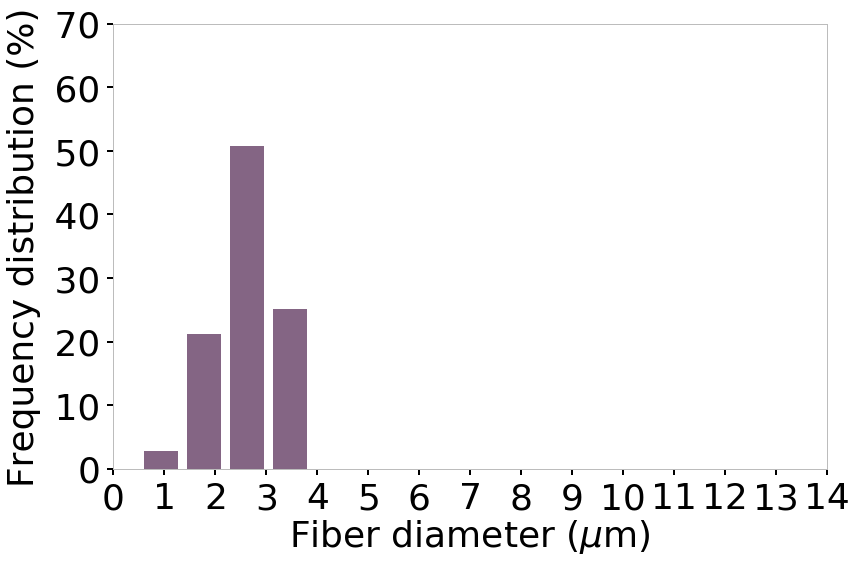

In [91]:
plot_histogram_fig(samples_configs['PCL_SiHA_wa'][~samples_configs['PCL_SiHA_wa'].isnull()].values[:250],
                   4,
                   np.arange(15).astype(np.int32),
                   COLORS['PCL_SiHA_wa'][2],
                   norm=False,
                   in_percent=True,
                   yticks=np.linspace(0, 0.7, num=8),
                   xlabel='Fiber diameter ($\mu$m)',
                   ylabel='Frequency distribution (%)',
                   yticks_fontsize=36,
                   xticks_fontsize=36,
                   labels_fontsize=36,
                   name='PCL_SiHA_wa_SEM_diameter_hist',
                   output_dir='./data/samples/results/PCL_SiHA_wa')

0.961142857143


/home/ws/ih7618/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/ws/ih7618/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/ws/ih7618/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/ws/ih7618/anaconda2/lib/python2.7/site-packages/sklearn/util

(<matplotlib.figure.Figure at 0x7f75a0cbf950>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f75a0baa090>)

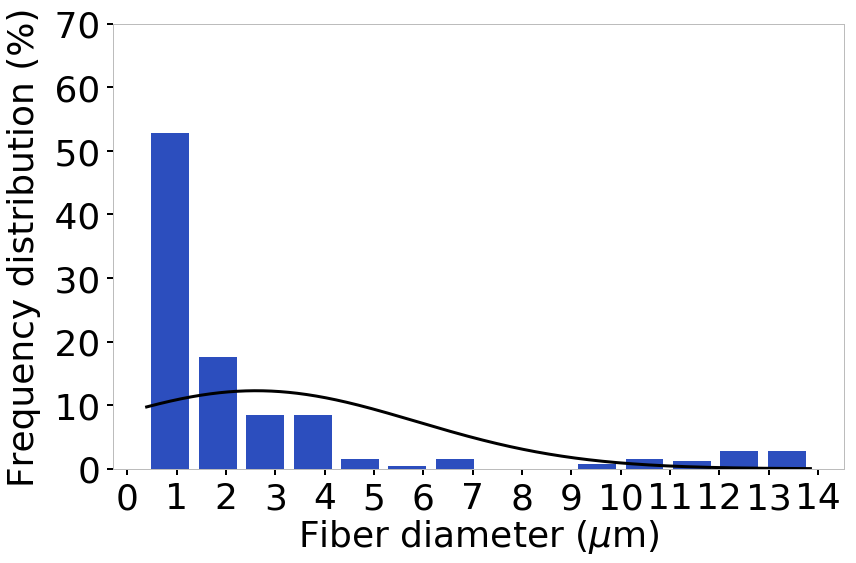

In [92]:
plot_histogram_gmm_fig(samples_configs['PCL_SiHA_cl'][~samples_configs['PCL_SiHA_cl'].isnull()].values[:250],
                       14,
                       np.arange(15).astype(np.int32),
                       COLORS['PCL_SiHA_cl'][2],
                       n_gmm_components=1,
                       in_percent=True,
                       yticks=np.linspace(0, 0.7, num=8),
                       xlabel='Fiber diameter ($\mu$m)',
                       ylabel='Frequency distribution (%)',
                       yticks_fontsize=36,
                       xticks_fontsize=36,
                       labels_fontsize=36,
                       name='PCL_SiHA_cl_SEM_diameter_hist',
                       output_dir='./data/samples/results/PCL_SiHA_cl')

0.961142857143


(<matplotlib.figure.Figure at 0x7f75a0d748d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f75a0b4c210>)

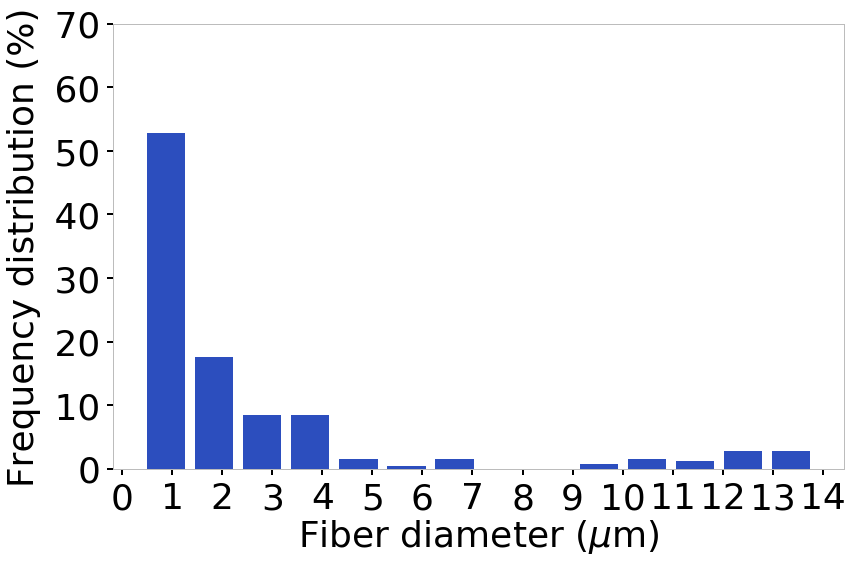

In [93]:
plot_histogram_fig(samples_configs['PCL_SiHA_cl'][~samples_configs['PCL_SiHA_cl'].isnull()].values[:250],
                   14,
                   np.arange(15).astype(np.int32),
                   COLORS['PCL_SiHA_cl'][2],
                   norm=False,
                   in_percent=True,
                   yticks=np.linspace(0, 0.7, num=8),
                   xlabel='Fiber diameter ($\mu$m)',
                   ylabel='Frequency distribution (%)',
                   yticks_fontsize=36,
                   xticks_fontsize=36,
                   labels_fontsize=36,
                   name='PCL_SiHA_cl_SEM_diameter_hist',
                   output_dir='./data/samples/results/PCL_SiHA_cl')

# Statistical analysis

In [18]:
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.libqsturng import psturng
import statsmodels.sandbox.stats.multicomp as multi

In [19]:
def calculate_tukey_posthoc2(df, column, type_column='Type', verbose=True):
    mc = MultiComparison(df[column], df[type_column])
    result = mc.tukeyhsd()
    st_range = np.abs(result.meandiffs) / result.std_pairs
    
    if verbose:
        print 'Tukey post-hoc ({0})'.format(column)
        print result
        print mc.groupsunique

    out = {}
    groups = mc.groupsunique
    pvals = [multi.tukey_pvalues(ii, len(result.groupsunique), result.df_total)[0] for ii in st_range]
    g1idxs, g2idxs = mc.pairindices
    
    for g1i, g2i, p in zip(g1idxs, g2idxs, pvals):
        gname = '{0}-{1}'.format(groups[g1i], groups[g2i])
        out[gname] = p
        
    import operator
    min_item = min(out.iteritems(), key=operator.itemgetter(1))
    
    if verbose:
        for grp, p in out.items():
            print grp, ': ', p
    
    return out, min_item

In [20]:
def calculate_tukey_posthoc(df, column, type_column='type', verbose=True, name=None, write=False, output_dir=None):
    mc = MultiComparison(df[column], df[type_column])
    tt = mc.tukeyhsd()
    st_range = np.abs(tt.meandiffs) / tt.std_pairs
    
    fout = None
    if write and output_dir:
        fout = open(os.path.join(output_dir, name + '.txt'), 'w')
        print os.path.join(output_dir, name + '.txt')
    
    if verbose:
        if fout:
            print >> fout, 'Tukey post-hoc ({0})'.format(column)
            print >> fout, tt
            print >> fout, mc.groupsunique
        else:
            print 'Tukey post-hoc ({0})'.format(column)
            print tt
            print mc.groupsunique
        
    pvals = psturng(st_range, len(tt.groupsunique), tt.df_total)
    
    out = {}
    groups = mc.groupsunique
    g1idxs, g2idxs = mc.pairindices
    
    for g1i, g2i, p in zip(g1idxs, g2idxs, pvals):
        gname = '{}-{}'.format(groups[g1i], groups[g2i])
        out[gname] = p
        
    import operator
    min_item = min(out.iteritems(), key=operator.itemgetter(1))
    
    if verbose:
        for grp, p in out.items():
            if fout:
                print >> fout, '{}: {}'.format(grp, p)
            else:
                print grp, ': ', p
    
    return out, min_item

In [21]:
def collect_porosity_stats(input_dir, sample_names, parts=(3,3), filename_tmpl='porosity_{}_part{}.txt'):
    df = pd.DataFrame(np.empty(0, dtype=[('porosity', 'f8'), ('type', 'S20')]))
    
    for sn in sample_names:
        for pn in xrange(reduce(lambda x, y: x*y, parts)):
            input_filepath = os.path.join(input_dir, sn, 'part_{}'.format(pn), filename_tmpl.format(sn, pn))
            val = np.loadtxt(input_filepath, dtype=np.float32).item()
            df = df.append({'porosity': val, 'type': sn}, ignore_index=True)
        
    for sn in sample_names:
        print 'Porosity [{}]: Mean: {} , Std: {}'.format(sn, 
                                                         df[df['type'] == sn]['porosity'].mean() * 100., 
                                                         df[df['type'] == sn]['porosity'].std() * 100.)
            
    return df

In [630]:
df_porosity = collect_porosity_stats('./data/samples/results', ['PCL_SiHA_cl', 'PCL_SiHA_wa', 'PCL_cl', 'PCL_wa'])

Porosity [PCL_SiHA_cl]: Mean: 75.4984855652 , Std: 3.34969234313
Porosity [PCL_SiHA_wa]: Mean: 73.0435629686 , Std: 1.86535514643
Porosity [PCL_cl]: Mean: 83.8676055272 , Std: 0.489019014001
Porosity [PCL_wa]: Mean: 76.1281801595 , Std: 1.13639550189


In [647]:
_, _ = calculate_tukey_posthoc(df_porosity, 
                               'porosity',
                               name='samples_porosity',
                               write=False, 
                               output_dir='./data/samples/results/statistics')

Tukey post-hoc (porosity)
   Multiple Comparison of Means - Tukey HSD,FWER=0.05  
   group1      group2   meandiff  lower   upper  reject
-------------------------------------------------------
PCL_SiHA_cl PCL_SiHA_wa -0.0245  -0.0503  0.0012 False 
PCL_SiHA_cl    PCL_cl    0.0837   0.058   0.1094  True 
PCL_SiHA_cl    PCL_wa    0.0063  -0.0194  0.032  False 
PCL_SiHA_wa    PCL_cl    0.1082   0.0825  0.134   True 
PCL_SiHA_wa    PCL_wa    0.0308   0.0051  0.0566  True 
   PCL_cl      PCL_wa   -0.0774  -0.1031 -0.0517  True 
-------------------------------------------------------
['PCL_SiHA_cl' 'PCL_SiHA_wa' 'PCL_cl' 'PCL_wa']
PCL_SiHA_cl-PCL_SiHA_wa :  0.0658670894348
PCL_SiHA_wa-PCL_cl :  0.001
PCL_SiHA_wa-PCL_wa :  0.0137946199136
PCL_cl-PCL_wa :  0.001
PCL_SiHA_cl-PCL_wa :  0.9
PCL_SiHA_cl-PCL_cl :  0.001


In [113]:
def collect_particles_stats(input_dir, 
                            sample_names,
                            ranges,
                            parts=(3,3), 
                            filename_tmpl='particles_stats_{}_part{}.csv', 
                            unit_scale=1.8):
    particles_in_rngs = {}
    
    for rng in ranges:
        df = pd.DataFrame(np.empty(0, dtype=[('count', 'f8'), ('type', 'S20')]))
        
        for sn in sample_names:
            for pn in xrange(reduce(lambda x, y: x*y, parts)):
                input_filepath = os.path.join(input_dir, sn, 'part_{}'.format(pn), filename_tmpl.format(sn, pn))
                vol = pd.read_csv(input_filepath)['area'] * (unit_scale**3)
                
                rng_min, rng_max = rng[0], rng[1]
                pcount = len(vol[(vol > rng_min) & (vol < rng_max)]) / float(vol.shape[0])
                
                df = df.append({'count': pcount, 'type': sn}, ignore_index=True)
                
        particles_in_rngs['{}-{}'.format(rng[0], rng[1])] = df
            
    return particles_in_rngs

In [644]:
num_particles_rngs = collect_particles_stats('./data/samples/results', 
                                             ['PCL_SiHA_cl', 'PCL_SiHA_wa'],
                                             [(1,100), (100,1000), (1000,10000), (10000,1000000)])

In [646]:
for rng, df_particles in num_particles_rngs.iteritems():
    print rng
    print df_particles
    _, _ = calculate_tukey_posthoc(df_particles, 
                                   'count',
                                   name='samples_particles_{}um3'.format(rng),
                                   write=False, 
                                   output_dir='./data/samples/results/statistics')

100-1000
       count         type
0   0.386667  PCL_SiHA_cl
1   0.440917  PCL_SiHA_cl
2   0.424431  PCL_SiHA_cl
3   0.469242  PCL_SiHA_cl
4   0.447590  PCL_SiHA_cl
5   0.414595  PCL_SiHA_cl
6   0.416801  PCL_SiHA_cl
7   0.452991  PCL_SiHA_cl
8   0.414996  PCL_SiHA_cl
9   0.457143  PCL_SiHA_wa
10  0.474820  PCL_SiHA_wa
11  0.398485  PCL_SiHA_wa
12  0.463378  PCL_SiHA_wa
13  0.420746  PCL_SiHA_wa
14  0.475842  PCL_SiHA_wa
15  0.495826  PCL_SiHA_wa
16  0.450893  PCL_SiHA_wa
17  0.481259  PCL_SiHA_wa
Tukey post-hoc (count)
  Multiple Comparison of Means - Tukey HSD,FWER=0.05  
   group1      group2   meandiff  lower  upper  reject
------------------------------------------------------
PCL_SiHA_cl PCL_SiHA_wa  0.0278  -0.0003 0.0559 False 
------------------------------------------------------
['PCL_SiHA_cl' 'PCL_SiHA_wa']
PCL_SiHA_cl-PCL_SiHA_wa :  0.0520209345525
10000-1000000
       count         type
0   0.028718  PCL_SiHA_cl
1   0.023810  PCL_SiHA_cl
2   0.013458  PCL_SiHA_cl
3   0.01

In [114]:
def collect_orientation_stats(input_dir, 
                              sample_names,
                              ranges,
                              orient_dim,
                              parts=(3,3), 
                              filename_tmpl='orientation_{}_{}_part{}.csv'):
    angles_in_rngs = {}
    
    for rng in ranges:
        df = pd.DataFrame(np.empty(0, dtype=[('count', 'f8'), ('type', 'S20')]))
        
        for sn in sample_names:
            for pn in xrange(reduce(lambda x, y: x*y, parts)):
                input_filepath = os.path.join(input_dir, sn, 'part_{}'.format(pn), filename_tmpl.format(sn, orient_dim, pn))
                vol = pd.read_csv(input_filepath)['orientation']
                
                rng_min, rng_max = rng[0], rng[1]
                pcount = len(vol[(vol > rng_min) & (vol <= rng_max)]) / float(vol.shape[0])
                
                df = df.append({'count': pcount, 'type': sn}, ignore_index=True)
                
        angles_in_rngs['{}-{}'.format(rng[0], rng[1])] = df
            
    return angles_in_rngs

In [61]:
num_angles_rngs_lat = collect_orientation_stats('./data/samples/results', 
                                                ['PCL_SiHA_cl', 'PCL_SiHA_wa', 'PCL_cl', 'PCL_wa'],
                                                [(-90,-60), (-60,-30), (-30,0), (0,30), (30,60), (60,90)],
                                                'lat')

In [63]:
num_angles_rngs_azth = collect_orientation_stats('./data/samples/results', 
                                                 ['PCL_SiHA_cl', 'PCL_SiHA_wa', 'PCL_cl', 'PCL_wa'],
                                                 [(0,30), (30,60), (60,90), (90,120), (120,150), (150,180)],
                                                 'azth')

In [650]:
def collect_diameter_stats(input_dir, 
                           sample_names,
                           ranges,
                           parts=(3,3), 
                           filename_tmpl='diameter_{}_part{}.csv'):
    diameter_in_rngs = {}
    
    for rng in ranges:
        df = pd.DataFrame(np.empty(0, dtype=[('count', 'f8'), ('type', 'S20')]))
        
        for sn in sample_names:
            for pn in xrange(reduce(lambda x, y: x*y, parts)):
                input_filepath = os.path.join(input_dir, sn, 'part_{}'.format(pn), filename_tmpl.format(sn, pn))
                vol = pd.read_csv(input_filepath)['diameter']
                
                rng_min, rng_max = rng[0], rng[1]
                pcount = len(vol[(vol > rng_min) & (vol <= rng_max)]) / float(vol.shape[0])
                
                df = df.append({'count': pcount, 'type': sn}, ignore_index=True)
                
        diameter_in_rngs['{}-{}'.format(rng[0], rng[1])] = df
            
    return diameter_in_rngs

In [651]:
num_diameter_rngs = collect_diameter_stats('./data/samples/results', 
                                           ['PCL_SiHA_cl', 'PCL_SiHA_wa', 'PCL_cl', 'PCL_wa'],
                                           [(1,5), (5,10), (10,25), (25,35), (35,45), (45,75)])

In [652]:
for rng, df_diameters in num_diameter_rngs.iteritems():
    print rng
    _, _ = calculate_tukey_posthoc(df_diameters,
                                   'count',
                                   name='samples_diameter_{}um'.format(rng),
                                   write=False, 
                                   output_dir='./data/samples/results/statistics')

5-10
Tukey post-hoc (count)
 Multiple Comparison of Means - Tukey HSD,FWER=0.05
   group1      group2   meandiff lower upper reject
---------------------------------------------------
PCL_SiHA_cl PCL_SiHA_wa   0.0     0.0   0.0  False 
PCL_SiHA_cl    PCL_cl     0.0     0.0   0.0  False 
PCL_SiHA_cl    PCL_wa     0.0     0.0   0.0  False 
PCL_SiHA_wa    PCL_cl     0.0     0.0   0.0  False 
PCL_SiHA_wa    PCL_wa     0.0     0.0   0.0  False 
   PCL_cl      PCL_wa     0.0     0.0   0.0  False 
---------------------------------------------------
['PCL_SiHA_cl' 'PCL_SiHA_wa' 'PCL_cl' 'PCL_wa']


/home/ws/ih7618/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in divide


PCL_SiHA_cl-PCL_SiHA_wa :  0.556612555886
PCL_SiHA_wa-PCL_cl :  0.556612555886
PCL_SiHA_wa-PCL_wa :  0.556612555886
PCL_cl-PCL_wa :  0.556612555886
PCL_SiHA_cl-PCL_wa :  0.556612555886
PCL_SiHA_cl-PCL_cl :  0.556612555886
10-25
Tukey post-hoc (count)
 Multiple Comparison of Means - Tukey HSD,FWER=0.05
   group1      group2   meandiff lower upper reject
---------------------------------------------------
PCL_SiHA_cl PCL_SiHA_wa   0.0     0.0   0.0  False 
PCL_SiHA_cl    PCL_cl     0.0     0.0   0.0  False 
PCL_SiHA_cl    PCL_wa     0.0     0.0   0.0  False 
PCL_SiHA_wa    PCL_cl     0.0     0.0   0.0  False 
PCL_SiHA_wa    PCL_wa     0.0     0.0   0.0  False 
   PCL_cl      PCL_wa     0.0     0.0   0.0  False 
---------------------------------------------------
['PCL_SiHA_cl' 'PCL_SiHA_wa' 'PCL_cl' 'PCL_wa']
PCL_SiHA_cl-PCL_SiHA_wa :  0.556612555886
PCL_SiHA_wa-PCL_cl :  0.556612555886
PCL_SiHA_wa-PCL_wa :  0.556612555886
PCL_cl-PCL_wa :  0.556612555886
PCL_SiHA_cl-PCL_wa :  0.556612555

# Mechanical statistics analysis

In [179]:
df_num_partls = pd.DataFrame({'num_of_particles': [7300, 
                                    8100, 
                                    6100,    
                                    6002,
                                    6890,
                                    5200], 
                         'type': ['PCL_SiHA_cl',
                                  'PCL_SiHA_cl',
                                  'PCL_SiHA_cl',
                                  'PCL_SiHA_wa',
                                  'PCL_SiHA_wa',
                                  'PCL_SiHA_wa']})

In [180]:
_, _ = calculate_tukey_posthoc(df_num_partls, 
                               'num_of_particles', 
                               name='samples_num_of_particles_v2', 
                               write=False, 
                               output_dir='./data/samples/results/statistics')

Tukey post-hoc (num_of_particles)
     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
   group1      group2   meandiff   lower     upper   reject
-----------------------------------------------------------
PCL_SiHA_cl PCL_SiHA_wa -1136.0  -3243.1582 971.1582 False 
-----------------------------------------------------------
['PCL_SiHA_cl' 'PCL_SiHA_wa']
PCL_SiHA_cl-PCL_SiHA_wa :  0.208781744457


In [171]:
df_porosity2 = pd.DataFrame({'porosity': [77.14, 
                                    77.82, 
                                    76.32,
                                          
                                    72.27,
                                    71.07,
                                    73.76,
                                          
                                    78.36,
                                    81.12,
                                    76.89,
                                    
                                    73.50,
                                    74.93,
                                    72.12], 
                         
                         'type': ['PCL_cl', 
                                  'PCL_cl', 
                                  'PCL_cl',
                                  'PCL_wa',
                                  'PCL_wa',
                                  'PCL_wa',
                                  'PCL_SiHA_cl',
                                  'PCL_SiHA_cl',
                                  'PCL_SiHA_cl',
                                  'PCL_SiHA_wa',
                                  'PCL_SiHA_wa',
                                  'PCL_SiHA_wa']})

In [ ]:
#(*p<0.05, **p<0.1, ***p<0.3, N.S. with p>0.8 

# PCL_SiHA_cl-PCL_SiHA_wa :  0.0110027383593      ***
# PCL_SiHA_wa-PCL_cl :  0.0739133248494           
# PCL_SiHA_wa-PCL_wa :  0.766480703409
# PCL_cl-PCL_wa :  0.0199425226787                ***
# PCL_SiHA_cl-PCL_wa :  0.00340683672079          *
# PCL_SiHA_cl-PCL_cl :  0.537713503932

In [172]:
_, _ = calculate_tukey_posthoc(df_porosity2, 
                               'porosity', 
                               name='samples_porosity_v2', 
                               write=False, 
                               output_dir='./data/samples/results/statistics')

Tukey post-hoc (porosity)
   Multiple Comparison of Means - Tukey HSD,FWER=0.05   
   group1      group2   meandiff  lower    upper  reject
--------------------------------------------------------
PCL_SiHA_cl PCL_SiHA_wa -5.2733  -9.1884  -1.3582  True 
PCL_SiHA_cl    PCL_cl   -1.6967  -5.6118   2.2184 False 
PCL_SiHA_cl    PCL_wa   -6.4233  -10.3384 -2.5082  True 
PCL_SiHA_wa    PCL_cl    3.5767  -0.3384   7.4918 False 
PCL_SiHA_wa    PCL_wa    -1.15   -5.0651   2.7651 False 
   PCL_cl      PCL_wa   -4.7267  -8.6418  -0.8116  True 
--------------------------------------------------------
['PCL_SiHA_cl' 'PCL_SiHA_wa' 'PCL_cl' 'PCL_wa']
PCL_SiHA_cl-PCL_SiHA_wa :  0.0110027383593
PCL_SiHA_wa-PCL_cl :  0.0739133248494
PCL_SiHA_wa-PCL_wa :  0.766480703409
PCL_cl-PCL_wa :  0.0199425226787
PCL_SiHA_cl-PCL_wa :  0.00340683672079
PCL_SiHA_cl-PCL_cl :  0.537713503932


In [622]:
df_stress = pd.DataFrame({'stress': [6.69530, 
                                    4.58190, 
                                    3.51187, 
                                    6.931,
                                    4.335,
                                    6.226,
                                    1.945,
                                    1.152,
                                    0.802,
                                    0.976,
                                    0.547,
                                    0.503], 
                         
                         'type': ['PCL_cl', 
                                  'PCL_cl', 
                                  'PCL_cl',
                                  'PCL_wa',
                                  'PCL_wa',
                                  'PCL_wa',
                                  'PCL_SiHA_cl',
                                  'PCL_SiHA_cl',
                                  'PCL_SiHA_cl',
                                  'PCL_SiHA_wa',
                                  'PCL_SiHA_wa',
                                  'PCL_SiHA_wa']})

In [623]:
_, _ = calculate_tukey_posthoc(df_stress, 
                               'stress', 
                               name='samples_stress', 
                               write=False, 
                               output_dir='./data/samples/results/statistics')

Tukey post-hoc (stress)
  Multiple Comparison of Means - Tukey HSD,FWER=0.05  
   group1      group2   meandiff  lower  upper  reject
------------------------------------------------------
PCL_SiHA_cl PCL_SiHA_wa -0.6243  -3.5001 2.2514 False 
PCL_SiHA_cl    PCL_cl     3.63    0.7543 6.5058  True 
PCL_SiHA_cl    PCL_wa    4.531    1.6553 7.4067  True 
PCL_SiHA_wa    PCL_cl    4.2544   1.3786 7.1301  True 
PCL_SiHA_wa    PCL_wa    5.1553   2.2796 8.0311  True 
   PCL_cl      PCL_wa    0.901   -1.9748 3.7767 False 
------------------------------------------------------
['PCL_SiHA_cl' 'PCL_SiHA_wa' 'PCL_cl' 'PCL_wa']
PCL_SiHA_cl-PCL_SiHA_wa :  0.892031710228
PCL_SiHA_wa-PCL_cl :  0.00639365494157
PCL_SiHA_wa-PCL_wa :  0.0019392393684
PCL_cl-PCL_wa :  0.734421907455
PCL_SiHA_cl-PCL_wa :  0.00437397479848
PCL_SiHA_cl-PCL_cl :  0.0157313365405


------------------

In [625]:
df_deform = pd.DataFrame({'deformation': [1204.4, 
                                         939.4, 
                                         841.9, 
                                         1173.013,
                                         1148.681,
                                         1213.048,
                                         193.9472,
                                         188.9916,
                                         110.3294,
                                         74.05444,
                                         76.15764,
                                         69.21439], 
                         
                         'type': ['PCL_cl', 
                                  'PCL_cl', 
                                  'PCL_cl',
                                  'PCL_wa',
                                  'PCL_wa',
                                  'PCL_wa',
                                  'PCL_SiHA_cl',
                                  'PCL_SiHA_cl',
                                  'PCL_SiHA_cl',
                                  'PCL_SiHA_wa',
                                  'PCL_SiHA_wa',
                                  'PCL_SiHA_wa']})

In [626]:
_, _ = calculate_tukey_posthoc(df_deform, 
                               'deformation', 
                               name='samples_deformation', 
                               write=False, 
                               output_dir='./data/samples/results/statistics')

Tukey post-hoc (deformation)
     Multiple Comparison of Means - Tukey HSD,FWER=0.05     
   group1      group2    meandiff   lower     upper   reject
------------------------------------------------------------
PCL_SiHA_cl PCL_SiHA_wa  -91.2806 -347.6927  165.1315 False 
PCL_SiHA_cl    PCL_cl    830.8106  574.3985 1087.2227  True 
PCL_SiHA_cl    PCL_wa   1013.8246  757.4125 1270.2367  True 
PCL_SiHA_wa    PCL_cl    922.0912  665.6791 1178.5033  True 
PCL_SiHA_wa    PCL_wa   1105.1052  848.6931 1361.5173  True 
   PCL_cl      PCL_wa    183.014   -73.3981  439.4261 False 
------------------------------------------------------------
['PCL_SiHA_cl' 'PCL_SiHA_wa' 'PCL_cl' 'PCL_wa']
PCL_SiHA_cl-PCL_SiHA_wa :  0.664477541132
PCL_SiHA_wa-PCL_cl :  0.001
PCL_SiHA_wa-PCL_wa :  0.001
PCL_cl-PCL_wa :  0.180546745315
PCL_SiHA_cl-PCL_wa :  0.001
PCL_SiHA_cl-PCL_cl :  0.001


In [657]:
df_elongation = pd.DataFrame({'elongation': [174.93, 
                                             182.42, 
                                             194.61, 
                                             234.6,
                                             229.73,
                                             242.6,
                                             38.78,
                                             37.79,
                                             32.06,
                                             14.81,
                                             15.23,
                                             13.84], 
                         
                         'type': ['PCL_cl', 
                                  'PCL_cl', 
                                  'PCL_cl',
                                  'PCL_wa',
                                  'PCL_wa',
                                  'PCL_wa',
                                  'PCL_SiHA_cl',
                                  'PCL_SiHA_cl',
                                  'PCL_SiHA_cl',
                                  'PCL_SiHA_wa',
                                  'PCL_SiHA_wa',
                                  'PCL_SiHA_wa']})

In [658]:
_, _ = calculate_tukey_posthoc(df_elongation, 
                               'elongation', 
                               name='samples_elongation', 
                               write=False, 
                               output_dir='./data/samples/results/statistics')

Tukey post-hoc (elongation)
    Multiple Comparison of Means - Tukey HSD,FWER=0.05   
   group1      group2   meandiff  lower    upper   reject
---------------------------------------------------------
PCL_SiHA_cl PCL_SiHA_wa -21.5833 -37.8384 -5.3282   True 
PCL_SiHA_cl    PCL_cl   147.7767 131.5216 164.0318  True 
PCL_SiHA_cl    PCL_wa   199.4333 183.1782 215.6884  True 
PCL_SiHA_wa    PCL_cl    169.36  153.1049 185.6151  True 
PCL_SiHA_wa    PCL_wa   221.0167 204.7616 237.2718  True 
   PCL_cl      PCL_wa   51.6567  35.4016  67.9118   True 
---------------------------------------------------------
['PCL_SiHA_cl' 'PCL_SiHA_wa' 'PCL_cl' 'PCL_wa']
PCL_SiHA_cl-PCL_SiHA_wa :  0.011919282004
PCL_SiHA_wa-PCL_cl :  0.001
PCL_SiHA_wa-PCL_wa :  0.001
PCL_cl-PCL_wa :  0.001
PCL_SiHA_cl-PCL_wa :  0.001
PCL_SiHA_cl-PCL_cl :  0.001


In [661]:
df_tensil = pd.DataFrame({'tensil': [1.5654,
                                     1.742,
                                     1.713,
                                     6.931,
                                     4.335,
                                     6.226,
                                     1.945,
                                     1.152,
                                     0.802,
                                     0.976,
                                     0.547,
                                     0.503], 
                         
                         'type': ['PCL_cl', 
                                  'PCL_cl', 
                                  'PCL_cl',
                                  'PCL_wa',
                                  'PCL_wa',
                                  'PCL_wa',
                                  'PCL_SiHA_cl',
                                  'PCL_SiHA_cl',
                                  'PCL_SiHA_cl',
                                  'PCL_SiHA_wa',
                                  'PCL_SiHA_wa',
                                  'PCL_SiHA_wa']})

In [662]:
_, _ = calculate_tukey_posthoc(df_tensil, 
                               'tensil', 
                               name='samples_tensil', 
                               write=False, 
                               output_dir='./data/samples/results/statistics')

Tukey post-hoc (tensil)
  Multiple Comparison of Means - Tukey HSD,FWER=0.05  
   group1      group2   meandiff  lower  upper  reject
------------------------------------------------------
PCL_SiHA_cl PCL_SiHA_wa -0.6243  -2.5734 1.3248 False 
PCL_SiHA_cl    PCL_cl    0.3738  -1.5753 2.3229 False 
PCL_SiHA_cl    PCL_wa    4.531    2.5819 6.4801  True 
PCL_SiHA_wa    PCL_cl    0.9981   -0.951 2.9472 False 
PCL_SiHA_wa    PCL_wa    5.1553   3.2062 7.1044  True 
   PCL_cl      PCL_wa    4.1572   2.2081 6.1063  True 
------------------------------------------------------
['PCL_SiHA_cl' 'PCL_SiHA_wa' 'PCL_cl' 'PCL_wa']
PCL_SiHA_cl-PCL_SiHA_wa :  0.722922963686
PCL_SiHA_wa-PCL_cl :  0.411920219914
PCL_SiHA_wa-PCL_wa :  0.001
PCL_cl-PCL_wa :  0.001
PCL_SiHA_cl-PCL_wa :  0.001
PCL_SiHA_cl-PCL_cl :  0.9


In [668]:
df_elongation_break = pd.DataFrame({'elongation_break': [874.686,
                                                   912.132,
                                                   973.072,
                                                   1173.012,
                                                   1148.681,
                                                   1213.047,
                                                   193.947,
                                                   188.991,
                                                   110.329,
                                                   74.054,
                                                   76.157,
                                                   69.214], 
                         
                         'type': ['PCL_cl', 
                                  'PCL_cl', 
                                  'PCL_cl',
                                  'PCL_wa',
                                  'PCL_wa',
                                  'PCL_wa',
                                  'PCL_SiHA_cl',
                                  'PCL_SiHA_cl',
                                  'PCL_SiHA_cl',
                                  'PCL_SiHA_wa',
                                  'PCL_SiHA_wa',
                                  'PCL_SiHA_wa']})

In [669]:
_, _ = calculate_tukey_posthoc(df_elongation_break, 
                               'elongation_break', 
                               name='samples_elongation_break', 
                               write=False, 
                               output_dir='./data/samples/results/statistics')

Tukey post-hoc (elongation_break)
     Multiple Comparison of Means - Tukey HSD,FWER=0.05     
   group1      group2    meandiff   lower     upper   reject
------------------------------------------------------------
PCL_SiHA_cl PCL_SiHA_wa  -91.2807 -190.3019   7.7406  False 
PCL_SiHA_cl    PCL_cl    755.541   656.5198  854.5622  True 
PCL_SiHA_cl    PCL_wa   1013.8243  914.8031 1112.8456  True 
PCL_SiHA_wa    PCL_cl    846.8217  747.8004  945.8429  True 
PCL_SiHA_wa    PCL_wa    1105.105 1006.0838 1204.1262  True 
   PCL_cl      PCL_wa    258.2833  159.2621  357.3046  True 
------------------------------------------------------------
['PCL_SiHA_cl' 'PCL_SiHA_wa' 'PCL_cl' 'PCL_wa']
PCL_SiHA_cl-PCL_SiHA_wa :  0.0711935130959
PCL_SiHA_wa-PCL_cl :  0.001
PCL_SiHA_wa-PCL_wa :  0.001
PCL_cl-PCL_wa :  0.001
PCL_SiHA_cl-PCL_wa :  0.001
PCL_SiHA_cl-PCL_cl :  0.001


In [671]:
df_elongation_break.groupby('type').mean()

,elongation_break
type,
PCL_SiHA_cl,164.422333
PCL_SiHA_wa,73.141667
PCL_cl,919.963333
PCL_wa,1178.246667


In [672]:
df_elongation_break.groupby('type').std()

,elongation_break
type,
PCL_SiHA_cl,46.911694
PCL_SiHA_wa,3.560278
PCL_cl,49.658318
PCL_wa,32.500720


In [7]:
df_wattery = pd.DataFrame({'wattery': [135.2209625,
                                       132.6565857,
                                       131.4581909,
                                       132.1828766,
                                       129.1565399,
                                       129.9766846,
                                       129.927887,
                                       122.287384,
                                       125.1507416,
                                       121.3449249,
                                       113.1201935,
                                       115.9906158,
                                       107.4178619,
                                       109.441658,
                                       115.9486542,
                                       115.4093246,
                                       111.7590485,
                                       102.3558655,
                                       113.1835938,
                                       122.3066406,
                                       112.9193954,
                                       110.1330795,
                                       121.2151947,
                                       114.7516937], 
                         'type': ['PCL_cl', 
                                  'PCL_cl', 
                                  'PCL_cl',
                                  'PCL_cl',
                                  'PCL_cl',
                                  'PCL_wa',
                                  'PCL_wa',
                                  'PCL_wa',
                                  'PCL_wa',
                                  'PCL_wa',
                                  'PCL_wa',
                                  'PCL_wa',
                                  'PCL_SiHA_cl',
                                  'PCL_SiHA_cl',
                                  'PCL_SiHA_cl',
                                  'PCL_SiHA_cl',
                                  'PCL_SiHA_cl',
                                  'PCL_SiHA_cl',
                                  'PCL_SiHA_wa',
                                  'PCL_SiHA_wa',
                                  'PCL_SiHA_wa',
                                  'PCL_SiHA_wa',
                                  'PCL_SiHA_wa',
                                  'PCL_SiHA_wa']})

In [8]:
_, _ = calculate_tukey_posthoc(df_wattery, 
                               'wattery', 
                               name='samples_wattery', 
                               write=False, 
                               output_dir='./data/samples/results/statistics')

Tukey post-hoc (wattery)
   Multiple Comparison of Means - Tukey HSD,FWER=0.05   
   group1      group2   meandiff  lower    upper  reject
--------------------------------------------------------
PCL_SiHA_cl PCL_SiHA_wa  5.3629  -2.8868  13.6126 False 
PCL_SiHA_cl    PCL_cl   21.7463  13.0939  30.3986  True 
PCL_SiHA_cl    PCL_wa   12.1539   4.2043  20.1035  True 
PCL_SiHA_wa    PCL_cl   16.3834   7.7311  25.0358  True 
PCL_SiHA_wa    PCL_wa    6.791   -1.1586  14.7406 False 
   PCL_cl      PCL_wa   -9.5924  -17.9591 -1.2257  True 
--------------------------------------------------------
['PCL_SiHA_cl' 'PCL_SiHA_wa' 'PCL_cl' 'PCL_wa']
PCL_SiHA_cl-PCL_SiHA_wa :  0.293874734663
PCL_SiHA_wa-PCL_cl :  0.001
PCL_SiHA_wa-PCL_wa :  0.111312784321
PCL_cl-PCL_wa :  0.0210713017426
PCL_SiHA_cl-PCL_wa :  0.00191576262289
PCL_SiHA_cl-PCL_cl :  0.001


In [12]:
_, _ = calculate_tukey_posthoc2(df_wattery, 'wattery', type_column='type')

Tukey post-hoc (wattery)
   Multiple Comparison of Means - Tukey HSD,FWER=0.05   
   group1      group2   meandiff  lower    upper  reject
--------------------------------------------------------
PCL_SiHA_cl PCL_SiHA_wa  5.3629  -2.8868  13.6126 False 
PCL_SiHA_cl    PCL_cl   21.7463  13.0939  30.3986  True 
PCL_SiHA_cl    PCL_wa   12.1539   4.2043  20.1035  True 
PCL_SiHA_wa    PCL_cl   16.3834   7.7311  25.0358  True 
PCL_SiHA_wa    PCL_wa    6.791   -1.1586  14.7406 False 
   PCL_cl      PCL_wa   -9.5924  -17.9591 -1.2257  True 
--------------------------------------------------------
['PCL_SiHA_cl' 'PCL_SiHA_wa' 'PCL_cl' 'PCL_wa']


/home/ws/ih7618/anaconda2/lib/python2.7/site-packages/statsmodels/sandbox/distributions/extras.py:1039: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  correl = np.zeros(n*(n-1)/2.0)  #dtype necessary?


PCL_SiHA_cl-PCL_SiHA_wa :  0.293702762839
PCL_SiHA_wa-PCL_cl :  0.000205543719569
PCL_SiHA_wa-PCL_wa :  0.111237481657
PCL_cl-PCL_wa :  0.0210606782014
PCL_SiHA_cl-PCL_wa :  0.00191511534273
PCL_SiHA_cl-PCL_cl :  2.39725848569e-05


In [10]:
df_wattery.groupby('type').mean()

,wattery
type,
PCL_SiHA_cl,110.388735
PCL_SiHA_wa,115.751600
PCL_cl,132.135031
PCL_wa,122.542633


In [13]:
df_wattery.groupby('type').std()

,wattery
type,
PCL_SiHA_cl,5.142894
PCL_SiHA_wa,4.899042
PCL_cl,2.186710
PCL_wa,6.452652


In [22]:
df_cells_number_1d = pd.DataFrame({'cells': [32,
                                             33,
                                             19,
                                             21,
                                             33,
                                             31,
                                             25,
                                             27], 
                         'type': ['PCL_cl', 
                                  'PCL_cl',
                                  'PCL_wa',
                                  'PCL_wa',
                                  'PCL_SiHA_cl',
                                  'PCL_SiHA_cl',
                                  'PCL_SiHA_wa',
                                  'PCL_SiHA_wa']})

In [23]:
_, _ = calculate_tukey_posthoc2(df_cells_number_1d, 'cells', type_column='type')

Tukey post-hoc (cells)
   Multiple Comparison of Means - Tukey HSD,FWER=0.05   
   group1      group2   meandiff  lower    upper  reject
--------------------------------------------------------
PCL_SiHA_cl PCL_SiHA_wa   -6.0   -11.1906 -0.8094  True 
PCL_SiHA_cl    PCL_cl     0.5    -4.6906   5.6906 False 
PCL_SiHA_cl    PCL_wa    -12.0   -17.1906 -6.8094  True 
PCL_SiHA_wa    PCL_cl     6.5     1.3094  11.6906  True 
PCL_SiHA_wa    PCL_wa     -6.0   -11.1906 -0.8094  True 
   PCL_cl      PCL_wa    -12.5   -17.6906 -7.3094  True 
--------------------------------------------------------
['PCL_SiHA_cl' 'PCL_SiHA_wa' 'PCL_cl' 'PCL_wa']
PCL_SiHA_cl-PCL_SiHA_wa :  0.0309833067185
PCL_SiHA_wa-PCL_cl :  0.0235544325241
PCL_SiHA_wa-PCL_wa :  0.0309762174229
PCL_cl-PCL_wa :  0.00212561629699
PCL_SiHA_cl-PCL_wa :  0.00248712914108
PCL_SiHA_cl-PCL_cl :  0.976918627486


In [24]:
df_cells_number_6d = pd.DataFrame({'cells': [37,
                                             38,
                                             24,
                                             25,
                                             40,
                                             43,
                                             110,
                                             116], 
                         'type': ['PCL_cl', 
                                  'PCL_cl',
                                  'PCL_wa',
                                  'PCL_wa',
                                  'PCL_SiHA_cl',
                                  'PCL_SiHA_cl',
                                  'PCL_SiHA_wa',
                                  'PCL_SiHA_wa']})

In [25]:
_, _ = calculate_tukey_posthoc2(df_cells_number_6d, 'cells', type_column='type')

Tukey post-hoc (cells)
    Multiple Comparison of Means - Tukey HSD,FWER=0.05   
   group1      group2   meandiff  lower    upper   reject
---------------------------------------------------------
PCL_SiHA_cl PCL_SiHA_wa   71.5   61.6305  81.3695   True 
PCL_SiHA_cl    PCL_cl     -4.0   -13.8695  5.8695  False 
PCL_SiHA_cl    PCL_wa    -17.0   -26.8695 -7.1305   True 
PCL_SiHA_wa    PCL_cl    -75.5   -85.3695 -65.6305  True 
PCL_SiHA_wa    PCL_wa    -88.5   -98.3695 -78.6305  True 
   PCL_cl      PCL_wa    -13.0   -22.8695 -3.1305   True 
---------------------------------------------------------
['PCL_SiHA_cl' 'PCL_SiHA_wa' 'PCL_cl' 'PCL_wa']
PCL_SiHA_cl-PCL_SiHA_wa :  4.15108913924e-05
PCL_SiHA_wa-PCL_cl :  3.63387755105e-05
PCL_SiHA_wa-PCL_wa :  2.66978618565e-05
PCL_cl-PCL_wa :  0.019761975186
PCL_SiHA_cl-PCL_wa :  0.00750964119803
PCL_SiHA_cl-PCL_cl :  0.448067080609


In [26]:
df_cells_number_10d = pd.DataFrame({'cells': [63,
                                             65,
                                             15,
                                             18,
                                             95,
                                             100,
                                             115,
                                             120], 
                         'type': ['PCL_cl', 
                                  'PCL_cl',
                                  'PCL_wa',
                                  'PCL_wa',
                                  'PCL_SiHA_cl',
                                  'PCL_SiHA_cl',
                                  'PCL_SiHA_wa',
                                  'PCL_SiHA_wa']})

In [27]:
_, _ = calculate_tukey_posthoc2(df_cells_number_10d, 'cells', type_column='type')

Tukey post-hoc (cells)
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
   group1      group2   meandiff   lower    upper   reject
----------------------------------------------------------
PCL_SiHA_cl PCL_SiHA_wa   20.0     8.5735  31.4265   True 
PCL_SiHA_cl    PCL_cl    -33.5    -44.9265 -22.0735  True 
PCL_SiHA_cl    PCL_wa    -81.0    -92.4265 -69.5735  True 
PCL_SiHA_wa    PCL_cl    -53.5    -64.9265 -42.0735  True 
PCL_SiHA_wa    PCL_wa    -101.0  -112.4265 -89.5735  True 
   PCL_cl      PCL_wa    -47.5    -58.9265 -36.0735  True 
----------------------------------------------------------
['PCL_SiHA_cl' 'PCL_SiHA_wa' 'PCL_cl' 'PCL_wa']
PCL_SiHA_cl-PCL_SiHA_wa :  0.00707791003487
PCL_SiHA_wa-PCL_cl :  0.000168216807189
PCL_SiHA_wa-PCL_wa :  2.73022780658e-05
PCL_cl-PCL_wa :  0.000263258292271
PCL_SiHA_cl-PCL_wa :  4.38401298691e-05
PCL_SiHA_cl-PCL_cl :  0.000998245340754


# Colorful slices

In [580]:
def save_data_as_fig(data, output_filepath, dpi=32):
    fig = plt.figure(figsize=(15,15))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    #ax = fig.add_subplot(1, 1, 1)
    ax.axis('off')
    ax.imshow(data, aspect='normal')
    #plt.tight_layout()
    #save_fig(fig, output_filepath)
    plt.savefig(output_filepath, dpi=dpi)

In [583]:
def colorify_slice_at(idx, \
                      slice_grayscale, \
                      slice_particles, \
                      slice_polymer, 
                      hist_percentile=(0.01, 99.99),
                      color_particles_multiplier=1.,
                      color_polymer_multiplier=1,
                      roi=(slice(200,600,1), slice(200,600,1)),
                      show_partilces=True, \
                      show_polymer=True, \
                      save_filepath=None):
    from skimage import color
    from skimage import img_as_float
    from skimage import exposure

    print 'Slice: {}'.format(idx)
    
    def _to_8bit(data):
        p2 = np.percentile(data, hist_percentile[0])
        p98 = np.percentile(data, hist_percentile[1])
        data = exposure.rescale_intensity(data, in_range=(p2, p98))
        
        return exposure.rescale_intensity(data, in_range='image', out_range=np.uint8).astype(np.uint8)
    
    if slice_grayscale is not None:
        files_gs = [os.path.join(slice_grayscale, fn) for fn in os.listdir(slice_grayscale) if fn.endswith('.tif')]
        gs = io.imread(files_gs[idx])
        
    if slice_particles is not None:
        files_ps = [os.path.join(slice_particles, fn) for fn in os.listdir(slice_particles) if fn.endswith('.tif')]
        ps = io.imread(files_ps[idx])
        
    if slice_polymer is not None:
        files_pr = [os.path.join(slice_polymer, fn) for fn in os.listdir(slice_polymer) if fn.endswith('.tif')]
        pr = io.imread(files_pr[idx])
    
    grayscale_image = img_as_float(_to_8bit(gs))
    image = color.gray2rgb(grayscale_image)
    
    particles_multiplier = [250./255., 0., 20./255.]
    polymer_multiplier = [68./255., 229./255., 228./255.]
    background_multiplier = [0.3, 0.6, 1]
    
    if show_partilces and show_polymer:
        pr[ps != 0] = 0
        
    if show_polymer:
        image[pr != 0] *= [v * 1.1 for v in polymer_multiplier]
        image[pr != 0] *= color_polymer_multiplier

    if show_partilces:
        image[ps != 0] *= particles_multiplier
        image[ps != 0] *= color_particles_multiplier
        
    #print image.shape
    
#     return image[500:1000,500:1000]
#     plt.figure(figsize=(10,10))
#     plt.imshow(image[roi[0],roi[1]])
#     plt.axis('off')
    
    if save_filepath:
        save_data_as_fig(image[roi[0],roi[1]], save_filepath, dpi=None)

Slice: 300


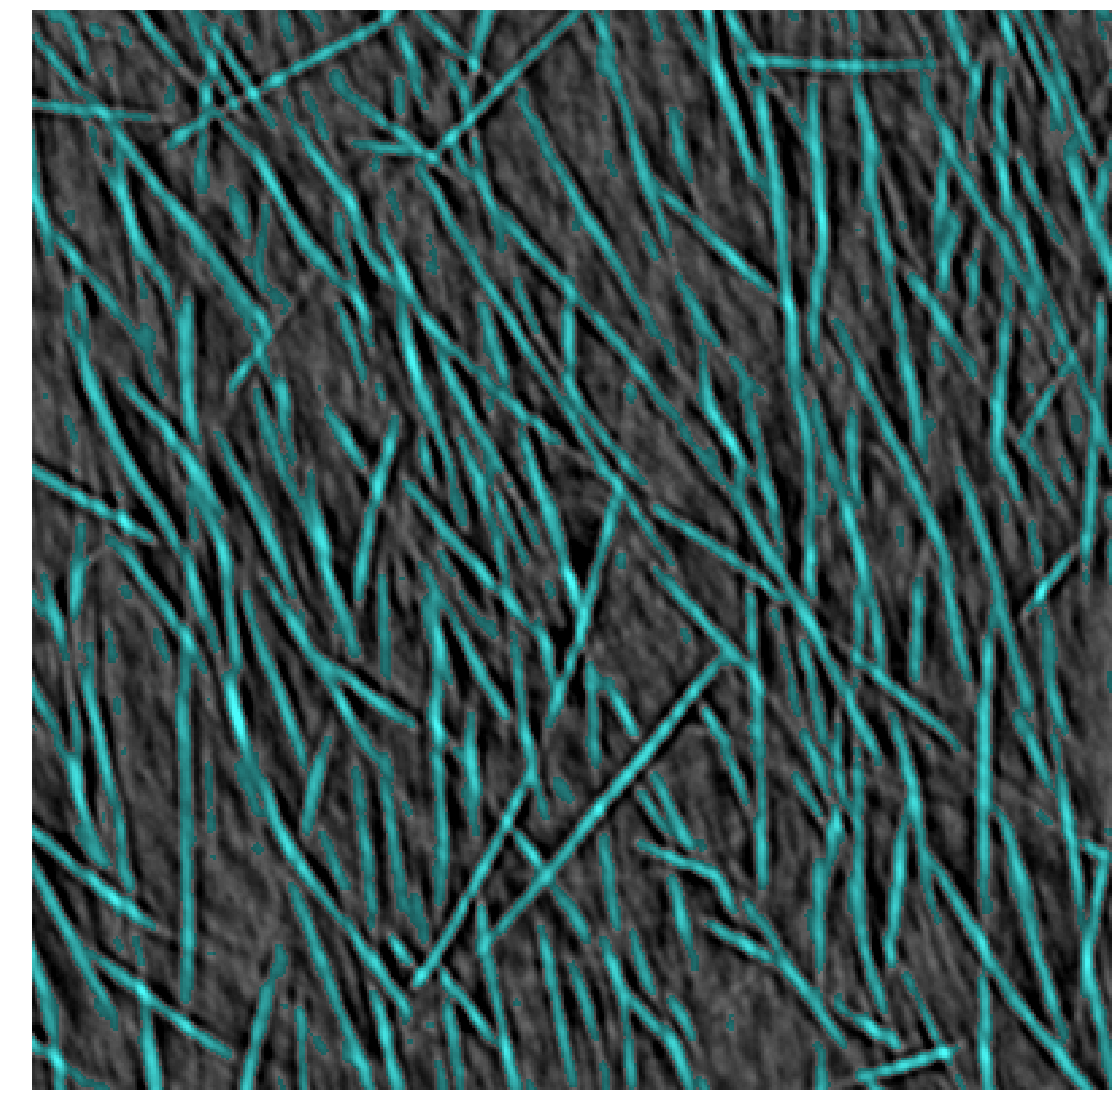

In [605]:
colorify_slice_at(300,
                  './raw_samples_data/PCL_9%_wa/data_slices/',
                  None,
                  './raw_samples_data/PCL_9%_wa/fiber_mask_slices/',
                  show_partilces=False,
                  hist_percentile=(2.5, 99.99),
                  save_filepath='./data/results/PCL_wa/color_slice_300.png')

Slice: 160


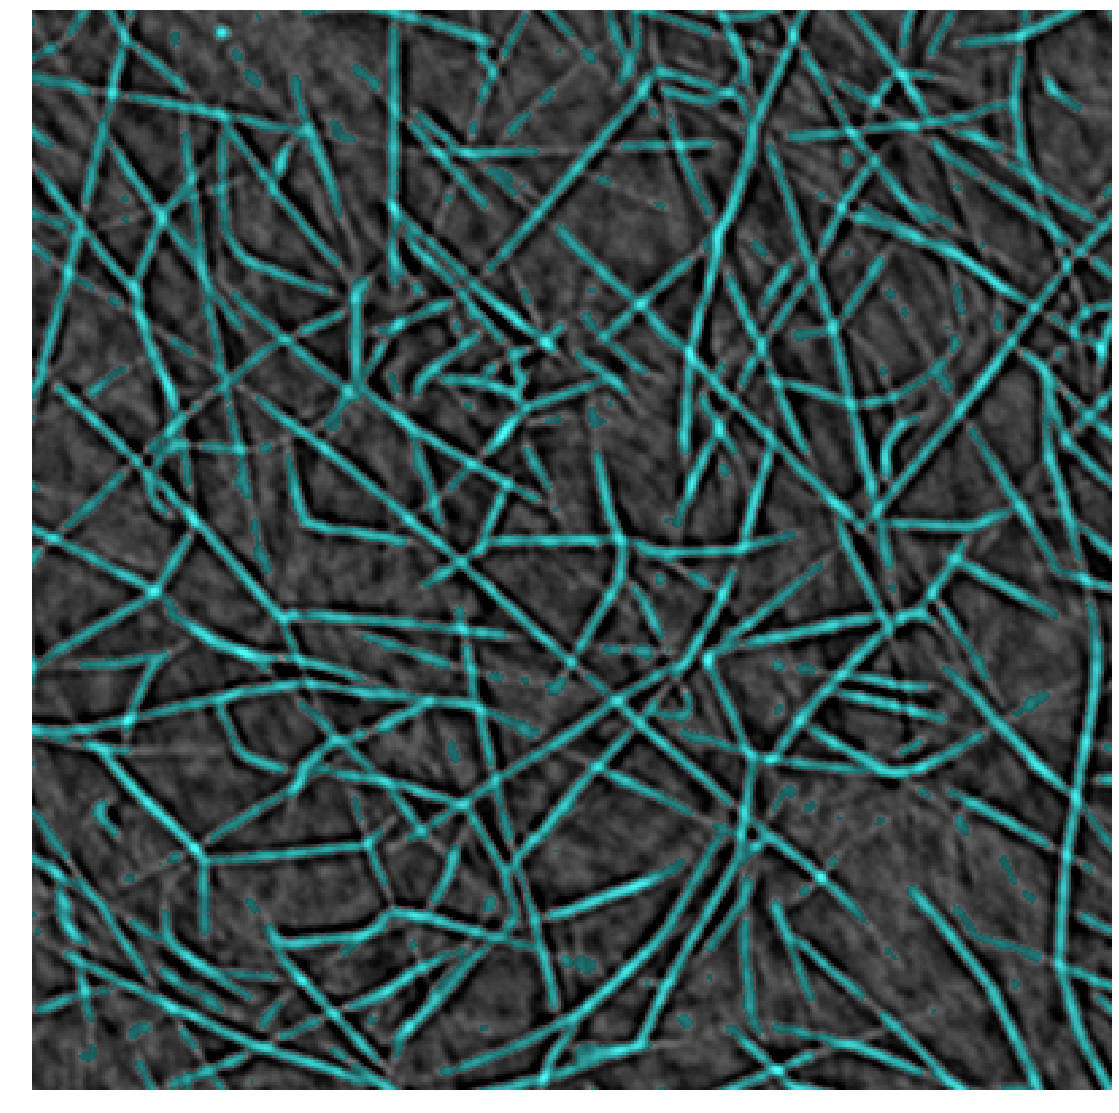

In [612]:
colorify_slice_at(160,
                  './raw_samples_data/PCL_9%_wa/data_slices/',
                  None,
                  './raw_samples_data/PCL_9%_wa/fiber_mask_slices/',
                  show_partilces=False,
                  hist_percentile=(2.5, 99.99),
                  save_filepath='./data/results/PCL_cl/color_slice_160.png')

Slice: 197


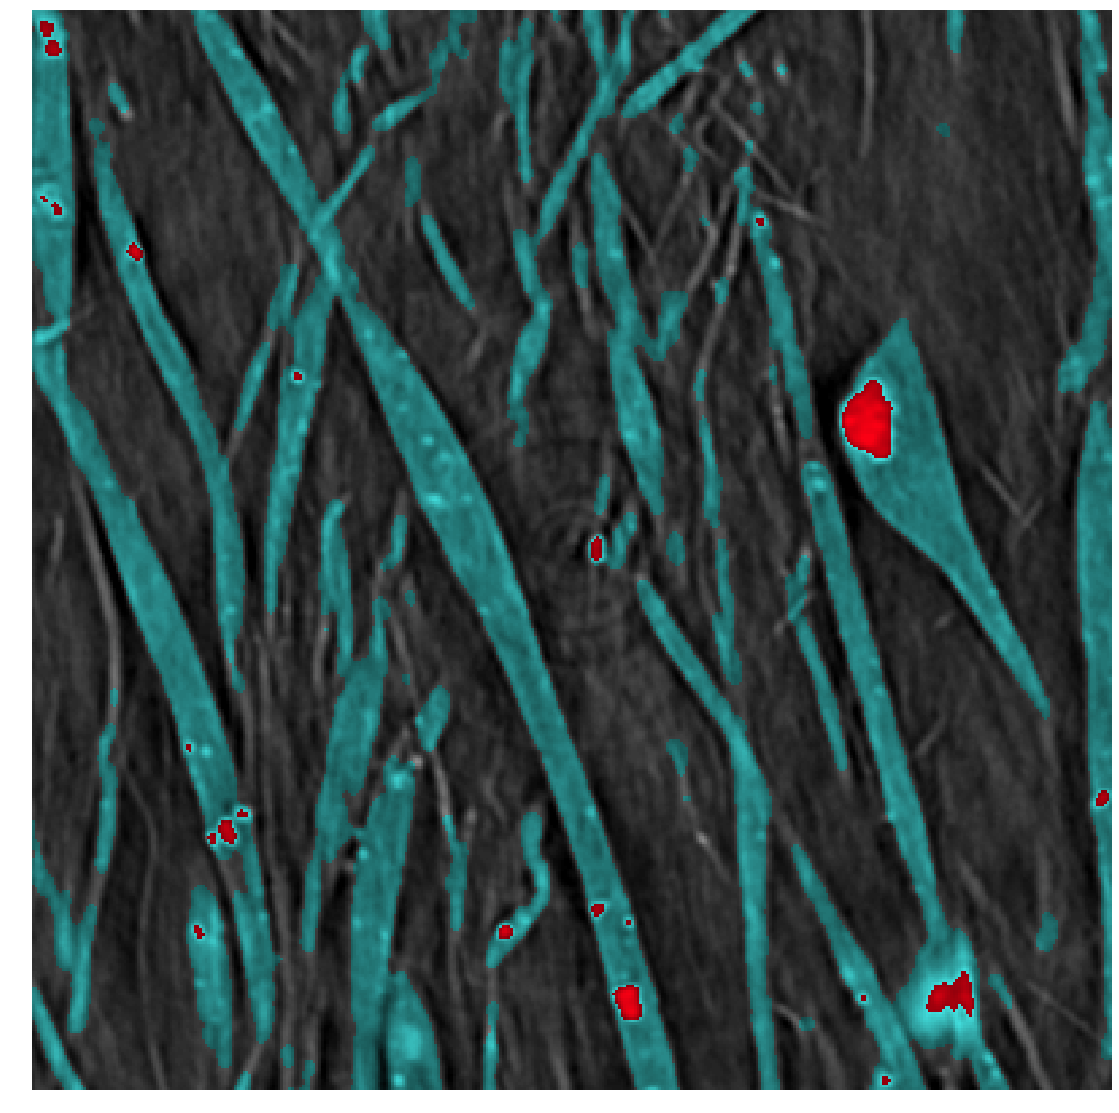

In [614]:
colorify_slice_at(197,
                  './raw_samples_data/PCL9%_Si-HA10%_wa/data_slices/',
                  './raw_samples_data/PCL9%_Si-HA10%_wa/particles_mask_slices/',
                  './raw_samples_data/PCL9%_Si-HA10%_wa/fiber_mask_slices/',
                  color_polymer_multiplier=1.5,
                  color_particles_multiplier=1.0,
                  hist_percentile=(0.3, 99.99),
                  save_filepath='./data/results/PCL_SiHA_wa/color_slice_197.png')

Slice: 61


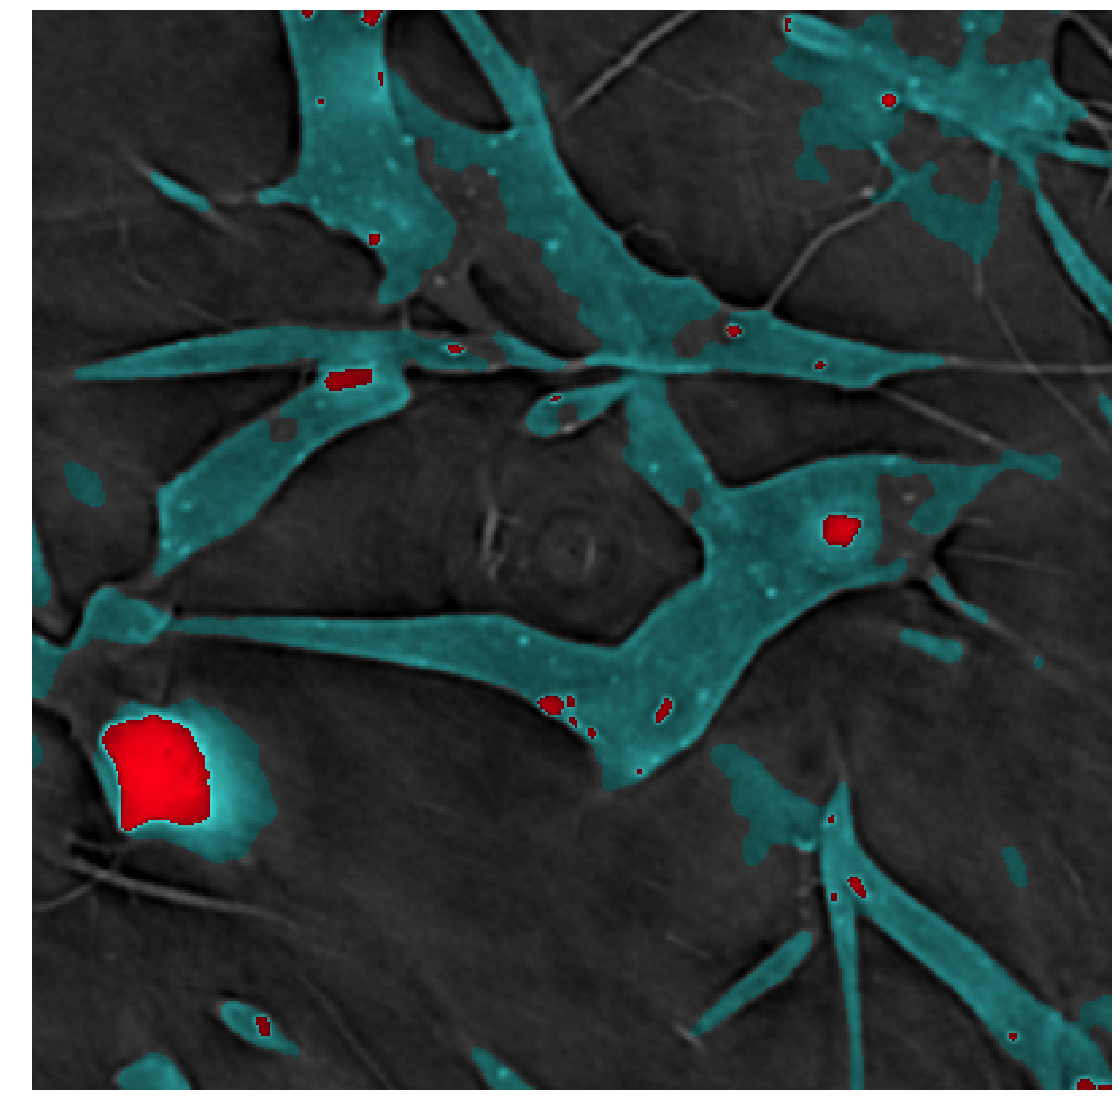

In [611]:
colorify_slice_at(61,
                  './raw_samples_data/PCL9%_Si-HA10%_cl/data_slices/',
                  './raw_samples_data/PCL9%_Si-HA10%_cl/particles_mask_slices/',
                  './raw_samples_data/PCL9%_Si-HA10%_cl/fiber_mask_slices/',
                  color_polymer_multiplier=1.5,
                  hist_percentile=(0.3, 99.99),
                  save_filepath='./data/results/PCL_SiHA_cl/color_slice_61.png')